In [1]:
# Load packages
from datetime import datetime
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy
import sys

In [2]:
# declare universal variables
CONDITION = 'fgr'
CONDITION_CLINICAL_DF = 'FGR'
SUFFIX = ' (protein)'

In [3]:
# Set up logger
os.remove('spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.log')
logger = logging.getLogger('analytics')

# Set the logging level
logger.setLevel(logging.INFO)

# Define a log format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a console handler to output log messages to the console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# (Optional) Create a file handler to log messages to a file
file_handler = logging.FileHandler('spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [4]:
dfpb = pd.read_table('../data/proteins-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmb = pd.read_table('../data/metabolites-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmirna = pd.read_table('../data/mirna-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dftb = pd.read_table('../data/transcripts-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfph = pd.read_table('../data/PlacentalHistopathologyReportsCleaned.csv', sep=',', dtype={'Patient-ID':str})
dfph2 = pd.read_table('../data/PlacentalHistopathologySlideFeaturesCleaned.csv', sep=',', dtype={'Patient-ID':str})

dfp_analyte = pd.read_table('../data/protein-meta-final.csv', sep=',')
dfm_analyte = pd.read_table('../data/metabolites-meta-final.csv', sep=',')
dfmirna_analyte = pd.read_table('../data/mirna-meta-final.csv', sep=',')
dft_analyte = pd.read_table('../data/transcripts-meta-final.csv', sep=',')

df_clinical = pd.read_table('../data/metadata-final.csv', sep=',', dtype={'Study_ID/ID':str})
df_clinical = df_clinical[df_clinical['Condition']==CONDITION_CLINICAL_DF]

In [5]:
dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((321, 352), (319, 866), (294, 450), (294, 9585), (275, 6), (348, 9), (40, 21))

# Set up annotations

In [6]:
metabolites = {}
for index, row in dfm_analyte.iterrows():
    metabolites[row['CHEMICAL_NAME']] = {'name': row['CHEMICAL_NAME'], 'sub_group': row['SUB_PATHWAY'], 'super_group': row['SUPER_PATHWAY']}
    
miRNAs = {}
for index, row in dfmirna_analyte.iterrows():
    miRNAs[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
proteins = {}
for index, row in dfp_analyte.iterrows():
    proteins[row['Assay'] + SUFFIX] = {'name': row['Assay'], 'sub_group': None, 'super_group': row['Panel']}
    
transcripts = {}
for index, row in dft_analyte.iterrows():
    transcripts[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
histopathology = {}
for item in dfph:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
for item in dfph2:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
        
# print the number of included analytes
print('Histopathology Features:', str(len(histopathology)))
print('Metabolites:', str(len(metabolites)))
print('miRNAs:', str(len(miRNAs)))
print('Proteins:', str(len(proteins)))
print('Transcripts:', str(len(transcripts)))
print('Total:', str(len(histopathology)+len(metabolites)+len(miRNAs)+len(proteins)+len(transcripts)))

Histopathology Features: 13
Metabolites: 1032
miRNAs: 2414
Proteins: 452
Transcripts: 51174
Total: 55085


# Merge against prot/met data

In [7]:
dfm_analyte = list(set(metabolites.keys()).intersection(dfmb.columns))
dfmirna_analyte = list(set(miRNAs.keys()).intersection(dfmirna.columns))
dfp_analyte = list(set(proteins.keys()).intersection(dfpb.columns))
dft_analyte = list(set(transcripts.keys()).intersection(dftb.columns))
dfph_measurement = ['MVM', 'FVM', 'AI', 'CI', 'Placental Abnormality']
dfph_measurement2 = ['DVH', 'AVM', 'Syncytial Knots', 'Segmental Avascular Villi', 'DVM', 'Villitis of Unknown Etiology', 'Diffuse Villous Edema', 'Chorangiosis']

# Get all analytes together
analytes = dfph_measurement + dfph_measurement2 + dfm_analyte + dfmirna_analyte + dfp_analyte + dft_analyte

# print the number of included analytes that pass missingness threshold
print('Histopathology Features:', str(len(dfph_measurement)+len(dfph_measurement2)))
print('Metabolites:', str(len(dfm_analyte)))
print('miRNAs:', str(len(dfmirna_analyte)))
print('Proteins:', str(len(dfp_analyte)))
print('Transcripts:', str(len(dft_analyte)))
print('Total:', str(len(analytes)))

Histopathology Features: 13
Metabolites: 865
miRNAs: 448
Proteins: 343
Transcripts: 9582
Total: 11251


In [8]:
df_clinical.head()

Patient-ID Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
4     MJ-0006       FGR                0         32.0      1.0      0.0  \
9     MJ-0036       FGR                0         25.0      1.0      0.0   
10    MJ-0042       FGR                0         30.0      1.0      0.0   
12    MJ-0045       FGR                1         32.0      1.0      0.0   
13    MJ-0053       FGR                0         23.0      0.0      1.0   

    isAsian  Ethnicity    WksGest  PregravidBMI  ...  Para  LaborOnset   
4       0.0        0.0  38.000000     16.264000  ...   0.0         1.0  \
9       0.0        0.0  37.000000     21.333333  ...   0.0         1.0   
10      0.0        0.0  38.000000     21.295295  ...   1.0         1.0   
12      0.0       -1.0  39.000000     26.673324  ...   0.0         0.0   
13      0.0        0.0  36.285714     29.752066  ...   0.0         0.0   

    Smoker  IllicitDrugUser  DeliveryMethod  PregnancyRelatedHypertension   
4      0.0              0.0             0.0                             0  \
9      0.0              0.0             0.0                             0   
10     1.0              0.0             0.0                             0   
12     0.0              0.0             1.0                             1   
13     0.0              0.0             1.0                             0   

    FetalGrowthRestriction  Preeclampsia  InfSex  Birthweight  
4                        1             0     1.0       2295.0  
9                        1             0     0.0       1675.0  
10                       1             0     0.0       2245.0  
12                       1             0     1.0       2518.0  
13                       1             0     1.0       1510.0  

[5 rows x 21 columns]

In [9]:
df = df_clinical.merge(dfph[['Patient-ID'] + list(dfph_measurement)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfph2[['Patient-ID'] + list(dfph_measurement2)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfpb[['Patient-ID'] + list(dfp_analyte)], on=['Patient-ID'], how='inner')
print(df.shape)
df = df.merge(dfmb[['Patient-ID'] + list(dfm_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfmirna[['Patient-ID'] + list(dfmirna_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dftb[['Patient-ID'] + list(dft_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.fillna(-1)

(40, 26)
(40, 34)
(36, 377)
(36, 1242)
(36, 1690)
(36, 11272)


In [10]:
df.shape, dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((36, 11272),
 (321, 352),
 (319, 866),
 (294, 450),
 (294, 9585),
 (275, 6),
 (348, 9),
 (40, 21))

In [11]:
df['InfSex'].value_counts()

InfSex
0.0    20
1.0    16
Name: count, dtype: int64

In [12]:
df['isWhite'].value_counts()

isWhite
1.0    25
0.0    11
Name: count, dtype: int64

In [13]:
df['isBlack'].value_counts()

isBlack
0.0    27
1.0     9
Name: count, dtype: int64

In [14]:
df['isAsian'].value_counts()

isAsian
0.0    34
1.0     2
Name: count, dtype: int64

In [15]:
df.head()

Patient-ID Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
0    MJ-0042       FGR                0         30.0      1.0      0.0  \
1    MJ-0045       FGR                1         32.0      1.0      0.0   
2    MJ-0053       FGR                0         23.0      0.0      1.0   
3    MJ-0107       FGR                0         34.0      1.0      0.0   
4    MJ-0200       FGR                0         39.0      1.0      0.0   

   isAsian  Ethnicity    WksGest  PregravidBMI  ...    NEK7  RASSF7  VASH1   
0      0.0        0.0  38.000000     21.295295  ...  2982.0   225.0  334.0  \
1      0.0       -1.0  39.000000     26.673324  ...  4065.0   175.0  310.0   
2      0.0        0.0  36.285714     29.752066  ...  7441.0   430.0  300.0   
3      0.0        0.0  37.142857     -1.000000  ...  6183.0   289.0  536.0   
4      0.0        0.0  36.571429     29.687500  ...  3911.0   245.0  804.0   

    ATOSA   CCND2   TNIK  PTDSS1  RN7SKP80      ABCA12   MCM5  
0  1073.0  1279.0  134.0   735.0    1312.0  104.620197  651.0  
1   564.0  1048.0   70.0   455.0    1685.0   60.000000  361.0  
2  1427.0  1969.0  142.0   558.0    1312.0   70.000000  493.0  
3  1227.0  1263.0  205.0   818.0    3125.0  212.557538  854.0  
4   819.0  2865.0  142.0   867.0     570.0   83.513364  742.0  

[5 rows x 11272 columns]

# Correlation network

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp
from statsmodels.genmod.families import family, links
import itertools

In [17]:
drop_cols = ['Patient-ID', 'Grav', 'DeliveryMethod', 
             'Para', 'PrePregWt_Kg', 'Ethnicity', 'isAsian', 
             'isBlack', 'WksGest', 'Condition', 'isWhite', 
             'Race', 'MaternalAge', 'Smoke', 'PregravidBMI',
             'HeightMeters']

# Pairwise GLM

In [18]:
def count_pairs(dat, analytes, proteins, metabolites, mirnas, transcripts, histopathology):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                    
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue
            
        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'

        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
    
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None
            
        count += 1
        
    print('Running {} pairs'.format(count))

count_pairs(df, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-04 20:56:13,353 - analytics - INFO - Created 63286875 pairs


Running 16851765 pairs


In [19]:
def evaluate_effect_size(df, logger):
    # evaluate effect size - cohen's d
    df_no_effect = df[abs(df['coef'])<0.01]
    df_very_small = df[abs(df['coef'])>=0.01]
    df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
    df_small = df[abs(df['coef'])>=0.1]
    df_small = df_small[abs(df_small['coef'])<0.2]
    df_medium = df[abs(df['coef'])>=0.2]
    df_medium  = df_medium[abs(df_medium['coef'])<0.3]
    df_medium_large = df[abs(df['coef'])>=0.3]
    df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
    df_large = df[abs(df['coef'])>=0.5]
    df_large = df_large[abs(df_large['coef'])<0.7]
    df_very_large = df[abs(df['coef'])>=0.7]
    df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
    df_huge = df[abs(df['coef'])>=0.9]
    
    # print info on effect sizes
    logger.info('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
    logger.info('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
    logger.info('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
    logger.info('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
    logger.info('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
    logger.info('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))
    logger.info('\n')
    

def run_spearman_pairwise(dat, condition, analytes, proteins, metabolites, mirnas, transcripts, histopathology, max_run=None):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
    
    f_failed = open('failed.spearman.standardized.interomics.' + condition + '.pairs.all.miniDP3.txt', mode='w')
    f_output = 'spearman.standardized.interomics.' + condition + '.all.miniDP3.txt'
    f_output_sig = 'spearman.standardized.interomics.' + condition + '.sig.miniDP3.txt'
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                           
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue

        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'
        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None

        sub = dat[['Patient-ID', col1, col2]].copy()
        sub.rename(columns={col1:'analyte1'}, inplace=True)
        sub.rename(columns={col2:'analyte2'}, inplace=True)


        if (sub['analyte1'].skew() > 1.5) | (sub['analyte1'].skew() < -1.5):

            #logger.info('Setting gamma family for skewed analyte %s'%(col))

            # Set any zero values to 1/2 the smallest value
            sub.loc[sub['analyte1']==0, 'analyte1'] = (sub.loc[sub['analyte1']>0, 'analyte1'].min() / 2.0)
            

        # z-score transform dependent variable data
        if col2 not in histopathology.keys():
            sub['analyte2'] = sub['analyte2'].astype(np.float64)
            sub['analyte2'] = (sub['analyte2'] - sub['analyte2'].mean() ) / sub['analyte2'].std()

            
        try:
            coef, p = scipy.stats.spearmanr(sub['analyte1'], sub['analyte2'])
            results.append((col1, name1, type1, supergroup1, subgroup1, col2, name2, type2, supergroup2, subgroup2, coef, p))
            completed += 1

        except Exception as e:
            logger.info('Failed analytes {} {} with error {}'.format(col1, col2, str(e)))
            f_failed.write(col1 + '\t' + col2 + '\n')
            
            
        count += 1
        if (max_run is not None) and (count >= max_run):
            break
        
        if (count % 1000) == 0:
            elapsed_time = datetime.now() - start_time    
            logger.info('Finished {} in {:.3f} seconds (skipped {})'.format(count, elapsed_time.total_seconds(), skipped))
            
    df = pd.DataFrame(results, columns=['col1', 'name1', 'type1', 'supergroup1', 'subgroup1', 'col2', 'name2', 'type2', 'supergroup2', 'subgroup2', 'coef', 'p-value'])
    df.sort_values(['p-value'], ascending=True, inplace=True)
    f_failed.close()

    np.seterr(all='warn')
    logger.info('\nFinished analyzing all {} pairs!'.format(str(count)))
    logger.info('Number of analyte pairs with converged formula: {}'.format(str(df.shape[0])))
    (adj_pval_index, adj_pval, _, _) = statsmodels.sandbox.stats.multicomp.multipletests(df.loc[~df['p-value'].isnull(), 'p-value'], alpha=0.05, method='fdr_bh')
    df.loc[~df['p-value'].isnull(), 'pval_adj'] = adj_pval
    df.sort_values(['pval_adj'], ascending=True, inplace=True)
    df.to_csv(f_output, index=False, sep='\t')
    
    # filter for significance
    df = df[df['pval_adj']<0.05]  #benjammini-hochman
    #bonferroni_correction = 0.05/count
    #df = df[df['p-value']<bonferroni_correction]  #bonferroni correction
    #logger.info('\nBonferroni Correction: p<{}'.format(str(bonferroni_correction)))
    logger.info('Number of analyte pairs whose levels are significantly associated: {}'.format(str(df.shape[0])))
    df.to_csv(f_output_sig, index=False, sep='\t')
    
    # evaluate effect size - cohen's d
    logger.info('Effect Sizes (Cohen\'s D ) For Significant Correlations:')
    evaluate_effect_size(df, logger)
    logger.info('\nFinished all correlation analyses!')
    
    return df

In [20]:
os.remove('failed.spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.' + CONDITION + '.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt')

In [21]:
spearman_pairwise = run_spearman_pairwise(df, CONDITION, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-04 20:57:20,810 - analytics - INFO - Created 63286875 pairs
2024-02-04 20:57:23,701 - analytics - INFO - Finished 1000 in 2.888 seconds (skipped 0)
2024-02-04 20:57:26,624 - analytics - INFO - Finished 2000 in 5.810 seconds (skipped 0)
2024-02-04 20:57:29,421 - analytics - INFO - Finished 3000 in 8.607 seconds (skipped 0)
2024-02-04 20:57:32,194 - analytics - INFO - Finished 4000 in 11.381 seconds (skipped 0)
2024-02-04 20:57:35,385 - analytics - INFO - Finished 5000 in 14.571 seconds (skipped 0)
2024-02-04 20:57:38,687 - analytics - INFO - Finished 6000 in 17.873 seconds (skipped 0)
2024-02-04 20:57:42,020 - analytics - INFO - Finished 7000 in 21.207 seconds (skipped 0)
2024-02-04 20:57:45,588 - analytics - INFO - Finished 8000 in 24.775 seconds (skipped 0)
2024-02-04 20:57:49,134 - analytics - INFO - Finished 9000 in 28.320 seconds (skipped 0)
2024-02-04 20:57:52,878 - analytics - INFO - Finished 10000 in 32.064 seconds (skipped 0)
2024-02-04 20:57:56,776 - analytics - INFO -

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
2024-02-04 21:02:17,050 - analytics - INFO - Finished 95000 in 296.237 seconds (skipped 0)
/usr/local/lib/python3.11/site-pa

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

2024-02-04 21:02:44,718 - analytics - INFO - Finished 106000 in 323.904 seconds (skipped 0)
2024-02-04 21:02:47,555 - analytics - INFO - Finished 107000 in 326.742 seconds (skipped 0)
2024-02-04 21:02:50,398 - analytics - INFO - Finished 108000 in 329.584 seconds (skipped 0)
2024-02-04 21:02:53,258 - analytics - INFO - Finished 109000 in 332.444 seconds (skipped 0)
2024-02-04 21:02:56,095 - analytics - INFO - Finished 110000 in 335.281 seconds (skipped 0)
2024-02-04 21:02:58,956 - analytics - INFO - Finished 111000 in 338.143 seconds (skipped 0)
2024-02-04 21:03:01,796 - analytics - INFO - Finished 112000 in 340.982 seconds (skipped 0)
2024-02-04 21:03:04,634 - analytics - INFO - Finished 113000 in 343.820 seconds (skipped 0)
2024-02-04 21:03:07,548 - analytics - INFO - Finished 114000 in 346.735 seconds (skipped 0)
2024-02-04 21:03:10,375 - analytics - INFO - Finished 115000 in 349.562 seconds (skipped 0)
2024-02-04 21:03:13,585 - analytics - INFO - Finished 116000 in 352.772 seconds 

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

2024-02-04 21:07:53,092 - analytics - INFO - Finished 222000 in 632.279 seconds (skipped 0)
2024-02-04 21:07:55,758 - analytics - INFO - Finished 223000 in 634.945 seconds (skipped 0)
2024-02-04 21:07:58,105 - analytics - INFO - Finished 224000 in 637.291 seconds (skipped 0)
2024-02-04 21:08:00,426 - analytics - INFO - Finished 225000 in 639.613 seconds (skipped 0)
2024-02-04 21:08:02,838 - analytics - INFO - Finished 226000 in 642.024 seconds (skipped 0)
2024-02-04 21:08:05,374 - analytics - INFO - Finished 227000 in 644.561 seconds (skipped 0)
2024-02-04 21:08:07,722 - analytics - INFO - Finished 228000 in 646.909 seconds (skipped 0)
2024-02-04 21:08:10,171 - analytics - INFO - Finished 229000 in 649.357 seconds (skipped 0)
2024-02-04 21:08:12,856 - analytics - INFO - Finished 230000 in 652.042 seconds (skipped 0)
2024-02-04 21:08:15,585 - analytics - INFO - Finished 231000 in 654.772 seconds (skipped 0)
2024-02-04 21:08:18,057 - analytics - INFO - Finished 232000 in 657.243 seconds 

2024-02-04 21:11:38,630 - analytics - INFO - Finished 312000 in 857.817 seconds (skipped 0)
2024-02-04 21:11:41,368 - analytics - INFO - Finished 313000 in 860.555 seconds (skipped 0)
2024-02-04 21:11:44,221 - analytics - INFO - Finished 314000 in 863.408 seconds (skipped 0)
2024-02-04 21:11:46,984 - analytics - INFO - Finished 315000 in 866.171 seconds (skipped 0)
2024-02-04 21:11:49,872 - analytics - INFO - Finished 316000 in 869.058 seconds (skipped 0)
2024-02-04 21:11:52,745 - analytics - INFO - Finished 317000 in 871.931 seconds (skipped 0)
2024-02-04 21:11:55,535 - analytics - INFO - Finished 318000 in 874.722 seconds (skipped 0)
2024-02-04 21:11:58,437 - analytics - INFO - Finished 319000 in 877.624 seconds (skipped 0)
2024-02-04 21:12:01,317 - analytics - INFO - Finished 320000 in 880.504 seconds (skipped 0)
2024-02-04 21:12:04,176 - analytics - INFO - Finished 321000 in 883.362 seconds (skipped 0)
2024-02-04 21:12:07,426 - analytics - INFO - Finished 322000 in 886.612 seconds 

2024-02-04 21:16:06,689 - analytics - INFO - Finished 401000 in 1125.876 seconds (skipped 0)
2024-02-04 21:16:09,729 - analytics - INFO - Finished 402000 in 1128.916 seconds (skipped 0)
2024-02-04 21:16:13,046 - analytics - INFO - Finished 403000 in 1132.232 seconds (skipped 0)
2024-02-04 21:16:16,390 - analytics - INFO - Finished 404000 in 1135.576 seconds (skipped 0)
2024-02-04 21:16:19,666 - analytics - INFO - Finished 405000 in 1138.852 seconds (skipped 0)
2024-02-04 21:16:22,565 - analytics - INFO - Finished 406000 in 1141.751 seconds (skipped 0)
2024-02-04 21:16:24,879 - analytics - INFO - Finished 407000 in 1144.065 seconds (skipped 0)
2024-02-04 21:16:27,266 - analytics - INFO - Finished 408000 in 1146.453 seconds (skipped 0)
2024-02-04 21:16:29,876 - analytics - INFO - Finished 409000 in 1149.062 seconds (skipped 0)
2024-02-04 21:16:32,386 - analytics - INFO - Finished 410000 in 1151.572 seconds (skipped 0)
2024-02-04 21:16:34,979 - analytics - INFO - Finished 411000 in 1154.1

2024-02-04 21:20:22,910 - analytics - INFO - Finished 490000 in 1382.096 seconds (skipped 0)
2024-02-04 21:20:25,873 - analytics - INFO - Finished 491000 in 1385.060 seconds (skipped 0)
2024-02-04 21:20:28,869 - analytics - INFO - Finished 492000 in 1388.055 seconds (skipped 0)
2024-02-04 21:20:31,833 - analytics - INFO - Finished 493000 in 1391.019 seconds (skipped 0)
2024-02-04 21:20:34,812 - analytics - INFO - Finished 494000 in 1393.999 seconds (skipped 0)
2024-02-04 21:20:37,842 - analytics - INFO - Finished 495000 in 1397.028 seconds (skipped 0)
2024-02-04 21:20:40,853 - analytics - INFO - Finished 496000 in 1400.040 seconds (skipped 0)
2024-02-04 21:20:43,798 - analytics - INFO - Finished 497000 in 1402.985 seconds (skipped 0)
2024-02-04 21:20:46,700 - analytics - INFO - Finished 498000 in 1405.887 seconds (skipped 0)
2024-02-04 21:20:49,538 - analytics - INFO - Finished 499000 in 1408.724 seconds (skipped 0)
2024-02-04 21:20:51,999 - analytics - INFO - Finished 500000 in 1411.1

2024-02-04 21:24:33,123 - analytics - INFO - Finished 579000 in 1632.309 seconds (skipped 0)
2024-02-04 21:24:35,487 - analytics - INFO - Finished 580000 in 1634.674 seconds (skipped 0)
2024-02-04 21:24:37,854 - analytics - INFO - Finished 581000 in 1637.040 seconds (skipped 0)
2024-02-04 21:24:40,217 - analytics - INFO - Finished 582000 in 1639.403 seconds (skipped 0)
2024-02-04 21:24:42,521 - analytics - INFO - Finished 583000 in 1641.707 seconds (skipped 0)
2024-02-04 21:24:44,917 - analytics - INFO - Finished 584000 in 1644.103 seconds (skipped 0)
2024-02-04 21:24:47,342 - analytics - INFO - Finished 585000 in 1646.529 seconds (skipped 0)
2024-02-04 21:24:49,744 - analytics - INFO - Finished 586000 in 1648.930 seconds (skipped 0)
2024-02-04 21:24:52,111 - analytics - INFO - Finished 587000 in 1651.297 seconds (skipped 0)
2024-02-04 21:24:54,449 - analytics - INFO - Finished 588000 in 1653.636 seconds (skipped 0)
2024-02-04 21:24:56,762 - analytics - INFO - Finished 589000 in 1655.9

2024-02-04 21:28:21,636 - analytics - INFO - Finished 668000 in 1860.822 seconds (skipped 0)
2024-02-04 21:28:24,520 - analytics - INFO - Finished 669000 in 1863.707 seconds (skipped 0)
2024-02-04 21:28:27,368 - analytics - INFO - Finished 670000 in 1866.554 seconds (skipped 0)
2024-02-04 21:28:30,213 - analytics - INFO - Finished 671000 in 1869.399 seconds (skipped 0)
2024-02-04 21:28:33,094 - analytics - INFO - Finished 672000 in 1872.281 seconds (skipped 0)
2024-02-04 21:28:35,870 - analytics - INFO - Finished 673000 in 1875.057 seconds (skipped 0)
2024-02-04 21:28:38,710 - analytics - INFO - Finished 674000 in 1877.897 seconds (skipped 0)
2024-02-04 21:28:41,561 - analytics - INFO - Finished 675000 in 1880.748 seconds (skipped 0)
2024-02-04 21:28:43,971 - analytics - INFO - Finished 676000 in 1883.158 seconds (skipped 0)
2024-02-04 21:28:46,294 - analytics - INFO - Finished 677000 in 1885.480 seconds (skipped 0)
2024-02-04 21:28:48,695 - analytics - INFO - Finished 678000 in 1887.8

2024-02-04 21:32:18,180 - analytics - INFO - Finished 757000 in 2097.367 seconds (skipped 0)
2024-02-04 21:32:20,521 - analytics - INFO - Finished 758000 in 2099.707 seconds (skipped 0)
2024-02-04 21:32:23,416 - analytics - INFO - Finished 759000 in 2102.603 seconds (skipped 0)
2024-02-04 21:32:26,349 - analytics - INFO - Finished 760000 in 2105.535 seconds (skipped 0)
2024-02-04 21:32:29,220 - analytics - INFO - Finished 761000 in 2108.406 seconds (skipped 0)
2024-02-04 21:32:32,119 - analytics - INFO - Finished 762000 in 2111.305 seconds (skipped 0)
2024-02-04 21:32:34,985 - analytics - INFO - Finished 763000 in 2114.172 seconds (skipped 0)
2024-02-04 21:32:37,939 - analytics - INFO - Finished 764000 in 2117.125 seconds (skipped 0)
2024-02-04 21:32:40,860 - analytics - INFO - Finished 765000 in 2120.046 seconds (skipped 0)
2024-02-04 21:32:43,656 - analytics - INFO - Finished 766000 in 2122.842 seconds (skipped 0)
2024-02-04 21:32:46,537 - analytics - INFO - Finished 767000 in 2125.7

2024-02-04 21:36:15,510 - analytics - INFO - Finished 846000 in 2334.697 seconds (skipped 0)
2024-02-04 21:36:17,869 - analytics - INFO - Finished 847000 in 2337.056 seconds (skipped 0)
2024-02-04 21:36:20,223 - analytics - INFO - Finished 848000 in 2339.410 seconds (skipped 0)
2024-02-04 21:36:22,549 - analytics - INFO - Finished 849000 in 2341.735 seconds (skipped 0)
2024-02-04 21:36:24,920 - analytics - INFO - Finished 850000 in 2344.107 seconds (skipped 0)
2024-02-04 21:36:27,253 - analytics - INFO - Finished 851000 in 2346.439 seconds (skipped 0)
2024-02-04 21:36:29,574 - analytics - INFO - Finished 852000 in 2348.761 seconds (skipped 0)
2024-02-04 21:36:31,983 - analytics - INFO - Finished 853000 in 2351.169 seconds (skipped 0)
2024-02-04 21:36:34,283 - analytics - INFO - Finished 854000 in 2353.469 seconds (skipped 0)
2024-02-04 21:36:36,623 - analytics - INFO - Finished 855000 in 2355.809 seconds (skipped 0)
2024-02-04 21:36:38,965 - analytics - INFO - Finished 856000 in 2358.1

2024-02-04 21:40:06,661 - analytics - INFO - Finished 935000 in 2565.847 seconds (skipped 0)
2024-02-04 21:40:09,568 - analytics - INFO - Finished 936000 in 2568.754 seconds (skipped 0)
2024-02-04 21:40:12,831 - analytics - INFO - Finished 937000 in 2572.018 seconds (skipped 0)
2024-02-04 21:40:15,925 - analytics - INFO - Finished 938000 in 2575.112 seconds (skipped 0)
2024-02-04 21:40:18,819 - analytics - INFO - Finished 939000 in 2578.005 seconds (skipped 0)
2024-02-04 21:40:21,822 - analytics - INFO - Finished 940000 in 2581.008 seconds (skipped 0)
2024-02-04 21:40:24,765 - analytics - INFO - Finished 941000 in 2583.952 seconds (skipped 0)
2024-02-04 21:40:27,644 - analytics - INFO - Finished 942000 in 2586.831 seconds (skipped 0)
2024-02-04 21:40:30,537 - analytics - INFO - Finished 943000 in 2589.723 seconds (skipped 0)
2024-02-04 21:40:33,424 - analytics - INFO - Finished 944000 in 2592.611 seconds (skipped 0)
2024-02-04 21:40:36,256 - analytics - INFO - Finished 945000 in 2595.4

2024-02-04 21:43:50,486 - analytics - INFO - Finished 1023000 in 2789.673 seconds (skipped 0)
2024-02-04 21:43:52,815 - analytics - INFO - Finished 1024000 in 2792.001 seconds (skipped 0)
2024-02-04 21:43:55,142 - analytics - INFO - Finished 1025000 in 2794.328 seconds (skipped 0)
2024-02-04 21:43:57,514 - analytics - INFO - Finished 1026000 in 2796.701 seconds (skipped 0)
2024-02-04 21:43:59,888 - analytics - INFO - Finished 1027000 in 2799.074 seconds (skipped 0)
2024-02-04 21:44:02,306 - analytics - INFO - Finished 1028000 in 2801.492 seconds (skipped 0)
2024-02-04 21:44:05,063 - analytics - INFO - Finished 1029000 in 2804.250 seconds (skipped 0)
2024-02-04 21:44:07,921 - analytics - INFO - Finished 1030000 in 2807.107 seconds (skipped 0)
2024-02-04 21:44:10,728 - analytics - INFO - Finished 1031000 in 2809.915 seconds (skipped 0)
2024-02-04 21:44:14,056 - analytics - INFO - Finished 1032000 in 2813.243 seconds (skipped 0)
2024-02-04 21:44:17,112 - analytics - INFO - Finished 103300

2024-02-04 21:47:42,693 - analytics - INFO - Finished 1111000 in 3021.879 seconds (skipped 0)
2024-02-04 21:47:45,052 - analytics - INFO - Finished 1112000 in 3024.238 seconds (skipped 0)
2024-02-04 21:47:47,349 - analytics - INFO - Finished 1113000 in 3026.536 seconds (skipped 0)
2024-02-04 21:47:49,663 - analytics - INFO - Finished 1114000 in 3028.849 seconds (skipped 0)
2024-02-04 21:47:51,932 - analytics - INFO - Finished 1115000 in 3031.118 seconds (skipped 0)
2024-02-04 21:47:54,224 - analytics - INFO - Finished 1116000 in 3033.411 seconds (skipped 0)
2024-02-04 21:47:56,535 - analytics - INFO - Finished 1117000 in 3035.721 seconds (skipped 0)
2024-02-04 21:47:58,865 - analytics - INFO - Finished 1118000 in 3038.051 seconds (skipped 0)
2024-02-04 21:48:01,142 - analytics - INFO - Finished 1119000 in 3040.328 seconds (skipped 0)
2024-02-04 21:48:03,435 - analytics - INFO - Finished 1120000 in 3042.621 seconds (skipped 0)
2024-02-04 21:48:05,721 - analytics - INFO - Finished 112100

2024-02-04 21:51:22,330 - analytics - INFO - Finished 1199000 in 3241.517 seconds (skipped 0)
2024-02-04 21:51:24,634 - analytics - INFO - Finished 1200000 in 3243.820 seconds (skipped 0)
2024-02-04 21:51:26,868 - analytics - INFO - Finished 1201000 in 3246.054 seconds (skipped 0)
2024-02-04 21:51:29,117 - analytics - INFO - Finished 1202000 in 3248.304 seconds (skipped 0)
2024-02-04 21:51:31,408 - analytics - INFO - Finished 1203000 in 3250.594 seconds (skipped 0)
2024-02-04 21:51:33,706 - analytics - INFO - Finished 1204000 in 3252.892 seconds (skipped 0)
2024-02-04 21:51:36,468 - analytics - INFO - Finished 1205000 in 3255.654 seconds (skipped 0)
2024-02-04 21:51:39,320 - analytics - INFO - Finished 1206000 in 3258.507 seconds (skipped 0)
2024-02-04 21:51:42,065 - analytics - INFO - Finished 1207000 in 3261.251 seconds (skipped 0)
2024-02-04 21:51:44,824 - analytics - INFO - Finished 1208000 in 3264.011 seconds (skipped 0)
2024-02-04 21:51:47,604 - analytics - INFO - Finished 120900

2024-02-04 21:55:10,632 - analytics - INFO - Finished 1287000 in 3469.819 seconds (skipped 0)
2024-02-04 21:55:13,637 - analytics - INFO - Finished 1288000 in 3472.823 seconds (skipped 0)
2024-02-04 21:55:16,535 - analytics - INFO - Finished 1289000 in 3475.721 seconds (skipped 0)
2024-02-04 21:55:19,333 - analytics - INFO - Finished 1290000 in 3478.519 seconds (skipped 0)
2024-02-04 21:55:22,103 - analytics - INFO - Finished 1291000 in 3481.290 seconds (skipped 0)
2024-02-04 21:55:25,002 - analytics - INFO - Finished 1292000 in 3484.189 seconds (skipped 0)
2024-02-04 21:55:27,798 - analytics - INFO - Finished 1293000 in 3486.984 seconds (skipped 0)
2024-02-04 21:55:30,587 - analytics - INFO - Finished 1294000 in 3489.773 seconds (skipped 0)
2024-02-04 21:55:33,348 - analytics - INFO - Finished 1295000 in 3492.534 seconds (skipped 0)
2024-02-04 21:55:36,115 - analytics - INFO - Finished 1296000 in 3495.302 seconds (skipped 0)
2024-02-04 21:55:38,905 - analytics - INFO - Finished 129700

2024-02-04 21:59:02,045 - analytics - INFO - Finished 1375000 in 3701.231 seconds (skipped 0)
2024-02-04 21:59:04,762 - analytics - INFO - Finished 1376000 in 3703.948 seconds (skipped 0)
2024-02-04 21:59:07,512 - analytics - INFO - Finished 1377000 in 3706.698 seconds (skipped 0)
2024-02-04 21:59:10,275 - analytics - INFO - Finished 1378000 in 3709.461 seconds (skipped 0)
2024-02-04 21:59:13,240 - analytics - INFO - Finished 1379000 in 3712.427 seconds (skipped 0)
2024-02-04 21:59:16,330 - analytics - INFO - Finished 1380000 in 3715.517 seconds (skipped 0)
2024-02-04 21:59:18,875 - analytics - INFO - Finished 1381000 in 3718.061 seconds (skipped 0)
2024-02-04 21:59:21,138 - analytics - INFO - Finished 1382000 in 3720.324 seconds (skipped 0)
2024-02-04 21:59:23,437 - analytics - INFO - Finished 1383000 in 3722.624 seconds (skipped 0)
2024-02-04 21:59:25,697 - analytics - INFO - Finished 1384000 in 3724.883 seconds (skipped 0)
2024-02-04 21:59:27,973 - analytics - INFO - Finished 138500

2024-02-04 22:02:58,014 - analytics - INFO - Finished 1463000 in 3937.201 seconds (skipped 0)
2024-02-04 22:03:00,481 - analytics - INFO - Finished 1464000 in 3939.667 seconds (skipped 0)
2024-02-04 22:03:02,734 - analytics - INFO - Finished 1465000 in 3941.920 seconds (skipped 0)
2024-02-04 22:03:05,031 - analytics - INFO - Finished 1466000 in 3944.217 seconds (skipped 0)
2024-02-04 22:03:07,303 - analytics - INFO - Finished 1467000 in 3946.490 seconds (skipped 0)
2024-02-04 22:03:09,600 - analytics - INFO - Finished 1468000 in 3948.787 seconds (skipped 0)
2024-02-04 22:03:12,178 - analytics - INFO - Finished 1469000 in 3951.364 seconds (skipped 0)
2024-02-04 22:03:14,523 - analytics - INFO - Finished 1470000 in 3953.710 seconds (skipped 0)
2024-02-04 22:03:16,859 - analytics - INFO - Finished 1471000 in 3956.045 seconds (skipped 0)
2024-02-04 22:03:19,164 - analytics - INFO - Finished 1472000 in 3958.351 seconds (skipped 0)
2024-02-04 22:03:21,414 - analytics - INFO - Finished 147300

2024-02-04 22:06:51,610 - analytics - INFO - Finished 1551000 in 4170.796 seconds (skipped 0)
2024-02-04 22:06:53,852 - analytics - INFO - Finished 1552000 in 4173.038 seconds (skipped 0)
2024-02-04 22:06:56,176 - analytics - INFO - Finished 1553000 in 4175.362 seconds (skipped 0)
2024-02-04 22:06:58,413 - analytics - INFO - Finished 1554000 in 4177.599 seconds (skipped 0)
2024-02-04 22:07:00,906 - analytics - INFO - Finished 1555000 in 4180.092 seconds (skipped 0)
2024-02-04 22:07:03,245 - analytics - INFO - Finished 1556000 in 4182.432 seconds (skipped 0)
2024-02-04 22:07:05,526 - analytics - INFO - Finished 1557000 in 4184.713 seconds (skipped 0)
2024-02-04 22:07:07,840 - analytics - INFO - Finished 1558000 in 4187.027 seconds (skipped 0)
2024-02-04 22:07:10,254 - analytics - INFO - Finished 1559000 in 4189.440 seconds (skipped 0)
2024-02-04 22:07:12,759 - analytics - INFO - Finished 1560000 in 4191.945 seconds (skipped 0)
2024-02-04 22:07:15,158 - analytics - INFO - Finished 156100

2024-02-04 22:10:35,265 - analytics - INFO - Finished 1639000 in 4394.452 seconds (skipped 0)
2024-02-04 22:10:37,501 - analytics - INFO - Finished 1640000 in 4396.688 seconds (skipped 0)
2024-02-04 22:10:39,800 - analytics - INFO - Finished 1641000 in 4398.987 seconds (skipped 0)
2024-02-04 22:10:42,029 - analytics - INFO - Finished 1642000 in 4401.215 seconds (skipped 0)
2024-02-04 22:10:44,265 - analytics - INFO - Finished 1643000 in 4403.452 seconds (skipped 0)
2024-02-04 22:10:46,607 - analytics - INFO - Finished 1644000 in 4405.794 seconds (skipped 0)
2024-02-04 22:10:48,878 - analytics - INFO - Finished 1645000 in 4408.065 seconds (skipped 0)
2024-02-04 22:10:51,169 - analytics - INFO - Finished 1646000 in 4410.356 seconds (skipped 0)
2024-02-04 22:10:53,485 - analytics - INFO - Finished 1647000 in 4412.671 seconds (skipped 0)
2024-02-04 22:10:55,776 - analytics - INFO - Finished 1648000 in 4414.962 seconds (skipped 0)
2024-02-04 22:10:58,109 - analytics - INFO - Finished 164900

2024-02-04 22:14:02,413 - analytics - INFO - Finished 1727000 in 4601.600 seconds (skipped 0)
2024-02-04 22:14:04,637 - analytics - INFO - Finished 1728000 in 4603.824 seconds (skipped 0)
2024-02-04 22:14:06,949 - analytics - INFO - Finished 1729000 in 4606.135 seconds (skipped 0)
2024-02-04 22:14:09,257 - analytics - INFO - Finished 1730000 in 4608.443 seconds (skipped 0)
2024-02-04 22:14:11,773 - analytics - INFO - Finished 1731000 in 4610.959 seconds (skipped 0)
2024-02-04 22:14:14,229 - analytics - INFO - Finished 1732000 in 4613.415 seconds (skipped 0)
2024-02-04 22:14:16,625 - analytics - INFO - Finished 1733000 in 4615.812 seconds (skipped 0)
2024-02-04 22:14:19,301 - analytics - INFO - Finished 1734000 in 4618.488 seconds (skipped 0)
2024-02-04 22:14:22,202 - analytics - INFO - Finished 1735000 in 4621.388 seconds (skipped 0)
2024-02-04 22:14:25,013 - analytics - INFO - Finished 1736000 in 4624.200 seconds (skipped 0)
2024-02-04 22:14:27,852 - analytics - INFO - Finished 173700

2024-02-04 22:17:45,564 - analytics - INFO - Finished 1815000 in 4824.750 seconds (skipped 0)
2024-02-04 22:17:47,858 - analytics - INFO - Finished 1816000 in 4827.044 seconds (skipped 0)
2024-02-04 22:17:50,539 - analytics - INFO - Finished 1817000 in 4829.725 seconds (skipped 0)
2024-02-04 22:17:53,312 - analytics - INFO - Finished 1818000 in 4832.498 seconds (skipped 0)
2024-02-04 22:17:56,056 - analytics - INFO - Finished 1819000 in 4835.243 seconds (skipped 0)
2024-02-04 22:17:58,836 - analytics - INFO - Finished 1820000 in 4838.023 seconds (skipped 0)
2024-02-04 22:18:01,687 - analytics - INFO - Finished 1821000 in 4840.873 seconds (skipped 0)
2024-02-04 22:18:04,741 - analytics - INFO - Finished 1822000 in 4843.927 seconds (skipped 0)
2024-02-04 22:18:07,539 - analytics - INFO - Finished 1823000 in 4846.725 seconds (skipped 0)
2024-02-04 22:18:10,305 - analytics - INFO - Finished 1824000 in 4849.492 seconds (skipped 0)
2024-02-04 22:18:13,393 - analytics - INFO - Finished 182500

2024-02-04 22:21:31,066 - analytics - INFO - Finished 1903000 in 5050.252 seconds (skipped 0)
2024-02-04 22:21:33,858 - analytics - INFO - Finished 1904000 in 5053.045 seconds (skipped 0)
2024-02-04 22:21:36,722 - analytics - INFO - Finished 1905000 in 5055.908 seconds (skipped 0)
2024-02-04 22:21:39,577 - analytics - INFO - Finished 1906000 in 5058.763 seconds (skipped 0)
2024-02-04 22:21:42,294 - analytics - INFO - Finished 1907000 in 5061.480 seconds (skipped 0)
2024-02-04 22:21:45,076 - analytics - INFO - Finished 1908000 in 5064.262 seconds (skipped 0)
2024-02-04 22:21:47,940 - analytics - INFO - Finished 1909000 in 5067.126 seconds (skipped 0)
2024-02-04 22:21:50,698 - analytics - INFO - Finished 1910000 in 5069.885 seconds (skipped 0)
2024-02-04 22:21:53,555 - analytics - INFO - Finished 1911000 in 5072.741 seconds (skipped 0)
2024-02-04 22:21:56,297 - analytics - INFO - Finished 1912000 in 5075.484 seconds (skipped 0)
2024-02-04 22:21:59,117 - analytics - INFO - Finished 191300

2024-02-04 22:25:05,693 - analytics - INFO - Finished 1991000 in 5264.880 seconds (skipped 0)
2024-02-04 22:25:08,487 - analytics - INFO - Finished 1992000 in 5267.673 seconds (skipped 0)
2024-02-04 22:25:11,327 - analytics - INFO - Finished 1993000 in 5270.514 seconds (skipped 0)
2024-02-04 22:25:14,236 - analytics - INFO - Finished 1994000 in 5273.422 seconds (skipped 0)
2024-02-04 22:25:17,060 - analytics - INFO - Finished 1995000 in 5276.246 seconds (skipped 0)
2024-02-04 22:25:19,874 - analytics - INFO - Finished 1996000 in 5279.060 seconds (skipped 0)
2024-02-04 22:25:22,592 - analytics - INFO - Finished 1997000 in 5281.778 seconds (skipped 0)
2024-02-04 22:25:25,380 - analytics - INFO - Finished 1998000 in 5284.566 seconds (skipped 0)
2024-02-04 22:25:28,230 - analytics - INFO - Finished 1999000 in 5287.416 seconds (skipped 0)
2024-02-04 22:25:31,005 - analytics - INFO - Finished 2000000 in 5290.192 seconds (skipped 0)
2024-02-04 22:25:33,843 - analytics - INFO - Finished 200100

2024-02-04 22:28:49,177 - analytics - INFO - Finished 2079000 in 5488.364 seconds (skipped 0)
2024-02-04 22:28:51,451 - analytics - INFO - Finished 2080000 in 5490.638 seconds (skipped 0)
2024-02-04 22:28:53,742 - analytics - INFO - Finished 2081000 in 5492.928 seconds (skipped 0)
2024-02-04 22:28:55,983 - analytics - INFO - Finished 2082000 in 5495.170 seconds (skipped 0)
2024-02-04 22:28:58,277 - analytics - INFO - Finished 2083000 in 5497.464 seconds (skipped 0)
2024-02-04 22:29:00,586 - analytics - INFO - Finished 2084000 in 5499.773 seconds (skipped 0)
2024-02-04 22:29:02,891 - analytics - INFO - Finished 2085000 in 5502.077 seconds (skipped 0)
2024-02-04 22:29:05,220 - analytics - INFO - Finished 2086000 in 5504.406 seconds (skipped 0)
2024-02-04 22:29:07,990 - analytics - INFO - Finished 2087000 in 5507.177 seconds (skipped 0)
2024-02-04 22:29:10,778 - analytics - INFO - Finished 2088000 in 5509.964 seconds (skipped 0)
2024-02-04 22:29:13,768 - analytics - INFO - Finished 208900

2024-02-04 22:32:36,527 - analytics - INFO - Finished 2167000 in 5715.713 seconds (skipped 0)
2024-02-04 22:32:39,300 - analytics - INFO - Finished 2168000 in 5718.486 seconds (skipped 0)
2024-02-04 22:32:42,036 - analytics - INFO - Finished 2169000 in 5721.222 seconds (skipped 0)
2024-02-04 22:32:44,279 - analytics - INFO - Finished 2170000 in 5723.465 seconds (skipped 0)
2024-02-04 22:32:46,543 - analytics - INFO - Finished 2171000 in 5725.729 seconds (skipped 0)
2024-02-04 22:32:48,858 - analytics - INFO - Finished 2172000 in 5728.044 seconds (skipped 0)
2024-02-04 22:32:51,092 - analytics - INFO - Finished 2173000 in 5730.279 seconds (skipped 0)
2024-02-04 22:32:53,396 - analytics - INFO - Finished 2174000 in 5732.582 seconds (skipped 0)
2024-02-04 22:32:55,682 - analytics - INFO - Finished 2175000 in 5734.868 seconds (skipped 0)
2024-02-04 22:32:57,935 - analytics - INFO - Finished 2176000 in 5737.121 seconds (skipped 0)
2024-02-04 22:33:00,195 - analytics - INFO - Finished 217700

2024-02-04 22:36:09,658 - analytics - INFO - Finished 2255000 in 5928.844 seconds (skipped 0)
2024-02-04 22:36:12,144 - analytics - INFO - Finished 2256000 in 5931.330 seconds (skipped 0)
2024-02-04 22:36:14,613 - analytics - INFO - Finished 2257000 in 5933.800 seconds (skipped 0)
2024-02-04 22:36:16,956 - analytics - INFO - Finished 2258000 in 5936.143 seconds (skipped 0)
2024-02-04 22:36:19,291 - analytics - INFO - Finished 2259000 in 5938.477 seconds (skipped 0)
2024-02-04 22:36:21,502 - analytics - INFO - Finished 2260000 in 5940.688 seconds (skipped 0)
2024-02-04 22:36:23,792 - analytics - INFO - Finished 2261000 in 5942.978 seconds (skipped 0)
2024-02-04 22:36:26,036 - analytics - INFO - Finished 2262000 in 5945.223 seconds (skipped 0)
2024-02-04 22:36:28,306 - analytics - INFO - Finished 2263000 in 5947.492 seconds (skipped 0)
2024-02-04 22:36:30,559 - analytics - INFO - Finished 2264000 in 5949.746 seconds (skipped 0)
2024-02-04 22:36:32,814 - analytics - INFO - Finished 226500

2024-02-04 22:39:57,011 - analytics - INFO - Finished 2343000 in 6156.197 seconds (skipped 0)
2024-02-04 22:39:59,769 - analytics - INFO - Finished 2344000 in 6158.956 seconds (skipped 0)
2024-02-04 22:40:02,543 - analytics - INFO - Finished 2345000 in 6161.729 seconds (skipped 0)
2024-02-04 22:40:04,931 - analytics - INFO - Finished 2346000 in 6164.118 seconds (skipped 0)
2024-02-04 22:40:07,246 - analytics - INFO - Finished 2347000 in 6166.433 seconds (skipped 0)
2024-02-04 22:40:09,522 - analytics - INFO - Finished 2348000 in 6168.708 seconds (skipped 0)
2024-02-04 22:40:12,043 - analytics - INFO - Finished 2349000 in 6171.230 seconds (skipped 0)
2024-02-04 22:40:14,375 - analytics - INFO - Finished 2350000 in 6173.562 seconds (skipped 0)
2024-02-04 22:40:16,797 - analytics - INFO - Finished 2351000 in 6175.984 seconds (skipped 0)
2024-02-04 22:40:19,083 - analytics - INFO - Finished 2352000 in 6178.269 seconds (skipped 0)
2024-02-04 22:40:21,350 - analytics - INFO - Finished 235300

2024-02-04 22:43:30,829 - analytics - INFO - Finished 2431000 in 6370.016 seconds (skipped 0)
2024-02-04 22:43:33,142 - analytics - INFO - Finished 2432000 in 6372.328 seconds (skipped 0)
2024-02-04 22:43:35,374 - analytics - INFO - Finished 2433000 in 6374.560 seconds (skipped 0)
2024-02-04 22:43:37,635 - analytics - INFO - Finished 2434000 in 6376.822 seconds (skipped 0)
2024-02-04 22:43:39,890 - analytics - INFO - Finished 2435000 in 6379.077 seconds (skipped 0)
2024-02-04 22:43:42,187 - analytics - INFO - Finished 2436000 in 6381.374 seconds (skipped 0)
2024-02-04 22:43:44,487 - analytics - INFO - Finished 2437000 in 6383.673 seconds (skipped 0)
2024-02-04 22:43:46,749 - analytics - INFO - Finished 2438000 in 6385.935 seconds (skipped 0)
2024-02-04 22:43:49,054 - analytics - INFO - Finished 2439000 in 6388.241 seconds (skipped 0)
2024-02-04 22:43:51,470 - analytics - INFO - Finished 2440000 in 6390.657 seconds (skipped 0)
2024-02-04 22:43:53,742 - analytics - INFO - Finished 244100

2024-02-04 22:47:07,100 - analytics - INFO - Finished 2519000 in 6586.286 seconds (skipped 0)
2024-02-04 22:47:09,832 - analytics - INFO - Finished 2520000 in 6589.019 seconds (skipped 0)
2024-02-04 22:47:12,734 - analytics - INFO - Finished 2521000 in 6591.920 seconds (skipped 0)
2024-02-04 22:47:15,361 - analytics - INFO - Finished 2522000 in 6594.548 seconds (skipped 0)
2024-02-04 22:47:17,625 - analytics - INFO - Finished 2523000 in 6596.811 seconds (skipped 0)
2024-02-04 22:47:19,933 - analytics - INFO - Finished 2524000 in 6599.119 seconds (skipped 0)
2024-02-04 22:47:22,163 - analytics - INFO - Finished 2525000 in 6601.350 seconds (skipped 0)
2024-02-04 22:47:24,474 - analytics - INFO - Finished 2526000 in 6603.660 seconds (skipped 0)
2024-02-04 22:47:26,708 - analytics - INFO - Finished 2527000 in 6605.895 seconds (skipped 0)
2024-02-04 22:47:28,964 - analytics - INFO - Finished 2528000 in 6608.151 seconds (skipped 0)
2024-02-04 22:47:31,240 - analytics - INFO - Finished 252900

2024-02-04 22:50:55,931 - analytics - INFO - Finished 2607000 in 6815.117 seconds (skipped 0)
2024-02-04 22:50:58,770 - analytics - INFO - Finished 2608000 in 6817.956 seconds (skipped 0)
2024-02-04 22:51:01,509 - analytics - INFO - Finished 2609000 in 6820.695 seconds (skipped 0)
2024-02-04 22:51:04,369 - analytics - INFO - Finished 2610000 in 6823.555 seconds (skipped 0)
2024-02-04 22:51:07,428 - analytics - INFO - Finished 2611000 in 6826.614 seconds (skipped 0)
2024-02-04 22:51:10,798 - analytics - INFO - Finished 2612000 in 6829.985 seconds (skipped 0)
2024-02-04 22:51:14,755 - analytics - INFO - Finished 2613000 in 6833.941 seconds (skipped 0)
2024-02-04 22:51:18,159 - analytics - INFO - Finished 2614000 in 6837.346 seconds (skipped 0)
2024-02-04 22:51:22,026 - analytics - INFO - Finished 2615000 in 6841.212 seconds (skipped 0)
2024-02-04 22:51:24,811 - analytics - INFO - Finished 2616000 in 6843.997 seconds (skipped 0)
2024-02-04 22:51:27,560 - analytics - INFO - Finished 261700

2024-02-04 22:55:30,550 - analytics - INFO - Finished 2695000 in 7089.736 seconds (skipped 0)
2024-02-04 22:55:33,846 - analytics - INFO - Finished 2696000 in 7093.033 seconds (skipped 0)
2024-02-04 22:55:37,162 - analytics - INFO - Finished 2697000 in 7096.348 seconds (skipped 0)
2024-02-04 22:55:40,463 - analytics - INFO - Finished 2698000 in 7099.649 seconds (skipped 0)
2024-02-04 22:55:43,950 - analytics - INFO - Finished 2699000 in 7103.136 seconds (skipped 0)
2024-02-04 22:55:47,229 - analytics - INFO - Finished 2700000 in 7106.416 seconds (skipped 0)
2024-02-04 22:55:50,532 - analytics - INFO - Finished 2701000 in 7109.719 seconds (skipped 0)
2024-02-04 22:55:53,770 - analytics - INFO - Finished 2702000 in 7112.956 seconds (skipped 0)
2024-02-04 22:55:57,106 - analytics - INFO - Finished 2703000 in 7116.293 seconds (skipped 0)
2024-02-04 22:56:00,675 - analytics - INFO - Finished 2704000 in 7119.861 seconds (skipped 0)
2024-02-04 22:56:03,858 - analytics - INFO - Finished 270500

2024-02-04 22:59:38,701 - analytics - INFO - Finished 2783000 in 7337.887 seconds (skipped 0)
2024-02-04 22:59:41,087 - analytics - INFO - Finished 2784000 in 7340.273 seconds (skipped 0)
2024-02-04 22:59:43,415 - analytics - INFO - Finished 2785000 in 7342.601 seconds (skipped 0)
2024-02-04 22:59:45,736 - analytics - INFO - Finished 2786000 in 7344.923 seconds (skipped 0)
2024-02-04 22:59:48,085 - analytics - INFO - Finished 2787000 in 7347.272 seconds (skipped 0)
2024-02-04 22:59:50,425 - analytics - INFO - Finished 2788000 in 7349.612 seconds (skipped 0)
2024-02-04 22:59:52,826 - analytics - INFO - Finished 2789000 in 7352.013 seconds (skipped 0)
2024-02-04 22:59:55,139 - analytics - INFO - Finished 2790000 in 7354.325 seconds (skipped 0)
2024-02-04 22:59:57,449 - analytics - INFO - Finished 2791000 in 7356.636 seconds (skipped 0)
2024-02-04 22:59:59,845 - analytics - INFO - Finished 2792000 in 7359.032 seconds (skipped 0)
2024-02-04 23:00:02,180 - analytics - INFO - Finished 279300

2024-02-04 23:03:21,134 - analytics - INFO - Finished 2871000 in 7560.320 seconds (skipped 0)
2024-02-04 23:03:23,930 - analytics - INFO - Finished 2872000 in 7563.117 seconds (skipped 0)
2024-02-04 23:03:26,788 - analytics - INFO - Finished 2873000 in 7565.975 seconds (skipped 0)
2024-02-04 23:03:29,618 - analytics - INFO - Finished 2874000 in 7568.805 seconds (skipped 0)
2024-02-04 23:03:32,032 - analytics - INFO - Finished 2875000 in 7571.219 seconds (skipped 0)
2024-02-04 23:03:34,387 - analytics - INFO - Finished 2876000 in 7573.574 seconds (skipped 0)
2024-02-04 23:03:36,711 - analytics - INFO - Finished 2877000 in 7575.898 seconds (skipped 0)
2024-02-04 23:03:39,088 - analytics - INFO - Finished 2878000 in 7578.275 seconds (skipped 0)
2024-02-04 23:03:41,415 - analytics - INFO - Finished 2879000 in 7580.601 seconds (skipped 0)
2024-02-04 23:03:43,756 - analytics - INFO - Finished 2880000 in 7582.942 seconds (skipped 0)
2024-02-04 23:03:46,066 - analytics - INFO - Finished 288100

2024-02-04 23:07:04,866 - analytics - INFO - Finished 2959000 in 7784.053 seconds (skipped 0)
2024-02-04 23:07:07,164 - analytics - INFO - Finished 2960000 in 7786.350 seconds (skipped 0)
2024-02-04 23:07:09,500 - analytics - INFO - Finished 2961000 in 7788.686 seconds (skipped 0)
2024-02-04 23:07:12,020 - analytics - INFO - Finished 2962000 in 7791.206 seconds (skipped 0)
2024-02-04 23:07:14,451 - analytics - INFO - Finished 2963000 in 7793.637 seconds (skipped 0)
2024-02-04 23:07:16,791 - analytics - INFO - Finished 2964000 in 7795.977 seconds (skipped 0)
2024-02-04 23:07:19,156 - analytics - INFO - Finished 2965000 in 7798.342 seconds (skipped 0)
2024-02-04 23:07:21,480 - analytics - INFO - Finished 2966000 in 7800.666 seconds (skipped 0)
2024-02-04 23:07:23,821 - analytics - INFO - Finished 2967000 in 7803.007 seconds (skipped 0)
2024-02-04 23:07:26,178 - analytics - INFO - Finished 2968000 in 7805.364 seconds (skipped 0)
2024-02-04 23:07:28,487 - analytics - INFO - Finished 296900

2024-02-04 23:10:51,144 - analytics - INFO - Finished 3047000 in 8010.330 seconds (skipped 0)
2024-02-04 23:10:54,009 - analytics - INFO - Finished 3048000 in 8013.196 seconds (skipped 0)
2024-02-04 23:10:56,821 - analytics - INFO - Finished 3049000 in 8016.007 seconds (skipped 0)
2024-02-04 23:10:59,582 - analytics - INFO - Finished 3050000 in 8018.768 seconds (skipped 0)
2024-02-04 23:11:02,182 - analytics - INFO - Finished 3051000 in 8021.368 seconds (skipped 0)
2024-02-04 23:11:04,508 - analytics - INFO - Finished 3052000 in 8023.695 seconds (skipped 0)
2024-02-04 23:11:06,813 - analytics - INFO - Finished 3053000 in 8025.999 seconds (skipped 0)
2024-02-04 23:11:09,179 - analytics - INFO - Finished 3054000 in 8028.365 seconds (skipped 0)
2024-02-04 23:11:11,660 - analytics - INFO - Finished 3055000 in 8030.846 seconds (skipped 0)
2024-02-04 23:11:14,078 - analytics - INFO - Finished 3056000 in 8033.264 seconds (skipped 0)
2024-02-04 23:11:16,375 - analytics - INFO - Finished 305700

2024-02-04 23:14:40,268 - analytics - INFO - Finished 3135000 in 8239.454 seconds (skipped 0)
2024-02-04 23:14:42,588 - analytics - INFO - Finished 3136000 in 8241.775 seconds (skipped 0)
2024-02-04 23:14:44,883 - analytics - INFO - Finished 3137000 in 8244.070 seconds (skipped 0)
2024-02-04 23:14:47,191 - analytics - INFO - Finished 3138000 in 8246.378 seconds (skipped 0)
2024-02-04 23:14:49,467 - analytics - INFO - Finished 3139000 in 8248.653 seconds (skipped 0)
2024-02-04 23:14:51,734 - analytics - INFO - Finished 3140000 in 8250.921 seconds (skipped 0)
2024-02-04 23:14:54,065 - analytics - INFO - Finished 3141000 in 8253.251 seconds (skipped 0)
2024-02-04 23:14:56,369 - analytics - INFO - Finished 3142000 in 8255.556 seconds (skipped 0)
2024-02-04 23:14:58,647 - analytics - INFO - Finished 3143000 in 8257.833 seconds (skipped 0)
2024-02-04 23:15:00,930 - analytics - INFO - Finished 3144000 in 8260.116 seconds (skipped 0)
2024-02-04 23:15:03,743 - analytics - INFO - Finished 314500

2024-02-04 23:18:28,255 - analytics - INFO - Finished 3223000 in 8467.441 seconds (skipped 0)
2024-02-04 23:18:31,010 - analytics - INFO - Finished 3224000 in 8470.196 seconds (skipped 0)
2024-02-04 23:18:33,853 - analytics - INFO - Finished 3225000 in 8473.039 seconds (skipped 0)
2024-02-04 23:18:36,626 - analytics - INFO - Finished 3226000 in 8475.812 seconds (skipped 0)
2024-02-04 23:18:39,411 - analytics - INFO - Finished 3227000 in 8478.598 seconds (skipped 0)
2024-02-04 23:18:41,680 - analytics - INFO - Finished 3228000 in 8480.866 seconds (skipped 0)
2024-02-04 23:18:43,953 - analytics - INFO - Finished 3229000 in 8483.140 seconds (skipped 0)
2024-02-04 23:18:46,205 - analytics - INFO - Finished 3230000 in 8485.392 seconds (skipped 0)
2024-02-04 23:18:48,473 - analytics - INFO - Finished 3231000 in 8487.659 seconds (skipped 0)
2024-02-04 23:18:50,793 - analytics - INFO - Finished 3232000 in 8489.979 seconds (skipped 0)
2024-02-04 23:18:53,056 - analytics - INFO - Finished 323300

2024-02-04 23:22:03,878 - analytics - INFO - Finished 3311000 in 8683.064 seconds (skipped 0)
2024-02-04 23:22:06,196 - analytics - INFO - Finished 3312000 in 8685.382 seconds (skipped 0)
2024-02-04 23:22:08,502 - analytics - INFO - Finished 3313000 in 8687.689 seconds (skipped 0)
2024-02-04 23:22:10,812 - analytics - INFO - Finished 3314000 in 8689.998 seconds (skipped 0)
2024-02-04 23:22:13,332 - analytics - INFO - Finished 3315000 in 8692.519 seconds (skipped 0)
2024-02-04 23:22:15,799 - analytics - INFO - Finished 3316000 in 8694.985 seconds (skipped 0)
2024-02-04 23:22:18,115 - analytics - INFO - Finished 3317000 in 8697.302 seconds (skipped 0)
2024-02-04 23:22:20,330 - analytics - INFO - Finished 3318000 in 8699.517 seconds (skipped 0)
2024-02-04 23:22:22,656 - analytics - INFO - Finished 3319000 in 8701.843 seconds (skipped 0)
2024-02-04 23:22:24,958 - analytics - INFO - Finished 3320000 in 8704.144 seconds (skipped 0)
2024-02-04 23:22:27,222 - analytics - INFO - Finished 332100

2024-02-04 23:25:39,802 - analytics - INFO - Finished 3399000 in 8898.989 seconds (skipped 0)
2024-02-04 23:25:42,565 - analytics - INFO - Finished 3400000 in 8901.751 seconds (skipped 0)
2024-02-04 23:25:45,371 - analytics - INFO - Finished 3401000 in 8904.558 seconds (skipped 0)
2024-02-04 23:25:48,217 - analytics - INFO - Finished 3402000 in 8907.403 seconds (skipped 0)
2024-02-04 23:25:50,967 - analytics - INFO - Finished 3403000 in 8910.154 seconds (skipped 0)
2024-02-04 23:25:53,463 - analytics - INFO - Finished 3404000 in 8912.649 seconds (skipped 0)
2024-02-04 23:25:55,825 - analytics - INFO - Finished 3405000 in 8915.011 seconds (skipped 0)
2024-02-04 23:25:58,090 - analytics - INFO - Finished 3406000 in 8917.276 seconds (skipped 0)
2024-02-04 23:26:00,374 - analytics - INFO - Finished 3407000 in 8919.560 seconds (skipped 0)
2024-02-04 23:26:02,656 - analytics - INFO - Finished 3408000 in 8921.843 seconds (skipped 0)
2024-02-04 23:26:04,928 - analytics - INFO - Finished 340900

2024-02-04 23:29:31,488 - analytics - INFO - Finished 3487000 in 9130.675 seconds (skipped 0)
2024-02-04 23:29:33,774 - analytics - INFO - Finished 3488000 in 9132.961 seconds (skipped 0)
2024-02-04 23:29:36,038 - analytics - INFO - Finished 3489000 in 9135.224 seconds (skipped 0)
2024-02-04 23:29:38,296 - analytics - INFO - Finished 3490000 in 9137.482 seconds (skipped 0)
2024-02-04 23:29:40,607 - analytics - INFO - Finished 3491000 in 9139.794 seconds (skipped 0)
2024-02-04 23:29:42,894 - analytics - INFO - Finished 3492000 in 9142.080 seconds (skipped 0)
2024-02-04 23:29:45,174 - analytics - INFO - Finished 3493000 in 9144.361 seconds (skipped 0)
2024-02-04 23:29:47,472 - analytics - INFO - Finished 3494000 in 9146.659 seconds (skipped 0)
2024-02-04 23:29:49,782 - analytics - INFO - Finished 3495000 in 9148.969 seconds (skipped 0)
2024-02-04 23:29:52,045 - analytics - INFO - Finished 3496000 in 9151.232 seconds (skipped 0)
2024-02-04 23:29:54,518 - analytics - INFO - Finished 349700

2024-02-04 23:33:13,551 - analytics - INFO - Finished 3575000 in 9352.737 seconds (skipped 0)
2024-02-04 23:33:16,378 - analytics - INFO - Finished 3576000 in 9355.564 seconds (skipped 0)
2024-02-04 23:33:19,149 - analytics - INFO - Finished 3577000 in 9358.336 seconds (skipped 0)
2024-02-04 23:33:21,963 - analytics - INFO - Finished 3578000 in 9361.149 seconds (skipped 0)
2024-02-04 23:33:24,752 - analytics - INFO - Finished 3579000 in 9363.938 seconds (skipped 0)
2024-02-04 23:33:27,287 - analytics - INFO - Finished 3580000 in 9366.474 seconds (skipped 0)
2024-02-04 23:33:29,590 - analytics - INFO - Finished 3581000 in 9368.777 seconds (skipped 0)
2024-02-04 23:33:31,955 - analytics - INFO - Finished 3582000 in 9371.141 seconds (skipped 0)
2024-02-04 23:33:34,321 - analytics - INFO - Finished 3583000 in 9373.507 seconds (skipped 0)
2024-02-04 23:33:36,659 - analytics - INFO - Finished 3584000 in 9375.845 seconds (skipped 0)
2024-02-04 23:33:38,945 - analytics - INFO - Finished 358500

2024-02-04 23:36:53,924 - analytics - INFO - Finished 3663000 in 9573.110 seconds (skipped 0)
2024-02-04 23:36:56,701 - analytics - INFO - Finished 3664000 in 9575.888 seconds (skipped 0)
2024-02-04 23:36:59,478 - analytics - INFO - Finished 3665000 in 9578.664 seconds (skipped 0)
2024-02-04 23:37:02,285 - analytics - INFO - Finished 3666000 in 9581.472 seconds (skipped 0)
2024-02-04 23:37:05,078 - analytics - INFO - Finished 3667000 in 9584.264 seconds (skipped 0)
2024-02-04 23:37:07,871 - analytics - INFO - Finished 3668000 in 9587.058 seconds (skipped 0)
2024-02-04 23:37:10,595 - analytics - INFO - Finished 3669000 in 9589.781 seconds (skipped 0)
2024-02-04 23:37:13,590 - analytics - INFO - Finished 3670000 in 9592.777 seconds (skipped 0)
2024-02-04 23:37:16,413 - analytics - INFO - Finished 3671000 in 9595.599 seconds (skipped 0)
2024-02-04 23:37:19,314 - analytics - INFO - Finished 3672000 in 9598.500 seconds (skipped 0)
2024-02-04 23:37:22,034 - analytics - INFO - Finished 367300

2024-02-04 23:40:31,900 - analytics - INFO - Finished 3751000 in 9791.086 seconds (skipped 0)
2024-02-04 23:40:34,178 - analytics - INFO - Finished 3752000 in 9793.364 seconds (skipped 0)
2024-02-04 23:40:36,486 - analytics - INFO - Finished 3753000 in 9795.672 seconds (skipped 0)
2024-02-04 23:40:38,751 - analytics - INFO - Finished 3754000 in 9797.937 seconds (skipped 0)
2024-02-04 23:40:41,009 - analytics - INFO - Finished 3755000 in 9800.195 seconds (skipped 0)
2024-02-04 23:40:43,346 - analytics - INFO - Finished 3756000 in 9802.532 seconds (skipped 0)
2024-02-04 23:40:46,061 - analytics - INFO - Finished 3757000 in 9805.248 seconds (skipped 0)
2024-02-04 23:40:48,803 - analytics - INFO - Finished 3758000 in 9807.989 seconds (skipped 0)
2024-02-04 23:40:51,574 - analytics - INFO - Finished 3759000 in 9810.761 seconds (skipped 0)
2024-02-04 23:40:54,371 - analytics - INFO - Finished 3760000 in 9813.558 seconds (skipped 0)
2024-02-04 23:40:57,142 - analytics - INFO - Finished 376100

2024-02-04 23:44:25,780 - analytics - INFO - Finished 3839000 in 10024.966 seconds (skipped 0)
2024-02-04 23:44:28,487 - analytics - INFO - Finished 3840000 in 10027.673 seconds (skipped 0)
2024-02-04 23:44:31,243 - analytics - INFO - Finished 3841000 in 10030.429 seconds (skipped 0)
2024-02-04 23:44:34,036 - analytics - INFO - Finished 3842000 in 10033.222 seconds (skipped 0)
2024-02-04 23:44:36,731 - analytics - INFO - Finished 3843000 in 10035.917 seconds (skipped 0)
2024-02-04 23:44:39,497 - analytics - INFO - Finished 3844000 in 10038.683 seconds (skipped 0)
2024-02-04 23:44:42,302 - analytics - INFO - Finished 3845000 in 10041.489 seconds (skipped 0)
2024-02-04 23:44:45,135 - analytics - INFO - Finished 3846000 in 10044.321 seconds (skipped 0)
2024-02-04 23:44:47,965 - analytics - INFO - Finished 3847000 in 10047.152 seconds (skipped 0)
2024-02-04 23:44:50,768 - analytics - INFO - Finished 3848000 in 10049.954 seconds (skipped 0)
2024-02-04 23:44:53,646 - analytics - INFO - Finis

2024-02-04 23:47:57,857 - analytics - INFO - Finished 3926000 in 10237.043 seconds (skipped 0)
2024-02-04 23:48:00,661 - analytics - INFO - Finished 3927000 in 10239.847 seconds (skipped 0)
2024-02-04 23:48:03,472 - analytics - INFO - Finished 3928000 in 10242.659 seconds (skipped 0)
2024-02-04 23:48:06,226 - analytics - INFO - Finished 3929000 in 10245.413 seconds (skipped 0)
2024-02-04 23:48:09,046 - analytics - INFO - Finished 3930000 in 10248.232 seconds (skipped 0)
2024-02-04 23:48:12,054 - analytics - INFO - Finished 3931000 in 10251.240 seconds (skipped 0)
2024-02-04 23:48:14,984 - analytics - INFO - Finished 3932000 in 10254.170 seconds (skipped 0)
2024-02-04 23:48:17,887 - analytics - INFO - Finished 3933000 in 10257.074 seconds (skipped 0)
2024-02-04 23:48:20,694 - analytics - INFO - Finished 3934000 in 10259.880 seconds (skipped 0)
2024-02-04 23:48:23,474 - analytics - INFO - Finished 3935000 in 10262.661 seconds (skipped 0)
2024-02-04 23:48:26,316 - analytics - INFO - Finis

2024-02-04 23:51:46,819 - analytics - INFO - Finished 4013000 in 10466.006 seconds (skipped 0)
2024-02-04 23:51:49,567 - analytics - INFO - Finished 4014000 in 10468.753 seconds (skipped 0)
2024-02-04 23:51:52,331 - analytics - INFO - Finished 4015000 in 10471.517 seconds (skipped 0)
2024-02-04 23:51:55,077 - analytics - INFO - Finished 4016000 in 10474.263 seconds (skipped 0)
2024-02-04 23:51:57,885 - analytics - INFO - Finished 4017000 in 10477.071 seconds (skipped 0)
2024-02-04 23:52:00,659 - analytics - INFO - Finished 4018000 in 10479.846 seconds (skipped 0)
2024-02-04 23:52:03,475 - analytics - INFO - Finished 4019000 in 10482.662 seconds (skipped 0)
2024-02-04 23:52:06,177 - analytics - INFO - Finished 4020000 in 10485.364 seconds (skipped 0)
2024-02-04 23:52:08,960 - analytics - INFO - Finished 4021000 in 10488.147 seconds (skipped 0)
2024-02-04 23:52:12,067 - analytics - INFO - Finished 4022000 in 10491.253 seconds (skipped 0)
2024-02-04 23:52:14,986 - analytics - INFO - Finis

2024-02-04 23:55:29,184 - analytics - INFO - Finished 4100000 in 10688.370 seconds (skipped 0)
2024-02-04 23:55:31,442 - analytics - INFO - Finished 4101000 in 10690.629 seconds (skipped 0)
2024-02-04 23:55:33,723 - analytics - INFO - Finished 4102000 in 10692.909 seconds (skipped 0)
2024-02-04 23:55:36,010 - analytics - INFO - Finished 4103000 in 10695.196 seconds (skipped 0)
2024-02-04 23:55:38,250 - analytics - INFO - Finished 4104000 in 10697.436 seconds (skipped 0)
2024-02-04 23:55:40,524 - analytics - INFO - Finished 4105000 in 10699.711 seconds (skipped 0)
2024-02-04 23:55:42,840 - analytics - INFO - Finished 4106000 in 10702.027 seconds (skipped 0)
2024-02-04 23:55:45,103 - analytics - INFO - Finished 4107000 in 10704.289 seconds (skipped 0)
2024-02-04 23:55:47,340 - analytics - INFO - Finished 4108000 in 10706.527 seconds (skipped 0)
2024-02-04 23:55:49,571 - analytics - INFO - Finished 4109000 in 10708.757 seconds (skipped 0)
2024-02-04 23:55:51,847 - analytics - INFO - Finis

2024-02-04 23:59:12,702 - analytics - INFO - Finished 4187000 in 10911.888 seconds (skipped 0)
2024-02-04 23:59:15,506 - analytics - INFO - Finished 4188000 in 10914.693 seconds (skipped 0)
2024-02-04 23:59:18,292 - analytics - INFO - Finished 4189000 in 10917.478 seconds (skipped 0)
2024-02-04 23:59:21,051 - analytics - INFO - Finished 4190000 in 10920.237 seconds (skipped 0)
2024-02-04 23:59:23,870 - analytics - INFO - Finished 4191000 in 10923.056 seconds (skipped 0)
2024-02-04 23:59:26,675 - analytics - INFO - Finished 4192000 in 10925.861 seconds (skipped 0)
2024-02-04 23:59:29,491 - analytics - INFO - Finished 4193000 in 10928.677 seconds (skipped 0)
2024-02-04 23:59:32,252 - analytics - INFO - Finished 4194000 in 10931.438 seconds (skipped 0)
2024-02-04 23:59:34,995 - analytics - INFO - Finished 4195000 in 10934.182 seconds (skipped 0)
2024-02-04 23:59:37,744 - analytics - INFO - Finished 4196000 in 10936.931 seconds (skipped 0)
2024-02-04 23:59:40,452 - analytics - INFO - Finis

2024-02-05 00:02:46,104 - analytics - INFO - Finished 4274000 in 11125.291 seconds (skipped 0)
2024-02-05 00:02:48,395 - analytics - INFO - Finished 4275000 in 11127.582 seconds (skipped 0)
2024-02-05 00:02:50,685 - analytics - INFO - Finished 4276000 in 11129.871 seconds (skipped 0)
2024-02-05 00:02:53,010 - analytics - INFO - Finished 4277000 in 11132.196 seconds (skipped 0)
2024-02-05 00:02:55,395 - analytics - INFO - Finished 4278000 in 11134.581 seconds (skipped 0)
2024-02-05 00:02:57,730 - analytics - INFO - Finished 4279000 in 11136.916 seconds (skipped 0)
2024-02-05 00:03:00,035 - analytics - INFO - Finished 4280000 in 11139.222 seconds (skipped 0)
2024-02-05 00:03:02,297 - analytics - INFO - Finished 4281000 in 11141.484 seconds (skipped 0)
2024-02-05 00:03:04,575 - analytics - INFO - Finished 4282000 in 11143.762 seconds (skipped 0)
2024-02-05 00:03:06,841 - analytics - INFO - Finished 4283000 in 11146.027 seconds (skipped 0)
2024-02-05 00:03:09,135 - analytics - INFO - Finis

2024-02-05 00:06:33,452 - analytics - INFO - Finished 4361000 in 11352.638 seconds (skipped 0)
2024-02-05 00:06:36,195 - analytics - INFO - Finished 4362000 in 11355.382 seconds (skipped 0)
2024-02-05 00:06:39,071 - analytics - INFO - Finished 4363000 in 11358.257 seconds (skipped 0)
2024-02-05 00:06:41,794 - analytics - INFO - Finished 4364000 in 11360.980 seconds (skipped 0)
2024-02-05 00:06:44,582 - analytics - INFO - Finished 4365000 in 11363.769 seconds (skipped 0)
2024-02-05 00:06:47,440 - analytics - INFO - Finished 4366000 in 11366.626 seconds (skipped 0)
2024-02-05 00:06:50,110 - analytics - INFO - Finished 4367000 in 11369.296 seconds (skipped 0)
2024-02-05 00:06:52,868 - analytics - INFO - Finished 4368000 in 11372.055 seconds (skipped 0)
2024-02-05 00:06:55,183 - analytics - INFO - Finished 4369000 in 11374.370 seconds (skipped 0)
2024-02-05 00:06:57,440 - analytics - INFO - Finished 4370000 in 11376.627 seconds (skipped 0)
2024-02-05 00:06:59,723 - analytics - INFO - Finis

2024-02-05 00:10:20,711 - analytics - INFO - Finished 4448000 in 11579.897 seconds (skipped 0)
2024-02-05 00:10:23,479 - analytics - INFO - Finished 4449000 in 11582.666 seconds (skipped 0)
2024-02-05 00:10:26,226 - analytics - INFO - Finished 4450000 in 11585.413 seconds (skipped 0)
2024-02-05 00:10:29,044 - analytics - INFO - Finished 4451000 in 11588.230 seconds (skipped 0)
2024-02-05 00:10:31,970 - analytics - INFO - Finished 4452000 in 11591.157 seconds (skipped 0)
2024-02-05 00:10:34,801 - analytics - INFO - Finished 4453000 in 11593.988 seconds (skipped 0)
2024-02-05 00:10:37,583 - analytics - INFO - Finished 4454000 in 11596.770 seconds (skipped 0)
2024-02-05 00:10:40,348 - analytics - INFO - Finished 4455000 in 11599.535 seconds (skipped 0)
2024-02-05 00:10:43,097 - analytics - INFO - Finished 4456000 in 11602.284 seconds (skipped 0)
2024-02-05 00:10:45,864 - analytics - INFO - Finished 4457000 in 11605.050 seconds (skipped 0)
2024-02-05 00:10:48,585 - analytics - INFO - Finis

2024-02-05 00:14:03,582 - analytics - INFO - Finished 4535000 in 11802.769 seconds (skipped 0)
2024-02-05 00:14:05,793 - analytics - INFO - Finished 4536000 in 11804.980 seconds (skipped 0)
2024-02-05 00:14:08,065 - analytics - INFO - Finished 4537000 in 11807.252 seconds (skipped 0)
2024-02-05 00:14:10,320 - analytics - INFO - Finished 4538000 in 11809.506 seconds (skipped 0)
2024-02-05 00:14:12,875 - analytics - INFO - Finished 4539000 in 11812.062 seconds (skipped 0)
2024-02-05 00:14:15,319 - analytics - INFO - Finished 4540000 in 11814.505 seconds (skipped 0)
2024-02-05 00:14:17,640 - analytics - INFO - Finished 4541000 in 11816.827 seconds (skipped 0)
2024-02-05 00:14:19,950 - analytics - INFO - Finished 4542000 in 11819.137 seconds (skipped 0)
2024-02-05 00:14:22,487 - analytics - INFO - Finished 4543000 in 11821.673 seconds (skipped 0)
2024-02-05 00:14:24,753 - analytics - INFO - Finished 4544000 in 11823.939 seconds (skipped 0)
2024-02-05 00:14:27,016 - analytics - INFO - Finis

2024-02-05 00:17:42,080 - analytics - INFO - Finished 4622000 in 12021.266 seconds (skipped 0)
2024-02-05 00:17:44,868 - analytics - INFO - Finished 4623000 in 12024.054 seconds (skipped 0)
2024-02-05 00:17:47,594 - analytics - INFO - Finished 4624000 in 12026.780 seconds (skipped 0)
2024-02-05 00:17:50,377 - analytics - INFO - Finished 4625000 in 12029.564 seconds (skipped 0)
2024-02-05 00:17:53,142 - analytics - INFO - Finished 4626000 in 12032.328 seconds (skipped 0)
2024-02-05 00:17:55,928 - analytics - INFO - Finished 4627000 in 12035.115 seconds (skipped 0)
2024-02-05 00:17:58,674 - analytics - INFO - Finished 4628000 in 12037.860 seconds (skipped 0)
2024-02-05 00:18:01,445 - analytics - INFO - Finished 4629000 in 12040.631 seconds (skipped 0)
2024-02-05 00:18:04,416 - analytics - INFO - Finished 4630000 in 12043.602 seconds (skipped 0)
2024-02-05 00:18:07,252 - analytics - INFO - Finished 4631000 in 12046.438 seconds (skipped 0)
2024-02-05 00:18:10,066 - analytics - INFO - Finis

2024-02-05 00:21:30,692 - analytics - INFO - Finished 4709000 in 12249.878 seconds (skipped 0)
2024-02-05 00:21:33,434 - analytics - INFO - Finished 4710000 in 12252.620 seconds (skipped 0)
2024-02-05 00:21:35,795 - analytics - INFO - Finished 4711000 in 12254.981 seconds (skipped 0)
2024-02-05 00:21:38,083 - analytics - INFO - Finished 4712000 in 12257.270 seconds (skipped 0)
2024-02-05 00:21:40,357 - analytics - INFO - Finished 4713000 in 12259.543 seconds (skipped 0)
2024-02-05 00:21:42,652 - analytics - INFO - Finished 4714000 in 12261.839 seconds (skipped 0)
2024-02-05 00:21:44,929 - analytics - INFO - Finished 4715000 in 12264.116 seconds (skipped 0)
2024-02-05 00:21:47,212 - analytics - INFO - Finished 4716000 in 12266.398 seconds (skipped 0)
2024-02-05 00:21:49,459 - analytics - INFO - Finished 4717000 in 12268.646 seconds (skipped 0)
2024-02-05 00:21:51,717 - analytics - INFO - Finished 4718000 in 12270.903 seconds (skipped 0)
2024-02-05 00:21:54,024 - analytics - INFO - Finis

2024-02-05 00:25:08,036 - analytics - INFO - Finished 4796000 in 12467.222 seconds (skipped 0)
2024-02-05 00:25:10,862 - analytics - INFO - Finished 4797000 in 12470.048 seconds (skipped 0)
2024-02-05 00:25:13,944 - analytics - INFO - Finished 4798000 in 12473.130 seconds (skipped 0)
2024-02-05 00:25:16,962 - analytics - INFO - Finished 4799000 in 12476.149 seconds (skipped 0)
2024-02-05 00:25:19,744 - analytics - INFO - Finished 4800000 in 12478.931 seconds (skipped 0)
2024-02-05 00:25:22,519 - analytics - INFO - Finished 4801000 in 12481.706 seconds (skipped 0)
2024-02-05 00:25:25,255 - analytics - INFO - Finished 4802000 in 12484.442 seconds (skipped 0)
2024-02-05 00:25:28,035 - analytics - INFO - Finished 4803000 in 12487.221 seconds (skipped 0)
2024-02-05 00:25:30,519 - analytics - INFO - Finished 4804000 in 12489.705 seconds (skipped 0)
2024-02-05 00:25:32,792 - analytics - INFO - Finished 4805000 in 12491.978 seconds (skipped 0)
2024-02-05 00:25:35,068 - analytics - INFO - Finis

2024-02-05 00:28:46,923 - analytics - INFO - Finished 4883000 in 12686.109 seconds (skipped 0)
2024-02-05 00:28:49,201 - analytics - INFO - Finished 4884000 in 12688.388 seconds (skipped 0)
2024-02-05 00:28:51,486 - analytics - INFO - Finished 4885000 in 12690.672 seconds (skipped 0)
2024-02-05 00:28:53,808 - analytics - INFO - Finished 4886000 in 12692.994 seconds (skipped 0)
2024-02-05 00:28:56,079 - analytics - INFO - Finished 4887000 in 12695.265 seconds (skipped 0)
2024-02-05 00:28:58,301 - analytics - INFO - Finished 4888000 in 12697.488 seconds (skipped 0)
2024-02-05 00:29:00,554 - analytics - INFO - Finished 4889000 in 12699.740 seconds (skipped 0)
2024-02-05 00:29:02,822 - analytics - INFO - Finished 4890000 in 12702.008 seconds (skipped 0)
2024-02-05 00:29:05,115 - analytics - INFO - Finished 4891000 in 12704.302 seconds (skipped 0)
2024-02-05 00:29:07,411 - analytics - INFO - Finished 4892000 in 12706.598 seconds (skipped 0)
2024-02-05 00:29:09,727 - analytics - INFO - Finis

2024-02-05 00:32:17,981 - analytics - INFO - Finished 4970000 in 12897.167 seconds (skipped 0)
2024-02-05 00:32:20,239 - analytics - INFO - Finished 4971000 in 12899.426 seconds (skipped 0)
2024-02-05 00:32:22,595 - analytics - INFO - Finished 4972000 in 12901.782 seconds (skipped 0)
2024-02-05 00:32:24,976 - analytics - INFO - Finished 4973000 in 12904.162 seconds (skipped 0)
2024-02-05 00:32:27,243 - analytics - INFO - Finished 4974000 in 12906.429 seconds (skipped 0)
2024-02-05 00:32:29,560 - analytics - INFO - Finished 4975000 in 12908.747 seconds (skipped 0)
2024-02-05 00:32:31,846 - analytics - INFO - Finished 4976000 in 12911.032 seconds (skipped 0)
2024-02-05 00:32:34,127 - analytics - INFO - Finished 4977000 in 12913.314 seconds (skipped 0)
2024-02-05 00:32:36,386 - analytics - INFO - Finished 4978000 in 12915.573 seconds (skipped 0)
2024-02-05 00:32:38,606 - analytics - INFO - Finished 4979000 in 12917.793 seconds (skipped 0)
2024-02-05 00:32:40,877 - analytics - INFO - Finis

2024-02-05 00:35:50,039 - analytics - INFO - Finished 5057000 in 13109.225 seconds (skipped 0)
2024-02-05 00:35:52,854 - analytics - INFO - Finished 5058000 in 13112.041 seconds (skipped 0)
2024-02-05 00:35:55,604 - analytics - INFO - Finished 5059000 in 13114.790 seconds (skipped 0)
2024-02-05 00:35:58,353 - analytics - INFO - Finished 5060000 in 13117.539 seconds (skipped 0)
2024-02-05 00:36:01,111 - analytics - INFO - Finished 5061000 in 13120.297 seconds (skipped 0)
2024-02-05 00:36:03,915 - analytics - INFO - Finished 5062000 in 13123.101 seconds (skipped 0)
2024-02-05 00:36:06,641 - analytics - INFO - Finished 5063000 in 13125.828 seconds (skipped 0)
2024-02-05 00:36:09,480 - analytics - INFO - Finished 5064000 in 13128.666 seconds (skipped 0)
2024-02-05 00:36:12,524 - analytics - INFO - Finished 5065000 in 13131.710 seconds (skipped 0)
2024-02-05 00:36:15,469 - analytics - INFO - Finished 5066000 in 13134.655 seconds (skipped 0)
2024-02-05 00:36:18,287 - analytics - INFO - Finis

2024-02-05 00:39:32,588 - analytics - INFO - Finished 5144000 in 13331.774 seconds (skipped 0)
2024-02-05 00:39:35,322 - analytics - INFO - Finished 5145000 in 13334.508 seconds (skipped 0)
2024-02-05 00:39:38,088 - analytics - INFO - Finished 5146000 in 13337.274 seconds (skipped 0)
2024-02-05 00:39:40,350 - analytics - INFO - Finished 5147000 in 13339.536 seconds (skipped 0)
2024-02-05 00:39:42,582 - analytics - INFO - Finished 5148000 in 13341.769 seconds (skipped 0)
2024-02-05 00:39:44,839 - analytics - INFO - Finished 5149000 in 13344.025 seconds (skipped 0)
2024-02-05 00:39:47,118 - analytics - INFO - Finished 5150000 in 13346.305 seconds (skipped 0)
2024-02-05 00:39:49,433 - analytics - INFO - Finished 5151000 in 13348.619 seconds (skipped 0)
2024-02-05 00:39:51,707 - analytics - INFO - Finished 5152000 in 13350.894 seconds (skipped 0)
2024-02-05 00:39:53,964 - analytics - INFO - Finished 5153000 in 13353.150 seconds (skipped 0)
2024-02-05 00:39:56,230 - analytics - INFO - Finis

2024-02-05 00:43:19,431 - analytics - INFO - Finished 5231000 in 13558.617 seconds (skipped 0)
2024-02-05 00:43:21,711 - analytics - INFO - Finished 5232000 in 13560.898 seconds (skipped 0)
2024-02-05 00:43:23,999 - analytics - INFO - Finished 5233000 in 13563.185 seconds (skipped 0)
2024-02-05 00:43:26,242 - analytics - INFO - Finished 5234000 in 13565.429 seconds (skipped 0)
2024-02-05 00:43:28,571 - analytics - INFO - Finished 5235000 in 13567.757 seconds (skipped 0)
2024-02-05 00:43:30,835 - analytics - INFO - Finished 5236000 in 13570.022 seconds (skipped 0)
2024-02-05 00:43:33,059 - analytics - INFO - Finished 5237000 in 13572.245 seconds (skipped 0)
2024-02-05 00:43:35,306 - analytics - INFO - Finished 5238000 in 13574.493 seconds (skipped 0)
2024-02-05 00:43:37,564 - analytics - INFO - Finished 5239000 in 13576.751 seconds (skipped 0)
2024-02-05 00:43:40,231 - analytics - INFO - Finished 5240000 in 13579.418 seconds (skipped 0)
2024-02-05 00:43:43,023 - analytics - INFO - Finis

2024-02-05 00:47:05,342 - analytics - INFO - Finished 5318000 in 13784.528 seconds (skipped 0)
2024-02-05 00:47:07,581 - analytics - INFO - Finished 5319000 in 13786.767 seconds (skipped 0)
2024-02-05 00:47:09,858 - analytics - INFO - Finished 5320000 in 13789.045 seconds (skipped 0)
2024-02-05 00:47:12,365 - analytics - INFO - Finished 5321000 in 13791.551 seconds (skipped 0)
2024-02-05 00:47:14,697 - analytics - INFO - Finished 5322000 in 13793.883 seconds (skipped 0)
2024-02-05 00:47:16,963 - analytics - INFO - Finished 5323000 in 13796.150 seconds (skipped 0)
2024-02-05 00:47:19,234 - analytics - INFO - Finished 5324000 in 13798.421 seconds (skipped 0)
2024-02-05 00:47:21,515 - analytics - INFO - Finished 5325000 in 13800.701 seconds (skipped 0)
2024-02-05 00:47:23,780 - analytics - INFO - Finished 5326000 in 13802.966 seconds (skipped 0)
2024-02-05 00:47:26,134 - analytics - INFO - Finished 5327000 in 13805.320 seconds (skipped 0)
2024-02-05 00:47:28,392 - analytics - INFO - Finis

2024-02-05 00:50:51,795 - analytics - INFO - Finished 5405000 in 14010.981 seconds (skipped 0)
2024-02-05 00:50:54,513 - analytics - INFO - Finished 5406000 in 14013.700 seconds (skipped 0)
2024-02-05 00:50:57,259 - analytics - INFO - Finished 5407000 in 14016.446 seconds (skipped 0)
2024-02-05 00:51:00,015 - analytics - INFO - Finished 5408000 in 14019.201 seconds (skipped 0)
2024-02-05 00:51:02,784 - analytics - INFO - Finished 5409000 in 14021.971 seconds (skipped 0)
2024-02-05 00:51:05,553 - analytics - INFO - Finished 5410000 in 14024.740 seconds (skipped 0)
2024-02-05 00:51:08,309 - analytics - INFO - Finished 5411000 in 14027.496 seconds (skipped 0)
2024-02-05 00:51:11,129 - analytics - INFO - Finished 5412000 in 14030.315 seconds (skipped 0)
2024-02-05 00:51:14,118 - analytics - INFO - Finished 5413000 in 14033.304 seconds (skipped 0)
2024-02-05 00:51:16,921 - analytics - INFO - Finished 5414000 in 14036.108 seconds (skipped 0)
2024-02-05 00:51:19,846 - analytics - INFO - Finis

2024-02-05 00:54:24,559 - analytics - INFO - Finished 5492000 in 14223.745 seconds (skipped 0)
2024-02-05 00:54:27,271 - analytics - INFO - Finished 5493000 in 14226.457 seconds (skipped 0)
2024-02-05 00:54:30,066 - analytics - INFO - Finished 5494000 in 14229.253 seconds (skipped 0)
2024-02-05 00:54:32,834 - analytics - INFO - Finished 5495000 in 14232.020 seconds (skipped 0)
2024-02-05 00:54:35,561 - analytics - INFO - Finished 5496000 in 14234.748 seconds (skipped 0)
2024-02-05 00:54:38,304 - analytics - INFO - Finished 5497000 in 14237.491 seconds (skipped 0)
2024-02-05 00:54:41,009 - analytics - INFO - Finished 5498000 in 14240.195 seconds (skipped 0)
2024-02-05 00:54:43,791 - analytics - INFO - Finished 5499000 in 14242.977 seconds (skipped 0)
2024-02-05 00:54:46,601 - analytics - INFO - Finished 5500000 in 14245.787 seconds (skipped 0)
2024-02-05 00:54:49,365 - analytics - INFO - Finished 5501000 in 14248.552 seconds (skipped 0)
2024-02-05 00:54:52,173 - analytics - INFO - Finis

2024-02-05 00:58:07,289 - analytics - INFO - Finished 5579000 in 14446.475 seconds (skipped 0)
2024-02-05 00:58:10,103 - analytics - INFO - Finished 5580000 in 14449.290 seconds (skipped 0)
2024-02-05 00:58:13,154 - analytics - INFO - Finished 5581000 in 14452.341 seconds (skipped 0)
2024-02-05 00:58:16,180 - analytics - INFO - Finished 5582000 in 14455.366 seconds (skipped 0)
2024-02-05 00:58:19,013 - analytics - INFO - Finished 5583000 in 14458.199 seconds (skipped 0)
2024-02-05 00:58:21,760 - analytics - INFO - Finished 5584000 in 14460.947 seconds (skipped 0)
2024-02-05 00:58:24,511 - analytics - INFO - Finished 5585000 in 14463.697 seconds (skipped 0)
2024-02-05 00:58:27,343 - analytics - INFO - Finished 5586000 in 14466.530 seconds (skipped 0)
2024-02-05 00:58:30,163 - analytics - INFO - Finished 5587000 in 14469.349 seconds (skipped 0)
2024-02-05 00:58:32,938 - analytics - INFO - Finished 5588000 in 14472.124 seconds (skipped 0)
2024-02-05 00:58:35,686 - analytics - INFO - Finis

2024-02-05 01:01:49,818 - analytics - INFO - Finished 5666000 in 14669.004 seconds (skipped 0)
2024-02-05 01:01:52,148 - analytics - INFO - Finished 5667000 in 14671.334 seconds (skipped 0)
2024-02-05 01:01:54,430 - analytics - INFO - Finished 5668000 in 14673.617 seconds (skipped 0)
2024-02-05 01:01:56,712 - analytics - INFO - Finished 5669000 in 14675.899 seconds (skipped 0)
2024-02-05 01:01:59,006 - analytics - INFO - Finished 5670000 in 14678.193 seconds (skipped 0)
2024-02-05 01:02:01,259 - analytics - INFO - Finished 5671000 in 14680.445 seconds (skipped 0)
2024-02-05 01:02:03,510 - analytics - INFO - Finished 5672000 in 14682.696 seconds (skipped 0)
2024-02-05 01:02:05,845 - analytics - INFO - Finished 5673000 in 14685.031 seconds (skipped 0)
2024-02-05 01:02:08,135 - analytics - INFO - Finished 5674000 in 14687.321 seconds (skipped 0)
2024-02-05 01:02:10,416 - analytics - INFO - Finished 5675000 in 14689.603 seconds (skipped 0)
2024-02-05 01:02:13,504 - analytics - INFO - Finis

2024-02-05 01:05:30,332 - analytics - INFO - Finished 5753000 in 14889.518 seconds (skipped 0)
2024-02-05 01:05:32,633 - analytics - INFO - Finished 5754000 in 14891.820 seconds (skipped 0)
2024-02-05 01:05:34,846 - analytics - INFO - Finished 5755000 in 14894.033 seconds (skipped 0)
2024-02-05 01:05:37,250 - analytics - INFO - Finished 5756000 in 14896.437 seconds (skipped 0)
2024-02-05 01:05:39,551 - analytics - INFO - Finished 5757000 in 14898.738 seconds (skipped 0)
2024-02-05 01:05:41,843 - analytics - INFO - Finished 5758000 in 14901.029 seconds (skipped 0)
2024-02-05 01:05:44,588 - analytics - INFO - Finished 5759000 in 14903.775 seconds (skipped 0)
2024-02-05 01:05:47,412 - analytics - INFO - Finished 5760000 in 14906.599 seconds (skipped 0)
2024-02-05 01:05:50,163 - analytics - INFO - Finished 5761000 in 14909.349 seconds (skipped 0)
2024-02-05 01:05:52,872 - analytics - INFO - Finished 5762000 in 14912.058 seconds (skipped 0)
2024-02-05 01:05:55,746 - analytics - INFO - Finis

2024-02-05 01:09:16,837 - analytics - INFO - Finished 5840000 in 15116.023 seconds (skipped 0)
2024-02-05 01:09:19,123 - analytics - INFO - Finished 5841000 in 15118.309 seconds (skipped 0)
2024-02-05 01:09:21,898 - analytics - INFO - Finished 5842000 in 15121.084 seconds (skipped 0)
2024-02-05 01:09:24,754 - analytics - INFO - Finished 5843000 in 15123.940 seconds (skipped 0)
2024-02-05 01:09:27,594 - analytics - INFO - Finished 5844000 in 15126.780 seconds (skipped 0)
2024-02-05 01:09:30,499 - analytics - INFO - Finished 5845000 in 15129.685 seconds (skipped 0)
2024-02-05 01:09:33,288 - analytics - INFO - Finished 5846000 in 15132.475 seconds (skipped 0)
2024-02-05 01:09:36,077 - analytics - INFO - Finished 5847000 in 15135.263 seconds (skipped 0)
2024-02-05 01:09:38,847 - analytics - INFO - Finished 5848000 in 15138.034 seconds (skipped 0)
2024-02-05 01:09:41,600 - analytics - INFO - Finished 5849000 in 15140.786 seconds (skipped 0)
2024-02-05 01:09:44,370 - analytics - INFO - Finis

2024-02-05 01:12:54,562 - analytics - INFO - Finished 5927000 in 15333.749 seconds (skipped 0)
2024-02-05 01:12:57,366 - analytics - INFO - Finished 5928000 in 15336.552 seconds (skipped 0)
2024-02-05 01:13:00,124 - analytics - INFO - Finished 5929000 in 15339.310 seconds (skipped 0)
2024-02-05 01:13:02,897 - analytics - INFO - Finished 5930000 in 15342.083 seconds (skipped 0)
2024-02-05 01:13:05,612 - analytics - INFO - Finished 5931000 in 15344.798 seconds (skipped 0)
2024-02-05 01:13:08,309 - analytics - INFO - Finished 5932000 in 15347.495 seconds (skipped 0)
2024-02-05 01:13:11,131 - analytics - INFO - Finished 5933000 in 15350.318 seconds (skipped 0)
2024-02-05 01:13:14,240 - analytics - INFO - Finished 5934000 in 15353.426 seconds (skipped 0)
2024-02-05 01:13:16,643 - analytics - INFO - Finished 5935000 in 15355.829 seconds (skipped 0)
2024-02-05 01:13:18,942 - analytics - INFO - Finished 5936000 in 15358.128 seconds (skipped 0)
2024-02-05 01:13:21,256 - analytics - INFO - Finis

2024-02-05 01:16:33,703 - analytics - INFO - Finished 6014000 in 15552.890 seconds (skipped 0)
2024-02-05 01:16:36,019 - analytics - INFO - Finished 6015000 in 15555.206 seconds (skipped 0)
2024-02-05 01:16:38,316 - analytics - INFO - Finished 6016000 in 15557.502 seconds (skipped 0)
2024-02-05 01:16:40,592 - analytics - INFO - Finished 6017000 in 15559.779 seconds (skipped 0)
2024-02-05 01:16:42,864 - analytics - INFO - Finished 6018000 in 15562.051 seconds (skipped 0)
2024-02-05 01:16:45,155 - analytics - INFO - Finished 6019000 in 15564.341 seconds (skipped 0)
2024-02-05 01:16:47,425 - analytics - INFO - Finished 6020000 in 15566.611 seconds (skipped 0)
2024-02-05 01:16:49,697 - analytics - INFO - Finished 6021000 in 15568.883 seconds (skipped 0)
2024-02-05 01:16:51,997 - analytics - INFO - Finished 6022000 in 15571.183 seconds (skipped 0)
2024-02-05 01:16:54,227 - analytics - INFO - Finished 6023000 in 15573.413 seconds (skipped 0)
2024-02-05 01:16:56,478 - analytics - INFO - Finis

2024-02-05 01:20:20,106 - analytics - INFO - Finished 6101000 in 15779.293 seconds (skipped 0)
2024-02-05 01:20:22,858 - analytics - INFO - Finished 6102000 in 15782.045 seconds (skipped 0)
2024-02-05 01:20:25,600 - analytics - INFO - Finished 6103000 in 15784.787 seconds (skipped 0)
2024-02-05 01:20:28,389 - analytics - INFO - Finished 6104000 in 15787.575 seconds (skipped 0)
2024-02-05 01:20:31,215 - analytics - INFO - Finished 6105000 in 15790.402 seconds (skipped 0)
2024-02-05 01:20:33,977 - analytics - INFO - Finished 6106000 in 15793.163 seconds (skipped 0)
2024-02-05 01:20:36,713 - analytics - INFO - Finished 6107000 in 15795.900 seconds (skipped 0)
2024-02-05 01:20:39,477 - analytics - INFO - Finished 6108000 in 15798.664 seconds (skipped 0)
2024-02-05 01:20:42,267 - analytics - INFO - Finished 6109000 in 15801.454 seconds (skipped 0)
2024-02-05 01:20:45,050 - analytics - INFO - Finished 6110000 in 15804.236 seconds (skipped 0)
2024-02-05 01:20:47,906 - analytics - INFO - Finis

2024-02-05 01:24:02,985 - analytics - INFO - Finished 6188000 in 16002.171 seconds (skipped 0)
2024-02-05 01:24:05,715 - analytics - INFO - Finished 6189000 in 16004.902 seconds (skipped 0)
2024-02-05 01:24:08,493 - analytics - INFO - Finished 6190000 in 16007.680 seconds (skipped 0)
2024-02-05 01:24:11,567 - analytics - INFO - Finished 6191000 in 16010.754 seconds (skipped 0)
2024-02-05 01:24:14,517 - analytics - INFO - Finished 6192000 in 16013.704 seconds (skipped 0)
2024-02-05 01:24:17,400 - analytics - INFO - Finished 6193000 in 16016.586 seconds (skipped 0)
2024-02-05 01:24:20,140 - analytics - INFO - Finished 6194000 in 16019.326 seconds (skipped 0)
2024-02-05 01:24:22,890 - analytics - INFO - Finished 6195000 in 16022.076 seconds (skipped 0)
2024-02-05 01:24:25,644 - analytics - INFO - Finished 6196000 in 16024.830 seconds (skipped 0)
2024-02-05 01:24:28,465 - analytics - INFO - Finished 6197000 in 16027.652 seconds (skipped 0)
2024-02-05 01:24:31,225 - analytics - INFO - Finis

2024-02-05 01:27:52,620 - analytics - INFO - Finished 6275000 in 16231.806 seconds (skipped 0)
2024-02-05 01:27:54,941 - analytics - INFO - Finished 6276000 in 16234.127 seconds (skipped 0)
2024-02-05 01:27:57,460 - analytics - INFO - Finished 6277000 in 16236.646 seconds (skipped 0)
2024-02-05 01:28:00,208 - analytics - INFO - Finished 6278000 in 16239.394 seconds (skipped 0)
2024-02-05 01:28:02,990 - analytics - INFO - Finished 6279000 in 16242.176 seconds (skipped 0)
2024-02-05 01:28:05,721 - analytics - INFO - Finished 6280000 in 16244.908 seconds (skipped 0)
2024-02-05 01:28:08,447 - analytics - INFO - Finished 6281000 in 16247.634 seconds (skipped 0)
2024-02-05 01:28:11,538 - analytics - INFO - Finished 6282000 in 16250.724 seconds (skipped 0)
2024-02-05 01:28:14,496 - analytics - INFO - Finished 6283000 in 16253.683 seconds (skipped 0)
2024-02-05 01:28:17,345 - analytics - INFO - Finished 6284000 in 16256.531 seconds (skipped 0)
2024-02-05 01:28:20,142 - analytics - INFO - Finis

2024-02-05 01:31:33,898 - analytics - INFO - Finished 6362000 in 16453.085 seconds (skipped 0)
2024-02-05 01:31:36,142 - analytics - INFO - Finished 6363000 in 16455.328 seconds (skipped 0)
2024-02-05 01:31:38,464 - analytics - INFO - Finished 6364000 in 16457.650 seconds (skipped 0)
2024-02-05 01:31:40,737 - analytics - INFO - Finished 6365000 in 16459.923 seconds (skipped 0)
2024-02-05 01:31:42,995 - analytics - INFO - Finished 6366000 in 16462.181 seconds (skipped 0)
2024-02-05 01:31:45,292 - analytics - INFO - Finished 6367000 in 16464.478 seconds (skipped 0)
2024-02-05 01:31:47,586 - analytics - INFO - Finished 6368000 in 16466.772 seconds (skipped 0)
2024-02-05 01:31:49,855 - analytics - INFO - Finished 6369000 in 16469.041 seconds (skipped 0)
2024-02-05 01:31:52,132 - analytics - INFO - Finished 6370000 in 16471.318 seconds (skipped 0)
2024-02-05 01:31:54,356 - analytics - INFO - Finished 6371000 in 16473.543 seconds (skipped 0)
2024-02-05 01:31:56,628 - analytics - INFO - Finis

2024-02-05 01:35:08,498 - analytics - INFO - Finished 6449000 in 16667.684 seconds (skipped 0)
2024-02-05 01:35:11,297 - analytics - INFO - Finished 6450000 in 16670.483 seconds (skipped 0)
2024-02-05 01:35:14,233 - analytics - INFO - Finished 6451000 in 16673.419 seconds (skipped 0)
2024-02-05 01:35:17,014 - analytics - INFO - Finished 6452000 in 16676.201 seconds (skipped 0)
2024-02-05 01:35:19,687 - analytics - INFO - Finished 6453000 in 16678.874 seconds (skipped 0)
2024-02-05 01:35:21,954 - analytics - INFO - Finished 6454000 in 16681.141 seconds (skipped 0)
2024-02-05 01:35:24,233 - analytics - INFO - Finished 6455000 in 16683.419 seconds (skipped 0)
2024-02-05 01:35:26,532 - analytics - INFO - Finished 6456000 in 16685.718 seconds (skipped 0)
2024-02-05 01:35:28,799 - analytics - INFO - Finished 6457000 in 16687.985 seconds (skipped 0)
2024-02-05 01:35:31,082 - analytics - INFO - Finished 6458000 in 16690.268 seconds (skipped 0)
2024-02-05 01:35:33,325 - analytics - INFO - Finis

2024-02-05 01:38:51,325 - analytics - INFO - Finished 6536000 in 16890.512 seconds (skipped 0)
2024-02-05 01:38:53,680 - analytics - INFO - Finished 6537000 in 16892.866 seconds (skipped 0)
2024-02-05 01:38:55,944 - analytics - INFO - Finished 6538000 in 16895.130 seconds (skipped 0)
2024-02-05 01:38:58,288 - analytics - INFO - Finished 6539000 in 16897.475 seconds (skipped 0)
2024-02-05 01:39:00,592 - analytics - INFO - Finished 6540000 in 16899.778 seconds (skipped 0)
2024-02-05 01:39:02,869 - analytics - INFO - Finished 6541000 in 16902.056 seconds (skipped 0)
2024-02-05 01:39:05,125 - analytics - INFO - Finished 6542000 in 16904.312 seconds (skipped 0)
2024-02-05 01:39:07,412 - analytics - INFO - Finished 6543000 in 16906.599 seconds (skipped 0)
2024-02-05 01:39:09,709 - analytics - INFO - Finished 6544000 in 16908.896 seconds (skipped 0)
2024-02-05 01:39:12,217 - analytics - INFO - Finished 6545000 in 16911.404 seconds (skipped 0)
2024-02-05 01:39:14,593 - analytics - INFO - Finis

2024-02-05 01:42:36,502 - analytics - INFO - Finished 6623000 in 17115.688 seconds (skipped 0)
2024-02-05 01:42:39,341 - analytics - INFO - Finished 6624000 in 17118.527 seconds (skipped 0)
2024-02-05 01:42:42,375 - analytics - INFO - Finished 6625000 in 17121.561 seconds (skipped 0)
2024-02-05 01:42:45,331 - analytics - INFO - Finished 6626000 in 17124.518 seconds (skipped 0)
2024-02-05 01:42:48,210 - analytics - INFO - Finished 6627000 in 17127.397 seconds (skipped 0)
2024-02-05 01:42:51,073 - analytics - INFO - Finished 6628000 in 17130.259 seconds (skipped 0)
2024-02-05 01:42:53,927 - analytics - INFO - Finished 6629000 in 17133.114 seconds (skipped 0)
2024-02-05 01:42:56,408 - analytics - INFO - Finished 6630000 in 17135.594 seconds (skipped 0)
2024-02-05 01:42:58,802 - analytics - INFO - Finished 6631000 in 17137.989 seconds (skipped 0)
2024-02-05 01:43:01,126 - analytics - INFO - Finished 6632000 in 17140.313 seconds (skipped 0)
2024-02-05 01:43:03,488 - analytics - INFO - Finis

2024-02-05 01:46:17,145 - analytics - INFO - Finished 6710000 in 17336.332 seconds (skipped 0)
2024-02-05 01:46:19,904 - analytics - INFO - Finished 6711000 in 17339.090 seconds (skipped 0)
2024-02-05 01:46:22,753 - analytics - INFO - Finished 6712000 in 17341.940 seconds (skipped 0)
2024-02-05 01:46:25,542 - analytics - INFO - Finished 6713000 in 17344.729 seconds (skipped 0)
2024-02-05 01:46:28,329 - analytics - INFO - Finished 6714000 in 17347.516 seconds (skipped 0)
2024-02-05 01:46:31,149 - analytics - INFO - Finished 6715000 in 17350.335 seconds (skipped 0)
2024-02-05 01:46:33,953 - analytics - INFO - Finished 6716000 in 17353.139 seconds (skipped 0)
2024-02-05 01:46:36,717 - analytics - INFO - Finished 6717000 in 17355.904 seconds (skipped 0)
2024-02-05 01:46:39,626 - analytics - INFO - Finished 6718000 in 17358.813 seconds (skipped 0)
2024-02-05 01:46:42,400 - analytics - INFO - Finished 6719000 in 17361.587 seconds (skipped 0)
2024-02-05 01:46:45,193 - analytics - INFO - Finis

2024-02-05 01:49:59,453 - analytics - INFO - Finished 6797000 in 17558.640 seconds (skipped 0)
2024-02-05 01:50:01,774 - analytics - INFO - Finished 6798000 in 17560.960 seconds (skipped 0)
2024-02-05 01:50:04,020 - analytics - INFO - Finished 6799000 in 17563.207 seconds (skipped 0)
2024-02-05 01:50:06,257 - analytics - INFO - Finished 6800000 in 17565.444 seconds (skipped 0)
2024-02-05 01:50:08,570 - analytics - INFO - Finished 6801000 in 17567.757 seconds (skipped 0)
2024-02-05 01:50:10,850 - analytics - INFO - Finished 6802000 in 17570.037 seconds (skipped 0)
2024-02-05 01:50:13,429 - analytics - INFO - Finished 6803000 in 17572.615 seconds (skipped 0)
2024-02-05 01:50:16,014 - analytics - INFO - Finished 6804000 in 17575.200 seconds (skipped 0)
2024-02-05 01:50:18,426 - analytics - INFO - Finished 6805000 in 17577.613 seconds (skipped 0)
2024-02-05 01:50:20,952 - analytics - INFO - Finished 6806000 in 17580.139 seconds (skipped 0)
2024-02-05 01:50:23,774 - analytics - INFO - Finis

2024-02-05 01:53:40,295 - analytics - INFO - Finished 6884000 in 17779.481 seconds (skipped 0)
2024-02-05 01:53:42,536 - analytics - INFO - Finished 6885000 in 17781.722 seconds (skipped 0)
2024-02-05 01:53:44,807 - analytics - INFO - Finished 6886000 in 17783.994 seconds (skipped 0)
2024-02-05 01:53:47,049 - analytics - INFO - Finished 6887000 in 17786.236 seconds (skipped 0)
2024-02-05 01:53:49,363 - analytics - INFO - Finished 6888000 in 17788.550 seconds (skipped 0)
2024-02-05 01:53:51,867 - analytics - INFO - Finished 6889000 in 17791.053 seconds (skipped 0)
2024-02-05 01:53:54,664 - analytics - INFO - Finished 6890000 in 17793.851 seconds (skipped 0)
2024-02-05 01:53:57,456 - analytics - INFO - Finished 6891000 in 17796.642 seconds (skipped 0)
2024-02-05 01:54:00,203 - analytics - INFO - Finished 6892000 in 17799.389 seconds (skipped 0)
2024-02-05 01:54:02,952 - analytics - INFO - Finished 6893000 in 17802.138 seconds (skipped 0)
2024-02-05 01:54:05,728 - analytics - INFO - Finis

2024-02-05 01:57:20,616 - analytics - INFO - Finished 6971000 in 17999.802 seconds (skipped 0)
2024-02-05 01:57:23,181 - analytics - INFO - Finished 6972000 in 18002.367 seconds (skipped 0)
2024-02-05 01:57:25,514 - analytics - INFO - Finished 6973000 in 18004.701 seconds (skipped 0)
2024-02-05 01:57:27,750 - analytics - INFO - Finished 6974000 in 18006.936 seconds (skipped 0)
2024-02-05 01:57:30,034 - analytics - INFO - Finished 6975000 in 18009.220 seconds (skipped 0)
2024-02-05 01:57:32,292 - analytics - INFO - Finished 6976000 in 18011.479 seconds (skipped 0)
2024-02-05 01:57:34,555 - analytics - INFO - Finished 6977000 in 18013.742 seconds (skipped 0)
2024-02-05 01:57:36,814 - analytics - INFO - Finished 6978000 in 18016.001 seconds (skipped 0)
2024-02-05 01:57:39,079 - analytics - INFO - Finished 6979000 in 18018.266 seconds (skipped 0)
2024-02-05 01:57:41,330 - analytics - INFO - Finished 6980000 in 18020.516 seconds (skipped 0)
2024-02-05 01:57:43,608 - analytics - INFO - Finis

2024-02-05 02:00:51,553 - analytics - INFO - Finished 7058000 in 18210.740 seconds (skipped 0)
2024-02-05 02:00:53,798 - analytics - INFO - Finished 7059000 in 18212.984 seconds (skipped 0)
2024-02-05 02:00:56,043 - analytics - INFO - Finished 7060000 in 18215.230 seconds (skipped 0)
2024-02-05 02:00:58,341 - analytics - INFO - Finished 7061000 in 18217.528 seconds (skipped 0)
2024-02-05 02:01:00,571 - analytics - INFO - Finished 7062000 in 18219.758 seconds (skipped 0)
2024-02-05 02:01:02,849 - analytics - INFO - Finished 7063000 in 18222.036 seconds (skipped 0)
2024-02-05 02:01:05,098 - analytics - INFO - Finished 7064000 in 18224.285 seconds (skipped 0)
2024-02-05 02:01:07,425 - analytics - INFO - Finished 7065000 in 18226.611 seconds (skipped 0)
2024-02-05 02:01:10,206 - analytics - INFO - Finished 7066000 in 18229.392 seconds (skipped 0)
2024-02-05 02:01:13,124 - analytics - INFO - Finished 7067000 in 18232.310 seconds (skipped 0)
2024-02-05 02:01:15,961 - analytics - INFO - Finis

2024-02-05 02:04:40,818 - analytics - INFO - Finished 7145000 in 18440.004 seconds (skipped 0)
2024-02-05 02:04:43,597 - analytics - INFO - Finished 7146000 in 18442.783 seconds (skipped 0)
2024-02-05 02:04:46,350 - analytics - INFO - Finished 7147000 in 18445.536 seconds (skipped 0)
2024-02-05 02:04:49,183 - analytics - INFO - Finished 7148000 in 18448.369 seconds (skipped 0)
2024-02-05 02:04:51,977 - analytics - INFO - Finished 7149000 in 18451.164 seconds (skipped 0)
2024-02-05 02:04:54,772 - analytics - INFO - Finished 7150000 in 18453.958 seconds (skipped 0)
2024-02-05 02:04:57,560 - analytics - INFO - Finished 7151000 in 18456.747 seconds (skipped 0)
2024-02-05 02:05:00,282 - analytics - INFO - Finished 7152000 in 18459.469 seconds (skipped 0)
2024-02-05 02:05:03,067 - analytics - INFO - Finished 7153000 in 18462.253 seconds (skipped 0)
2024-02-05 02:05:05,957 - analytics - INFO - Finished 7154000 in 18465.144 seconds (skipped 0)
2024-02-05 02:05:08,677 - analytics - INFO - Finis

2024-02-05 02:08:28,960 - analytics - INFO - Finished 7232000 in 18668.146 seconds (skipped 0)
2024-02-05 02:08:31,247 - analytics - INFO - Finished 7233000 in 18670.433 seconds (skipped 0)
2024-02-05 02:08:33,557 - analytics - INFO - Finished 7234000 in 18672.743 seconds (skipped 0)
2024-02-05 02:08:35,908 - analytics - INFO - Finished 7235000 in 18675.094 seconds (skipped 0)
2024-02-05 02:08:38,173 - analytics - INFO - Finished 7236000 in 18677.359 seconds (skipped 0)
2024-02-05 02:08:40,471 - analytics - INFO - Finished 7237000 in 18679.658 seconds (skipped 0)
2024-02-05 02:08:42,757 - analytics - INFO - Finished 7238000 in 18681.944 seconds (skipped 0)
2024-02-05 02:08:45,038 - analytics - INFO - Finished 7239000 in 18684.224 seconds (skipped 0)
2024-02-05 02:08:47,340 - analytics - INFO - Finished 7240000 in 18686.526 seconds (skipped 0)
2024-02-05 02:08:49,640 - analytics - INFO - Finished 7241000 in 18688.827 seconds (skipped 0)
2024-02-05 02:08:52,333 - analytics - INFO - Finis

2024-02-05 02:12:17,666 - analytics - INFO - Finished 7319000 in 18896.852 seconds (skipped 0)
2024-02-05 02:12:20,500 - analytics - INFO - Finished 7320000 in 18899.686 seconds (skipped 0)
2024-02-05 02:12:23,316 - analytics - INFO - Finished 7321000 in 18902.502 seconds (skipped 0)
2024-02-05 02:12:26,434 - analytics - INFO - Finished 7322000 in 18905.621 seconds (skipped 0)
2024-02-05 02:12:29,252 - analytics - INFO - Finished 7323000 in 18908.439 seconds (skipped 0)
2024-02-05 02:12:32,059 - analytics - INFO - Finished 7324000 in 18911.245 seconds (skipped 0)
2024-02-05 02:12:34,487 - analytics - INFO - Finished 7325000 in 18913.674 seconds (skipped 0)
2024-02-05 02:12:36,789 - analytics - INFO - Finished 7326000 in 18915.976 seconds (skipped 0)
2024-02-05 02:12:39,046 - analytics - INFO - Finished 7327000 in 18918.232 seconds (skipped 0)
2024-02-05 02:12:41,252 - analytics - INFO - Finished 7328000 in 18920.439 seconds (skipped 0)
2024-02-05 02:12:43,517 - analytics - INFO - Finis

2024-02-05 02:16:00,109 - analytics - INFO - Finished 7406000 in 19119.296 seconds (skipped 0)
2024-02-05 02:16:02,898 - analytics - INFO - Finished 7407000 in 19122.085 seconds (skipped 0)
2024-02-05 02:16:05,723 - analytics - INFO - Finished 7408000 in 19124.910 seconds (skipped 0)
2024-02-05 02:16:08,539 - analytics - INFO - Finished 7409000 in 19127.725 seconds (skipped 0)
2024-02-05 02:16:11,491 - analytics - INFO - Finished 7410000 in 19130.677 seconds (skipped 0)
2024-02-05 02:16:14,691 - analytics - INFO - Finished 7411000 in 19133.878 seconds (skipped 0)
2024-02-05 02:16:17,599 - analytics - INFO - Finished 7412000 in 19136.785 seconds (skipped 0)
2024-02-05 02:16:20,298 - analytics - INFO - Finished 7413000 in 19139.484 seconds (skipped 0)
2024-02-05 02:16:23,061 - analytics - INFO - Finished 7414000 in 19142.247 seconds (skipped 0)
2024-02-05 02:16:25,850 - analytics - INFO - Finished 7415000 in 19145.037 seconds (skipped 0)
2024-02-05 02:16:28,662 - analytics - INFO - Finis

2024-02-05 02:19:39,563 - analytics - INFO - Finished 7493000 in 19338.750 seconds (skipped 0)
2024-02-05 02:19:41,872 - analytics - INFO - Finished 7494000 in 19341.059 seconds (skipped 0)
2024-02-05 02:19:44,231 - analytics - INFO - Finished 7495000 in 19343.417 seconds (skipped 0)
2024-02-05 02:19:46,593 - analytics - INFO - Finished 7496000 in 19345.779 seconds (skipped 0)
2024-02-05 02:19:48,951 - analytics - INFO - Finished 7497000 in 19348.138 seconds (skipped 0)
2024-02-05 02:19:51,335 - analytics - INFO - Finished 7498000 in 19350.522 seconds (skipped 0)
2024-02-05 02:19:53,873 - analytics - INFO - Finished 7499000 in 19353.059 seconds (skipped 0)
2024-02-05 02:19:56,229 - analytics - INFO - Finished 7500000 in 19355.416 seconds (skipped 0)
2024-02-05 02:19:58,820 - analytics - INFO - Finished 7501000 in 19358.006 seconds (skipped 0)
2024-02-05 02:20:01,765 - analytics - INFO - Finished 7502000 in 19360.952 seconds (skipped 0)
2024-02-05 02:20:04,705 - analytics - INFO - Finis

2024-02-05 02:23:22,359 - analytics - INFO - Finished 7580000 in 19561.546 seconds (skipped 0)
2024-02-05 02:23:24,673 - analytics - INFO - Finished 7581000 in 19563.859 seconds (skipped 0)
2024-02-05 02:23:26,991 - analytics - INFO - Finished 7582000 in 19566.178 seconds (skipped 0)
2024-02-05 02:23:29,293 - analytics - INFO - Finished 7583000 in 19568.479 seconds (skipped 0)
2024-02-05 02:23:31,814 - analytics - INFO - Finished 7584000 in 19571.000 seconds (skipped 0)
2024-02-05 02:23:34,592 - analytics - INFO - Finished 7585000 in 19573.778 seconds (skipped 0)
2024-02-05 02:23:37,400 - analytics - INFO - Finished 7586000 in 19576.587 seconds (skipped 0)
2024-02-05 02:23:40,205 - analytics - INFO - Finished 7587000 in 19579.392 seconds (skipped 0)
2024-02-05 02:23:42,978 - analytics - INFO - Finished 7588000 in 19582.165 seconds (skipped 0)
2024-02-05 02:23:45,757 - analytics - INFO - Finished 7589000 in 19584.943 seconds (skipped 0)
2024-02-05 02:23:48,513 - analytics - INFO - Finis

2024-02-05 02:27:08,341 - analytics - INFO - Finished 7667000 in 19787.527 seconds (skipped 0)
2024-02-05 02:27:11,102 - analytics - INFO - Finished 7668000 in 19790.289 seconds (skipped 0)
2024-02-05 02:27:14,172 - analytics - INFO - Finished 7669000 in 19793.359 seconds (skipped 0)
2024-02-05 02:27:16,971 - analytics - INFO - Finished 7670000 in 19796.158 seconds (skipped 0)
2024-02-05 02:27:19,722 - analytics - INFO - Finished 7671000 in 19798.908 seconds (skipped 0)
2024-02-05 02:27:22,507 - analytics - INFO - Finished 7672000 in 19801.693 seconds (skipped 0)
2024-02-05 02:27:25,332 - analytics - INFO - Finished 7673000 in 19804.518 seconds (skipped 0)
2024-02-05 02:27:28,144 - analytics - INFO - Finished 7674000 in 19807.331 seconds (skipped 0)
2024-02-05 02:27:30,971 - analytics - INFO - Finished 7675000 in 19810.157 seconds (skipped 0)
2024-02-05 02:27:33,750 - analytics - INFO - Finished 7676000 in 19812.937 seconds (skipped 0)
2024-02-05 02:27:36,493 - analytics - INFO - Finis

2024-02-05 02:30:54,614 - analytics - INFO - Finished 7754000 in 20013.800 seconds (skipped 0)
2024-02-05 02:30:56,873 - analytics - INFO - Finished 7755000 in 20016.059 seconds (skipped 0)
2024-02-05 02:30:59,343 - analytics - INFO - Finished 7756000 in 20018.530 seconds (skipped 0)
2024-02-05 02:31:01,628 - analytics - INFO - Finished 7757000 in 20020.815 seconds (skipped 0)
2024-02-05 02:31:03,936 - analytics - INFO - Finished 7758000 in 20023.123 seconds (skipped 0)
2024-02-05 02:31:06,156 - analytics - INFO - Finished 7759000 in 20025.342 seconds (skipped 0)
2024-02-05 02:31:08,401 - analytics - INFO - Finished 7760000 in 20027.587 seconds (skipped 0)
2024-02-05 02:31:10,671 - analytics - INFO - Finished 7761000 in 20029.857 seconds (skipped 0)
2024-02-05 02:31:13,061 - analytics - INFO - Finished 7762000 in 20032.247 seconds (skipped 0)
2024-02-05 02:31:15,506 - analytics - INFO - Finished 7763000 in 20034.693 seconds (skipped 0)
2024-02-05 02:31:17,885 - analytics - INFO - Finis

2024-02-05 02:34:35,940 - analytics - INFO - Finished 7841000 in 20235.127 seconds (skipped 0)
2024-02-05 02:34:38,248 - analytics - INFO - Finished 7842000 in 20237.435 seconds (skipped 0)
2024-02-05 02:34:40,618 - analytics - INFO - Finished 7843000 in 20239.804 seconds (skipped 0)
2024-02-05 02:34:43,325 - analytics - INFO - Finished 7844000 in 20242.512 seconds (skipped 0)
2024-02-05 02:34:46,062 - analytics - INFO - Finished 7845000 in 20245.248 seconds (skipped 0)
2024-02-05 02:34:48,818 - analytics - INFO - Finished 7846000 in 20248.005 seconds (skipped 0)
2024-02-05 02:34:51,548 - analytics - INFO - Finished 7847000 in 20250.734 seconds (skipped 0)
2024-02-05 02:34:54,352 - analytics - INFO - Finished 7848000 in 20253.539 seconds (skipped 0)
2024-02-05 02:34:57,118 - analytics - INFO - Finished 7849000 in 20256.305 seconds (skipped 0)
2024-02-05 02:34:59,818 - analytics - INFO - Finished 7850000 in 20259.004 seconds (skipped 0)
2024-02-05 02:35:02,611 - analytics - INFO - Finis

2024-02-05 02:38:12,511 - analytics - INFO - Finished 7928000 in 20451.697 seconds (skipped 0)
2024-02-05 02:38:15,446 - analytics - INFO - Finished 7929000 in 20454.632 seconds (skipped 0)
2024-02-05 02:38:18,292 - analytics - INFO - Finished 7930000 in 20457.478 seconds (skipped 0)
2024-02-05 02:38:21,069 - analytics - INFO - Finished 7931000 in 20460.256 seconds (skipped 0)
2024-02-05 02:38:23,849 - analytics - INFO - Finished 7932000 in 20463.035 seconds (skipped 0)
2024-02-05 02:38:26,669 - analytics - INFO - Finished 7933000 in 20465.855 seconds (skipped 0)
2024-02-05 02:38:29,704 - analytics - INFO - Finished 7934000 in 20468.890 seconds (skipped 0)
2024-02-05 02:38:32,508 - analytics - INFO - Finished 7935000 in 20471.694 seconds (skipped 0)
2024-02-05 02:38:35,318 - analytics - INFO - Finished 7936000 in 20474.504 seconds (skipped 0)
2024-02-05 02:38:37,728 - analytics - INFO - Finished 7937000 in 20476.915 seconds (skipped 0)
2024-02-05 02:38:40,016 - analytics - INFO - Finis

2024-02-05 02:41:49,065 - analytics - INFO - Finished 8015000 in 20668.251 seconds (skipped 0)
2024-02-05 02:41:51,349 - analytics - INFO - Finished 8016000 in 20670.536 seconds (skipped 0)
2024-02-05 02:41:53,615 - analytics - INFO - Finished 8017000 in 20672.801 seconds (skipped 0)
2024-02-05 02:41:55,908 - analytics - INFO - Finished 8018000 in 20675.095 seconds (skipped 0)
2024-02-05 02:41:58,188 - analytics - INFO - Finished 8019000 in 20677.374 seconds (skipped 0)
2024-02-05 02:42:00,486 - analytics - INFO - Finished 8020000 in 20679.673 seconds (skipped 0)
2024-02-05 02:42:02,808 - analytics - INFO - Finished 8021000 in 20681.994 seconds (skipped 0)
2024-02-05 02:42:05,100 - analytics - INFO - Finished 8022000 in 20684.286 seconds (skipped 0)
2024-02-05 02:42:07,367 - analytics - INFO - Finished 8023000 in 20686.554 seconds (skipped 0)
2024-02-05 02:42:09,633 - analytics - INFO - Finished 8024000 in 20688.819 seconds (skipped 0)
2024-02-05 02:42:12,210 - analytics - INFO - Finis

2024-02-05 02:45:30,565 - analytics - INFO - Finished 8102000 in 20889.751 seconds (skipped 0)
2024-02-05 02:45:33,454 - analytics - INFO - Finished 8103000 in 20892.640 seconds (skipped 0)
2024-02-05 02:45:36,287 - analytics - INFO - Finished 8104000 in 20895.473 seconds (skipped 0)
2024-02-05 02:45:39,498 - analytics - INFO - Finished 8105000 in 20898.685 seconds (skipped 0)
2024-02-05 02:45:42,375 - analytics - INFO - Finished 8106000 in 20901.562 seconds (skipped 0)
2024-02-05 02:45:45,228 - analytics - INFO - Finished 8107000 in 20904.414 seconds (skipped 0)
2024-02-05 02:45:48,051 - analytics - INFO - Finished 8108000 in 20907.237 seconds (skipped 0)
2024-02-05 02:45:50,889 - analytics - INFO - Finished 8109000 in 20910.075 seconds (skipped 0)
2024-02-05 02:45:53,901 - analytics - INFO - Finished 8110000 in 20913.088 seconds (skipped 0)
2024-02-05 02:45:56,804 - analytics - INFO - Finished 8111000 in 20915.990 seconds (skipped 0)
2024-02-05 02:45:59,676 - analytics - INFO - Finis

2024-02-05 02:49:12,934 - analytics - INFO - Finished 8189000 in 21112.121 seconds (skipped 0)
2024-02-05 02:49:15,774 - analytics - INFO - Finished 8190000 in 21114.960 seconds (skipped 0)
2024-02-05 02:49:18,588 - analytics - INFO - Finished 8191000 in 21117.774 seconds (skipped 0)
2024-02-05 02:49:21,459 - analytics - INFO - Finished 8192000 in 21120.645 seconds (skipped 0)
2024-02-05 02:49:24,296 - analytics - INFO - Finished 8193000 in 21123.483 seconds (skipped 0)
2024-02-05 02:49:27,059 - analytics - INFO - Finished 8194000 in 21126.246 seconds (skipped 0)
2024-02-05 02:49:29,809 - analytics - INFO - Finished 8195000 in 21128.995 seconds (skipped 0)
2024-02-05 02:49:32,417 - analytics - INFO - Finished 8196000 in 21131.603 seconds (skipped 0)
2024-02-05 02:49:34,683 - analytics - INFO - Finished 8197000 in 21133.870 seconds (skipped 0)
2024-02-05 02:49:36,952 - analytics - INFO - Finished 8198000 in 21136.138 seconds (skipped 0)
2024-02-05 02:49:39,195 - analytics - INFO - Finis

2024-02-05 02:53:00,644 - analytics - INFO - Finished 8276000 in 21339.830 seconds (skipped 0)
2024-02-05 02:53:03,429 - analytics - INFO - Finished 8277000 in 21342.615 seconds (skipped 0)
2024-02-05 02:53:06,197 - analytics - INFO - Finished 8278000 in 21345.383 seconds (skipped 0)
2024-02-05 02:53:08,764 - analytics - INFO - Finished 8279000 in 21347.950 seconds (skipped 0)
2024-02-05 02:53:11,055 - analytics - INFO - Finished 8280000 in 21350.242 seconds (skipped 0)
2024-02-05 02:53:13,480 - analytics - INFO - Finished 8281000 in 21352.666 seconds (skipped 0)
2024-02-05 02:53:15,860 - analytics - INFO - Finished 8282000 in 21355.047 seconds (skipped 0)
2024-02-05 02:53:18,104 - analytics - INFO - Finished 8283000 in 21357.290 seconds (skipped 0)
2024-02-05 02:53:20,401 - analytics - INFO - Finished 8284000 in 21359.588 seconds (skipped 0)
2024-02-05 02:53:22,717 - analytics - INFO - Finished 8285000 in 21361.903 seconds (skipped 0)
2024-02-05 02:53:25,029 - analytics - INFO - Finis

2024-02-05 02:56:26,940 - analytics - INFO - Finished 8363000 in 21546.126 seconds (skipped 0)
2024-02-05 02:56:29,222 - analytics - INFO - Finished 8364000 in 21548.409 seconds (skipped 0)
2024-02-05 02:56:31,488 - analytics - INFO - Finished 8365000 in 21550.675 seconds (skipped 0)
2024-02-05 02:56:33,762 - analytics - INFO - Finished 8366000 in 21552.949 seconds (skipped 0)
2024-02-05 02:56:36,044 - analytics - INFO - Finished 8367000 in 21555.231 seconds (skipped 0)
2024-02-05 02:56:38,367 - analytics - INFO - Finished 8368000 in 21557.554 seconds (skipped 0)
2024-02-05 02:56:40,701 - analytics - INFO - Finished 8369000 in 21559.888 seconds (skipped 0)
2024-02-05 02:56:43,010 - analytics - INFO - Finished 8370000 in 21562.196 seconds (skipped 0)
2024-02-05 02:56:45,300 - analytics - INFO - Finished 8371000 in 21564.486 seconds (skipped 0)
2024-02-05 02:56:47,513 - analytics - INFO - Finished 8372000 in 21566.700 seconds (skipped 0)
2024-02-05 02:56:49,774 - analytics - INFO - Finis

2024-02-05 02:59:59,630 - analytics - INFO - Finished 8450000 in 21758.816 seconds (skipped 0)
2024-02-05 03:00:02,468 - analytics - INFO - Finished 8451000 in 21761.655 seconds (skipped 0)
2024-02-05 03:00:05,195 - analytics - INFO - Finished 8452000 in 21764.381 seconds (skipped 0)
2024-02-05 03:00:07,944 - analytics - INFO - Finished 8453000 in 21767.131 seconds (skipped 0)
2024-02-05 03:00:10,663 - analytics - INFO - Finished 8454000 in 21769.850 seconds (skipped 0)
2024-02-05 03:00:13,792 - analytics - INFO - Finished 8455000 in 21772.978 seconds (skipped 0)
2024-02-05 03:00:16,773 - analytics - INFO - Finished 8456000 in 21775.959 seconds (skipped 0)
2024-02-05 03:00:19,545 - analytics - INFO - Finished 8457000 in 21778.731 seconds (skipped 0)
2024-02-05 03:00:22,377 - analytics - INFO - Finished 8458000 in 21781.563 seconds (skipped 0)
2024-02-05 03:00:25,072 - analytics - INFO - Finished 8459000 in 21784.259 seconds (skipped 0)
2024-02-05 03:00:27,909 - analytics - INFO - Finis

2024-02-05 03:04:03,429 - analytics - INFO - Finished 8537000 in 22002.615 seconds (skipped 0)
2024-02-05 03:04:06,193 - analytics - INFO - Finished 8538000 in 22005.380 seconds (skipped 0)
2024-02-05 03:04:08,940 - analytics - INFO - Finished 8539000 in 22008.127 seconds (skipped 0)
2024-02-05 03:04:12,064 - analytics - INFO - Finished 8540000 in 22011.251 seconds (skipped 0)
2024-02-05 03:04:14,919 - analytics - INFO - Finished 8541000 in 22014.106 seconds (skipped 0)
2024-02-05 03:04:17,767 - analytics - INFO - Finished 8542000 in 22016.953 seconds (skipped 0)
2024-02-05 03:04:20,464 - analytics - INFO - Finished 8543000 in 22019.651 seconds (skipped 0)
2024-02-05 03:04:23,242 - analytics - INFO - Finished 8544000 in 22022.428 seconds (skipped 0)
2024-02-05 03:04:26,041 - analytics - INFO - Finished 8545000 in 22025.228 seconds (skipped 0)
2024-02-05 03:04:28,797 - analytics - INFO - Finished 8546000 in 22027.983 seconds (skipped 0)
2024-02-05 03:04:31,625 - analytics - INFO - Finis

2024-02-05 03:07:58,898 - analytics - INFO - Finished 8624000 in 22238.084 seconds (skipped 0)
2024-02-05 03:08:01,120 - analytics - INFO - Finished 8625000 in 22240.307 seconds (skipped 0)
2024-02-05 03:08:03,366 - analytics - INFO - Finished 8626000 in 22242.553 seconds (skipped 0)
2024-02-05 03:08:05,698 - analytics - INFO - Finished 8627000 in 22244.884 seconds (skipped 0)
2024-02-05 03:08:07,955 - analytics - INFO - Finished 8628000 in 22247.141 seconds (skipped 0)
2024-02-05 03:08:10,277 - analytics - INFO - Finished 8629000 in 22249.463 seconds (skipped 0)
2024-02-05 03:08:12,792 - analytics - INFO - Finished 8630000 in 22251.978 seconds (skipped 0)
2024-02-05 03:08:15,271 - analytics - INFO - Finished 8631000 in 22254.457 seconds (skipped 0)
2024-02-05 03:08:17,647 - analytics - INFO - Finished 8632000 in 22256.834 seconds (skipped 0)
2024-02-05 03:08:19,975 - analytics - INFO - Finished 8633000 in 22259.161 seconds (skipped 0)
2024-02-05 03:08:22,483 - analytics - INFO - Finis

2024-02-05 03:11:45,183 - analytics - INFO - Finished 8711000 in 22464.370 seconds (skipped 0)
2024-02-05 03:11:47,475 - analytics - INFO - Finished 8712000 in 22466.661 seconds (skipped 0)
2024-02-05 03:11:49,739 - analytics - INFO - Finished 8713000 in 22468.926 seconds (skipped 0)
2024-02-05 03:11:51,965 - analytics - INFO - Finished 8714000 in 22471.151 seconds (skipped 0)
2024-02-05 03:11:54,231 - analytics - INFO - Finished 8715000 in 22473.418 seconds (skipped 0)
2024-02-05 03:11:56,483 - analytics - INFO - Finished 8716000 in 22475.669 seconds (skipped 0)
2024-02-05 03:11:58,765 - analytics - INFO - Finished 8717000 in 22477.952 seconds (skipped 0)
2024-02-05 03:12:01,051 - analytics - INFO - Finished 8718000 in 22480.237 seconds (skipped 0)
2024-02-05 03:12:03,304 - analytics - INFO - Finished 8719000 in 22482.491 seconds (skipped 0)
2024-02-05 03:12:05,627 - analytics - INFO - Finished 8720000 in 22484.813 seconds (skipped 0)
2024-02-05 03:12:08,028 - analytics - INFO - Finis

2024-02-05 03:15:27,200 - analytics - INFO - Finished 8798000 in 22686.386 seconds (skipped 0)
2024-02-05 03:15:29,481 - analytics - INFO - Finished 8799000 in 22688.668 seconds (skipped 0)
2024-02-05 03:15:31,703 - analytics - INFO - Finished 8800000 in 22690.889 seconds (skipped 0)
2024-02-05 03:15:33,943 - analytics - INFO - Finished 8801000 in 22693.130 seconds (skipped 0)
2024-02-05 03:15:36,185 - analytics - INFO - Finished 8802000 in 22695.371 seconds (skipped 0)
2024-02-05 03:15:38,477 - analytics - INFO - Finished 8803000 in 22697.663 seconds (skipped 0)
2024-02-05 03:15:40,757 - analytics - INFO - Finished 8804000 in 22699.944 seconds (skipped 0)
2024-02-05 03:15:43,010 - analytics - INFO - Finished 8805000 in 22702.197 seconds (skipped 0)
2024-02-05 03:15:45,277 - analytics - INFO - Finished 8806000 in 22704.463 seconds (skipped 0)
2024-02-05 03:15:47,579 - analytics - INFO - Finished 8807000 in 22706.765 seconds (skipped 0)
2024-02-05 03:15:49,888 - analytics - INFO - Finis

2024-02-05 03:19:13,166 - analytics - INFO - Finished 8885000 in 22912.353 seconds (skipped 0)
2024-02-05 03:19:15,479 - analytics - INFO - Finished 8886000 in 22914.665 seconds (skipped 0)
2024-02-05 03:19:17,732 - analytics - INFO - Finished 8887000 in 22916.919 seconds (skipped 0)
2024-02-05 03:19:19,965 - analytics - INFO - Finished 8888000 in 22919.152 seconds (skipped 0)
2024-02-05 03:19:22,255 - analytics - INFO - Finished 8889000 in 22921.441 seconds (skipped 0)
2024-02-05 03:19:24,541 - analytics - INFO - Finished 8890000 in 22923.727 seconds (skipped 0)
2024-02-05 03:19:27,008 - analytics - INFO - Finished 8891000 in 22926.195 seconds (skipped 0)
2024-02-05 03:19:29,814 - analytics - INFO - Finished 8892000 in 22929.001 seconds (skipped 0)
2024-02-05 03:19:32,566 - analytics - INFO - Finished 8893000 in 22931.753 seconds (skipped 0)
2024-02-05 03:19:35,336 - analytics - INFO - Finished 8894000 in 22934.523 seconds (skipped 0)
2024-02-05 03:19:38,145 - analytics - INFO - Finis

2024-02-05 03:22:59,747 - analytics - INFO - Finished 8972000 in 23138.934 seconds (skipped 0)
2024-02-05 03:23:02,038 - analytics - INFO - Finished 8973000 in 23141.225 seconds (skipped 0)
2024-02-05 03:23:04,494 - analytics - INFO - Finished 8974000 in 23143.681 seconds (skipped 0)
2024-02-05 03:23:07,221 - analytics - INFO - Finished 8975000 in 23146.407 seconds (skipped 0)
2024-02-05 03:23:10,034 - analytics - INFO - Finished 8976000 in 23149.221 seconds (skipped 0)
2024-02-05 03:23:13,035 - analytics - INFO - Finished 8977000 in 23152.222 seconds (skipped 0)
2024-02-05 03:23:15,840 - analytics - INFO - Finished 8978000 in 23155.027 seconds (skipped 0)
2024-02-05 03:23:18,618 - analytics - INFO - Finished 8979000 in 23157.804 seconds (skipped 0)
2024-02-05 03:23:21,373 - analytics - INFO - Finished 8980000 in 23160.560 seconds (skipped 0)
2024-02-05 03:23:24,198 - analytics - INFO - Finished 8981000 in 23163.385 seconds (skipped 0)
2024-02-05 03:23:26,923 - analytics - INFO - Finis

2024-02-05 03:26:47,145 - analytics - INFO - Finished 9059000 in 23366.332 seconds (skipped 0)
2024-02-05 03:26:49,921 - analytics - INFO - Finished 9060000 in 23369.107 seconds (skipped 0)
2024-02-05 03:26:52,623 - analytics - INFO - Finished 9061000 in 23371.809 seconds (skipped 0)
2024-02-05 03:26:55,389 - analytics - INFO - Finished 9062000 in 23374.575 seconds (skipped 0)
2024-02-05 03:26:58,148 - analytics - INFO - Finished 9063000 in 23377.334 seconds (skipped 0)
2024-02-05 03:27:00,898 - analytics - INFO - Finished 9064000 in 23380.084 seconds (skipped 0)
2024-02-05 03:27:03,618 - analytics - INFO - Finished 9065000 in 23382.804 seconds (skipped 0)
2024-02-05 03:27:06,320 - analytics - INFO - Finished 9066000 in 23385.506 seconds (skipped 0)
2024-02-05 03:27:08,979 - analytics - INFO - Finished 9067000 in 23388.166 seconds (skipped 0)
2024-02-05 03:27:11,414 - analytics - INFO - Finished 9068000 in 23390.601 seconds (skipped 0)
2024-02-05 03:27:13,762 - analytics - INFO - Finis

2024-02-05 03:30:20,956 - analytics - INFO - Finished 9146000 in 23580.142 seconds (skipped 0)
2024-02-05 03:30:23,257 - analytics - INFO - Finished 9147000 in 23582.443 seconds (skipped 0)
2024-02-05 03:30:25,562 - analytics - INFO - Finished 9148000 in 23584.748 seconds (skipped 0)
2024-02-05 03:30:27,773 - analytics - INFO - Finished 9149000 in 23586.960 seconds (skipped 0)
2024-02-05 03:30:30,106 - analytics - INFO - Finished 9150000 in 23589.292 seconds (skipped 0)
2024-02-05 03:30:32,456 - analytics - INFO - Finished 9151000 in 23591.643 seconds (skipped 0)
2024-02-05 03:30:34,682 - analytics - INFO - Finished 9152000 in 23593.869 seconds (skipped 0)
2024-02-05 03:30:36,912 - analytics - INFO - Finished 9153000 in 23596.099 seconds (skipped 0)
2024-02-05 03:30:39,257 - analytics - INFO - Finished 9154000 in 23598.444 seconds (skipped 0)
2024-02-05 03:30:41,680 - analytics - INFO - Finished 9155000 in 23600.867 seconds (skipped 0)
2024-02-05 03:30:43,999 - analytics - INFO - Finis

2024-02-05 03:33:40,612 - analytics - INFO - Finished 9233000 in 23779.798 seconds (skipped 0)
2024-02-05 03:33:42,910 - analytics - INFO - Finished 9234000 in 23782.097 seconds (skipped 0)
2024-02-05 03:33:45,180 - analytics - INFO - Finished 9235000 in 23784.366 seconds (skipped 0)
2024-02-05 03:33:47,418 - analytics - INFO - Finished 9236000 in 23786.605 seconds (skipped 0)
2024-02-05 03:33:49,691 - analytics - INFO - Finished 9237000 in 23788.877 seconds (skipped 0)
2024-02-05 03:33:52,023 - analytics - INFO - Finished 9238000 in 23791.209 seconds (skipped 0)
2024-02-05 03:33:54,361 - analytics - INFO - Finished 9239000 in 23793.547 seconds (skipped 0)
2024-02-05 03:33:56,699 - analytics - INFO - Finished 9240000 in 23795.886 seconds (skipped 0)
2024-02-05 03:33:58,995 - analytics - INFO - Finished 9241000 in 23798.181 seconds (skipped 0)
2024-02-05 03:34:01,310 - analytics - INFO - Finished 9242000 in 23800.496 seconds (skipped 0)
2024-02-05 03:34:03,602 - analytics - INFO - Finis

2024-02-05 03:37:17,203 - analytics - INFO - Finished 9320000 in 23996.389 seconds (skipped 0)
2024-02-05 03:37:19,508 - analytics - INFO - Finished 9321000 in 23998.694 seconds (skipped 0)
2024-02-05 03:37:21,766 - analytics - INFO - Finished 9322000 in 24000.953 seconds (skipped 0)
2024-02-05 03:37:24,019 - analytics - INFO - Finished 9323000 in 24003.205 seconds (skipped 0)
2024-02-05 03:37:26,299 - analytics - INFO - Finished 9324000 in 24005.485 seconds (skipped 0)
2024-02-05 03:37:28,562 - analytics - INFO - Finished 9325000 in 24007.749 seconds (skipped 0)
2024-02-05 03:37:30,847 - analytics - INFO - Finished 9326000 in 24010.033 seconds (skipped 0)
2024-02-05 03:37:33,123 - analytics - INFO - Finished 9327000 in 24012.309 seconds (skipped 0)
2024-02-05 03:37:35,435 - analytics - INFO - Finished 9328000 in 24014.622 seconds (skipped 0)
2024-02-05 03:37:37,736 - analytics - INFO - Finished 9329000 in 24016.922 seconds (skipped 0)
2024-02-05 03:37:39,997 - analytics - INFO - Finis

2024-02-05 03:40:57,808 - analytics - INFO - Finished 9407000 in 24216.995 seconds (skipped 0)
2024-02-05 03:41:00,108 - analytics - INFO - Finished 9408000 in 24219.295 seconds (skipped 0)
2024-02-05 03:41:02,443 - analytics - INFO - Finished 9409000 in 24221.630 seconds (skipped 0)
2024-02-05 03:41:04,788 - analytics - INFO - Finished 9410000 in 24223.975 seconds (skipped 0)
2024-02-05 03:41:07,071 - analytics - INFO - Finished 9411000 in 24226.258 seconds (skipped 0)
2024-02-05 03:41:09,330 - analytics - INFO - Finished 9412000 in 24228.516 seconds (skipped 0)
2024-02-05 03:41:11,762 - analytics - INFO - Finished 9413000 in 24230.948 seconds (skipped 0)
2024-02-05 03:41:14,085 - analytics - INFO - Finished 9414000 in 24233.272 seconds (skipped 0)
2024-02-05 03:41:16,360 - analytics - INFO - Finished 9415000 in 24235.547 seconds (skipped 0)
2024-02-05 03:41:18,625 - analytics - INFO - Finished 9416000 in 24237.812 seconds (skipped 0)
2024-02-05 03:41:20,937 - analytics - INFO - Finis

2024-02-05 03:44:18,009 - analytics - INFO - Finished 9494000 in 24417.195 seconds (skipped 0)
2024-02-05 03:44:20,300 - analytics - INFO - Finished 9495000 in 24419.486 seconds (skipped 0)
2024-02-05 03:44:22,570 - analytics - INFO - Finished 9496000 in 24421.757 seconds (skipped 0)
2024-02-05 03:44:24,849 - analytics - INFO - Finished 9497000 in 24424.035 seconds (skipped 0)
2024-02-05 03:44:27,142 - analytics - INFO - Finished 9498000 in 24426.329 seconds (skipped 0)
2024-02-05 03:44:29,585 - analytics - INFO - Finished 9499000 in 24428.771 seconds (skipped 0)
2024-02-05 03:44:31,934 - analytics - INFO - Finished 9500000 in 24431.121 seconds (skipped 0)
2024-02-05 03:44:34,161 - analytics - INFO - Finished 9501000 in 24433.347 seconds (skipped 0)
2024-02-05 03:44:36,445 - analytics - INFO - Finished 9502000 in 24435.632 seconds (skipped 0)
2024-02-05 03:44:38,704 - analytics - INFO - Finished 9503000 in 24437.890 seconds (skipped 0)
2024-02-05 03:44:40,957 - analytics - INFO - Finis

2024-02-05 03:47:48,131 - analytics - INFO - Finished 9581000 in 24627.318 seconds (skipped 0)
2024-02-05 03:47:50,404 - analytics - INFO - Finished 9582000 in 24629.590 seconds (skipped 0)
2024-02-05 03:47:52,709 - analytics - INFO - Finished 9583000 in 24631.895 seconds (skipped 0)
2024-02-05 03:47:54,913 - analytics - INFO - Finished 9584000 in 24634.099 seconds (skipped 0)
2024-02-05 03:47:57,152 - analytics - INFO - Finished 9585000 in 24636.338 seconds (skipped 0)
2024-02-05 03:47:59,430 - analytics - INFO - Finished 9586000 in 24638.616 seconds (skipped 0)
2024-02-05 03:48:01,720 - analytics - INFO - Finished 9587000 in 24640.906 seconds (skipped 0)
2024-02-05 03:48:04,028 - analytics - INFO - Finished 9588000 in 24643.215 seconds (skipped 0)
2024-02-05 03:48:06,318 - analytics - INFO - Finished 9589000 in 24645.505 seconds (skipped 0)
2024-02-05 03:48:08,627 - analytics - INFO - Finished 9590000 in 24647.814 seconds (skipped 0)
2024-02-05 03:48:10,896 - analytics - INFO - Finis

2024-02-05 03:51:14,760 - analytics - INFO - Finished 9668000 in 24833.947 seconds (skipped 0)
2024-02-05 03:51:17,023 - analytics - INFO - Finished 9669000 in 24836.209 seconds (skipped 0)
2024-02-05 03:51:19,337 - analytics - INFO - Finished 9670000 in 24838.524 seconds (skipped 0)
2024-02-05 03:51:21,624 - analytics - INFO - Finished 9671000 in 24840.811 seconds (skipped 0)
2024-02-05 03:51:23,904 - analytics - INFO - Finished 9672000 in 24843.090 seconds (skipped 0)
2024-02-05 03:51:26,165 - analytics - INFO - Finished 9673000 in 24845.352 seconds (skipped 0)
2024-02-05 03:51:28,437 - analytics - INFO - Finished 9674000 in 24847.623 seconds (skipped 0)
2024-02-05 03:51:30,698 - analytics - INFO - Finished 9675000 in 24849.885 seconds (skipped 0)
2024-02-05 03:51:32,985 - analytics - INFO - Finished 9676000 in 24852.171 seconds (skipped 0)
2024-02-05 03:51:35,263 - analytics - INFO - Finished 9677000 in 24854.450 seconds (skipped 0)
2024-02-05 03:51:37,530 - analytics - INFO - Finis

2024-02-05 03:54:49,216 - analytics - INFO - Finished 9755000 in 25048.402 seconds (skipped 0)
2024-02-05 03:54:51,498 - analytics - INFO - Finished 9756000 in 25050.684 seconds (skipped 0)
2024-02-05 03:54:53,772 - analytics - INFO - Finished 9757000 in 25052.958 seconds (skipped 0)
2024-02-05 03:54:56,039 - analytics - INFO - Finished 9758000 in 25055.225 seconds (skipped 0)
2024-02-05 03:54:58,359 - analytics - INFO - Finished 9759000 in 25057.545 seconds (skipped 0)
2024-02-05 03:55:00,663 - analytics - INFO - Finished 9760000 in 25059.849 seconds (skipped 0)
2024-02-05 03:55:02,967 - analytics - INFO - Finished 9761000 in 25062.154 seconds (skipped 0)
2024-02-05 03:55:05,298 - analytics - INFO - Finished 9762000 in 25064.485 seconds (skipped 0)
2024-02-05 03:55:07,560 - analytics - INFO - Finished 9763000 in 25066.746 seconds (skipped 0)
2024-02-05 03:55:09,937 - analytics - INFO - Finished 9764000 in 25069.124 seconds (skipped 0)
2024-02-05 03:55:12,988 - analytics - INFO - Finis

2024-02-05 03:58:14,667 - analytics - INFO - Finished 9842000 in 25253.853 seconds (skipped 0)
2024-02-05 03:58:17,065 - analytics - INFO - Finished 9843000 in 25256.251 seconds (skipped 0)
2024-02-05 03:58:19,322 - analytics - INFO - Finished 9844000 in 25258.508 seconds (skipped 0)
2024-02-05 03:58:21,611 - analytics - INFO - Finished 9845000 in 25260.797 seconds (skipped 0)
2024-02-05 03:58:23,902 - analytics - INFO - Finished 9846000 in 25263.088 seconds (skipped 0)
2024-02-05 03:58:26,196 - analytics - INFO - Finished 9847000 in 25265.383 seconds (skipped 0)
2024-02-05 03:58:28,489 - analytics - INFO - Finished 9848000 in 25267.675 seconds (skipped 0)
2024-02-05 03:58:30,829 - analytics - INFO - Finished 9849000 in 25270.016 seconds (skipped 0)
2024-02-05 03:58:33,098 - analytics - INFO - Finished 9850000 in 25272.284 seconds (skipped 0)
2024-02-05 03:58:35,336 - analytics - INFO - Finished 9851000 in 25274.522 seconds (skipped 0)
2024-02-05 03:58:37,617 - analytics - INFO - Finis

2024-02-05 04:01:34,916 - analytics - INFO - Finished 9929000 in 25454.103 seconds (skipped 0)
2024-02-05 04:01:37,227 - analytics - INFO - Finished 9930000 in 25456.413 seconds (skipped 0)
2024-02-05 04:01:39,508 - analytics - INFO - Finished 9931000 in 25458.695 seconds (skipped 0)
2024-02-05 04:01:41,723 - analytics - INFO - Finished 9932000 in 25460.910 seconds (skipped 0)
2024-02-05 04:01:43,991 - analytics - INFO - Finished 9933000 in 25463.178 seconds (skipped 0)
2024-02-05 04:01:46,281 - analytics - INFO - Finished 9934000 in 25465.468 seconds (skipped 0)
2024-02-05 04:01:48,540 - analytics - INFO - Finished 9935000 in 25467.726 seconds (skipped 0)
2024-02-05 04:01:50,838 - analytics - INFO - Finished 9936000 in 25470.024 seconds (skipped 0)
2024-02-05 04:01:53,146 - analytics - INFO - Finished 9937000 in 25472.332 seconds (skipped 0)
2024-02-05 04:01:55,417 - analytics - INFO - Finished 9938000 in 25474.604 seconds (skipped 0)
2024-02-05 04:01:57,830 - analytics - INFO - Finis

2024-02-05 04:05:09,560 - analytics - INFO - Finished 10016000 in 25668.746 seconds (skipped 0)
2024-02-05 04:05:12,005 - analytics - INFO - Finished 10017000 in 25671.191 seconds (skipped 0)
2024-02-05 04:05:14,451 - analytics - INFO - Finished 10018000 in 25673.638 seconds (skipped 0)
2024-02-05 04:05:16,742 - analytics - INFO - Finished 10019000 in 25675.928 seconds (skipped 0)
2024-02-05 04:05:19,037 - analytics - INFO - Finished 10020000 in 25678.224 seconds (skipped 0)
2024-02-05 04:05:21,338 - analytics - INFO - Finished 10021000 in 25680.525 seconds (skipped 0)
2024-02-05 04:05:23,810 - analytics - INFO - Finished 10022000 in 25682.996 seconds (skipped 0)
2024-02-05 04:05:26,667 - analytics - INFO - Finished 10023000 in 25685.854 seconds (skipped 0)
2024-02-05 04:05:29,419 - analytics - INFO - Finished 10024000 in 25688.606 seconds (skipped 0)
2024-02-05 04:05:32,208 - analytics - INFO - Finished 10025000 in 25691.394 seconds (skipped 0)
2024-02-05 04:05:34,966 - analytics - IN

2024-02-05 04:08:33,160 - analytics - INFO - Finished 10102000 in 25872.346 seconds (skipped 0)
2024-02-05 04:08:35,472 - analytics - INFO - Finished 10103000 in 25874.659 seconds (skipped 0)
2024-02-05 04:08:37,788 - analytics - INFO - Finished 10104000 in 25876.974 seconds (skipped 0)
2024-02-05 04:08:40,025 - analytics - INFO - Finished 10105000 in 25879.212 seconds (skipped 0)
2024-02-05 04:08:42,305 - analytics - INFO - Finished 10106000 in 25881.491 seconds (skipped 0)
2024-02-05 04:08:44,589 - analytics - INFO - Finished 10107000 in 25883.775 seconds (skipped 0)
2024-02-05 04:08:46,931 - analytics - INFO - Finished 10108000 in 25886.117 seconds (skipped 0)
2024-02-05 04:08:49,216 - analytics - INFO - Finished 10109000 in 25888.402 seconds (skipped 0)
2024-02-05 04:08:51,495 - analytics - INFO - Finished 10110000 in 25890.681 seconds (skipped 0)
2024-02-05 04:08:53,791 - analytics - INFO - Finished 10111000 in 25892.977 seconds (skipped 0)
2024-02-05 04:08:56,084 - analytics - IN

2024-02-05 04:11:55,825 - analytics - INFO - Finished 10188000 in 26075.012 seconds (skipped 0)
2024-02-05 04:11:58,136 - analytics - INFO - Finished 10189000 in 26077.323 seconds (skipped 0)
2024-02-05 04:12:00,347 - analytics - INFO - Finished 10190000 in 26079.533 seconds (skipped 0)
2024-02-05 04:12:02,543 - analytics - INFO - Finished 10191000 in 26081.729 seconds (skipped 0)
2024-02-05 04:12:05,023 - analytics - INFO - Finished 10192000 in 26084.210 seconds (skipped 0)
2024-02-05 04:12:07,415 - analytics - INFO - Finished 10193000 in 26086.601 seconds (skipped 0)
2024-02-05 04:12:09,709 - analytics - INFO - Finished 10194000 in 26088.895 seconds (skipped 0)
2024-02-05 04:12:12,301 - analytics - INFO - Finished 10195000 in 26091.488 seconds (skipped 0)
2024-02-05 04:12:14,665 - analytics - INFO - Finished 10196000 in 26093.852 seconds (skipped 0)
2024-02-05 04:12:17,072 - analytics - INFO - Finished 10197000 in 26096.259 seconds (skipped 0)
2024-02-05 04:12:19,440 - analytics - IN

2024-02-05 04:15:20,247 - analytics - INFO - Finished 10274000 in 26279.433 seconds (skipped 0)
2024-02-05 04:15:22,580 - analytics - INFO - Finished 10275000 in 26281.767 seconds (skipped 0)
2024-02-05 04:15:24,851 - analytics - INFO - Finished 10276000 in 26284.037 seconds (skipped 0)
2024-02-05 04:15:27,140 - analytics - INFO - Finished 10277000 in 26286.326 seconds (skipped 0)
2024-02-05 04:15:29,429 - analytics - INFO - Finished 10278000 in 26288.615 seconds (skipped 0)
2024-02-05 04:15:31,701 - analytics - INFO - Finished 10279000 in 26290.887 seconds (skipped 0)
2024-02-05 04:15:33,963 - analytics - INFO - Finished 10280000 in 26293.150 seconds (skipped 0)
2024-02-05 04:15:36,206 - analytics - INFO - Finished 10281000 in 26295.392 seconds (skipped 0)
2024-02-05 04:15:38,480 - analytics - INFO - Finished 10282000 in 26297.666 seconds (skipped 0)
2024-02-05 04:15:40,794 - analytics - INFO - Finished 10283000 in 26299.981 seconds (skipped 0)
2024-02-05 04:15:43,130 - analytics - IN

2024-02-05 04:18:43,523 - analytics - INFO - Finished 10360000 in 26482.709 seconds (skipped 0)
2024-02-05 04:18:45,895 - analytics - INFO - Finished 10361000 in 26485.081 seconds (skipped 0)
2024-02-05 04:18:48,184 - analytics - INFO - Finished 10362000 in 26487.370 seconds (skipped 0)
2024-02-05 04:18:50,449 - analytics - INFO - Finished 10363000 in 26489.636 seconds (skipped 0)
2024-02-05 04:18:52,713 - analytics - INFO - Finished 10364000 in 26491.899 seconds (skipped 0)
2024-02-05 04:18:55,015 - analytics - INFO - Finished 10365000 in 26494.202 seconds (skipped 0)
2024-02-05 04:18:57,292 - analytics - INFO - Finished 10366000 in 26496.478 seconds (skipped 0)
2024-02-05 04:18:59,509 - analytics - INFO - Finished 10367000 in 26498.696 seconds (skipped 0)
2024-02-05 04:19:01,846 - analytics - INFO - Finished 10368000 in 26501.033 seconds (skipped 0)
2024-02-05 04:19:04,112 - analytics - INFO - Finished 10369000 in 26503.298 seconds (skipped 0)
2024-02-05 04:19:06,717 - analytics - IN

2024-02-05 04:22:16,263 - analytics - INFO - Finished 10446000 in 26695.449 seconds (skipped 0)
2024-02-05 04:22:18,592 - analytics - INFO - Finished 10447000 in 26697.778 seconds (skipped 0)
2024-02-05 04:22:20,897 - analytics - INFO - Finished 10448000 in 26700.083 seconds (skipped 0)
2024-02-05 04:22:23,315 - analytics - INFO - Finished 10449000 in 26702.502 seconds (skipped 0)
2024-02-05 04:22:26,186 - analytics - INFO - Finished 10450000 in 26705.373 seconds (skipped 0)
2024-02-05 04:22:28,966 - analytics - INFO - Finished 10451000 in 26708.152 seconds (skipped 0)
2024-02-05 04:22:31,830 - analytics - INFO - Finished 10452000 in 26711.016 seconds (skipped 0)
2024-02-05 04:22:34,652 - analytics - INFO - Finished 10453000 in 26713.839 seconds (skipped 0)
2024-02-05 04:22:37,411 - analytics - INFO - Finished 10454000 in 26716.598 seconds (skipped 0)
2024-02-05 04:22:40,213 - analytics - INFO - Finished 10455000 in 26719.399 seconds (skipped 0)
2024-02-05 04:22:42,993 - analytics - IN

2024-02-05 04:25:45,732 - analytics - INFO - Finished 10532000 in 26904.918 seconds (skipped 0)
2024-02-05 04:25:48,464 - analytics - INFO - Finished 10533000 in 26907.651 seconds (skipped 0)
2024-02-05 04:25:51,194 - analytics - INFO - Finished 10534000 in 26910.381 seconds (skipped 0)
2024-02-05 04:25:53,978 - analytics - INFO - Finished 10535000 in 26913.165 seconds (skipped 0)
2024-02-05 04:25:56,695 - analytics - INFO - Finished 10536000 in 26915.881 seconds (skipped 0)
2024-02-05 04:25:59,451 - analytics - INFO - Finished 10537000 in 26918.637 seconds (skipped 0)
2024-02-05 04:26:02,237 - analytics - INFO - Finished 10538000 in 26921.423 seconds (skipped 0)
2024-02-05 04:26:04,524 - analytics - INFO - Finished 10539000 in 26923.710 seconds (skipped 0)
2024-02-05 04:26:06,833 - analytics - INFO - Finished 10540000 in 26926.019 seconds (skipped 0)
2024-02-05 04:26:09,125 - analytics - INFO - Finished 10541000 in 26928.312 seconds (skipped 0)
2024-02-05 04:26:11,619 - analytics - IN

2024-02-05 04:29:11,533 - analytics - INFO - Finished 10618000 in 27110.719 seconds (skipped 0)
2024-02-05 04:29:13,860 - analytics - INFO - Finished 10619000 in 27113.046 seconds (skipped 0)
2024-02-05 04:29:16,185 - analytics - INFO - Finished 10620000 in 27115.372 seconds (skipped 0)
2024-02-05 04:29:18,490 - analytics - INFO - Finished 10621000 in 27117.676 seconds (skipped 0)
2024-02-05 04:29:20,745 - analytics - INFO - Finished 10622000 in 27119.931 seconds (skipped 0)
2024-02-05 04:29:23,111 - analytics - INFO - Finished 10623000 in 27122.298 seconds (skipped 0)
2024-02-05 04:29:25,392 - analytics - INFO - Finished 10624000 in 27124.579 seconds (skipped 0)
2024-02-05 04:29:27,695 - analytics - INFO - Finished 10625000 in 27126.882 seconds (skipped 0)
2024-02-05 04:29:29,980 - analytics - INFO - Finished 10626000 in 27129.166 seconds (skipped 0)
2024-02-05 04:29:32,275 - analytics - INFO - Finished 10627000 in 27131.461 seconds (skipped 0)
2024-02-05 04:29:34,514 - analytics - IN

2024-02-05 04:32:39,849 - analytics - INFO - Finished 10704000 in 27319.036 seconds (skipped 0)
2024-02-05 04:32:42,096 - analytics - INFO - Finished 10705000 in 27321.282 seconds (skipped 0)
2024-02-05 04:32:44,398 - analytics - INFO - Finished 10706000 in 27323.585 seconds (skipped 0)
2024-02-05 04:32:46,662 - analytics - INFO - Finished 10707000 in 27325.849 seconds (skipped 0)
2024-02-05 04:32:48,939 - analytics - INFO - Finished 10708000 in 27328.125 seconds (skipped 0)
2024-02-05 04:32:51,207 - analytics - INFO - Finished 10709000 in 27330.394 seconds (skipped 0)
2024-02-05 04:32:53,468 - analytics - INFO - Finished 10710000 in 27332.655 seconds (skipped 0)
2024-02-05 04:32:55,728 - analytics - INFO - Finished 10711000 in 27334.915 seconds (skipped 0)
2024-02-05 04:32:58,004 - analytics - INFO - Finished 10712000 in 27337.191 seconds (skipped 0)
2024-02-05 04:33:00,363 - analytics - INFO - Finished 10713000 in 27339.549 seconds (skipped 0)
2024-02-05 04:33:02,680 - analytics - IN

2024-02-05 04:36:02,436 - analytics - INFO - Finished 10790000 in 27521.623 seconds (skipped 0)
2024-02-05 04:36:04,705 - analytics - INFO - Finished 10791000 in 27523.892 seconds (skipped 0)
2024-02-05 04:36:07,000 - analytics - INFO - Finished 10792000 in 27526.187 seconds (skipped 0)
2024-02-05 04:36:09,262 - analytics - INFO - Finished 10793000 in 27528.449 seconds (skipped 0)
2024-02-05 04:36:11,764 - analytics - INFO - Finished 10794000 in 27530.951 seconds (skipped 0)
2024-02-05 04:36:14,415 - analytics - INFO - Finished 10795000 in 27533.601 seconds (skipped 0)
2024-02-05 04:36:16,836 - analytics - INFO - Finished 10796000 in 27536.022 seconds (skipped 0)
2024-02-05 04:36:19,292 - analytics - INFO - Finished 10797000 in 27538.478 seconds (skipped 0)
2024-02-05 04:36:21,595 - analytics - INFO - Finished 10798000 in 27540.781 seconds (skipped 0)
2024-02-05 04:36:23,891 - analytics - INFO - Finished 10799000 in 27543.077 seconds (skipped 0)
2024-02-05 04:36:26,173 - analytics - IN

2024-02-05 04:39:35,825 - analytics - INFO - Finished 10876000 in 27735.011 seconds (skipped 0)
2024-02-05 04:39:38,165 - analytics - INFO - Finished 10877000 in 27737.352 seconds (skipped 0)
2024-02-05 04:39:40,508 - analytics - INFO - Finished 10878000 in 27739.694 seconds (skipped 0)
2024-02-05 04:39:42,792 - analytics - INFO - Finished 10879000 in 27741.978 seconds (skipped 0)
2024-02-05 04:39:45,074 - analytics - INFO - Finished 10880000 in 27744.260 seconds (skipped 0)
2024-02-05 04:39:47,390 - analytics - INFO - Finished 10881000 in 27746.576 seconds (skipped 0)
2024-02-05 04:39:49,596 - analytics - INFO - Finished 10882000 in 27748.782 seconds (skipped 0)
2024-02-05 04:39:51,902 - analytics - INFO - Finished 10883000 in 27751.089 seconds (skipped 0)
2024-02-05 04:39:54,179 - analytics - INFO - Finished 10884000 in 27753.366 seconds (skipped 0)
2024-02-05 04:39:56,495 - analytics - INFO - Finished 10885000 in 27755.682 seconds (skipped 0)
2024-02-05 04:39:59,074 - analytics - IN

2024-02-05 04:43:09,569 - analytics - INFO - Finished 10962000 in 27948.755 seconds (skipped 0)
2024-02-05 04:43:12,091 - analytics - INFO - Finished 10963000 in 27951.277 seconds (skipped 0)
2024-02-05 04:43:14,423 - analytics - INFO - Finished 10964000 in 27953.610 seconds (skipped 0)
2024-02-05 04:43:16,642 - analytics - INFO - Finished 10965000 in 27955.829 seconds (skipped 0)
2024-02-05 04:43:18,940 - analytics - INFO - Finished 10966000 in 27958.126 seconds (skipped 0)
2024-02-05 04:43:21,230 - analytics - INFO - Finished 10967000 in 27960.417 seconds (skipped 0)
2024-02-05 04:43:23,541 - analytics - INFO - Finished 10968000 in 27962.727 seconds (skipped 0)
2024-02-05 04:43:25,952 - analytics - INFO - Finished 10969000 in 27965.138 seconds (skipped 0)
2024-02-05 04:43:28,282 - analytics - INFO - Finished 10970000 in 27967.468 seconds (skipped 0)
2024-02-05 04:43:30,613 - analytics - INFO - Finished 10971000 in 27969.800 seconds (skipped 0)
2024-02-05 04:43:32,955 - analytics - IN

2024-02-05 04:46:27,881 - analytics - INFO - Finished 11048000 in 28147.067 seconds (skipped 0)
2024-02-05 04:46:30,189 - analytics - INFO - Finished 11049000 in 28149.376 seconds (skipped 0)
2024-02-05 04:46:32,501 - analytics - INFO - Finished 11050000 in 28151.688 seconds (skipped 0)
2024-02-05 04:46:34,794 - analytics - INFO - Finished 11051000 in 28153.980 seconds (skipped 0)
2024-02-05 04:46:37,039 - analytics - INFO - Finished 11052000 in 28156.225 seconds (skipped 0)
2024-02-05 04:46:39,282 - analytics - INFO - Finished 11053000 in 28158.469 seconds (skipped 0)
2024-02-05 04:46:41,491 - analytics - INFO - Finished 11054000 in 28160.677 seconds (skipped 0)
2024-02-05 04:46:43,713 - analytics - INFO - Finished 11055000 in 28162.899 seconds (skipped 0)
2024-02-05 04:46:45,929 - analytics - INFO - Finished 11056000 in 28165.116 seconds (skipped 0)
2024-02-05 04:46:48,194 - analytics - INFO - Finished 11057000 in 28167.381 seconds (skipped 0)
2024-02-05 04:46:50,476 - analytics - IN

2024-02-05 04:49:55,099 - analytics - INFO - Finished 11134000 in 28354.286 seconds (skipped 0)
2024-02-05 04:49:57,376 - analytics - INFO - Finished 11135000 in 28356.562 seconds (skipped 0)
2024-02-05 04:49:59,594 - analytics - INFO - Finished 11136000 in 28358.781 seconds (skipped 0)
2024-02-05 04:50:01,971 - analytics - INFO - Finished 11137000 in 28361.158 seconds (skipped 0)
2024-02-05 04:50:04,232 - analytics - INFO - Finished 11138000 in 28363.418 seconds (skipped 0)
2024-02-05 04:50:06,521 - analytics - INFO - Finished 11139000 in 28365.707 seconds (skipped 0)
2024-02-05 04:50:08,826 - analytics - INFO - Finished 11140000 in 28368.012 seconds (skipped 0)
2024-02-05 04:50:11,043 - analytics - INFO - Finished 11141000 in 28370.230 seconds (skipped 0)
2024-02-05 04:50:13,582 - analytics - INFO - Finished 11142000 in 28372.768 seconds (skipped 0)
2024-02-05 04:50:16,065 - analytics - INFO - Finished 11143000 in 28375.252 seconds (skipped 0)
2024-02-05 04:50:18,381 - analytics - IN

2024-02-05 04:53:13,276 - analytics - INFO - Finished 11220000 in 28552.463 seconds (skipped 0)
2024-02-05 04:53:15,694 - analytics - INFO - Finished 11221000 in 28554.880 seconds (skipped 0)
2024-02-05 04:53:17,979 - analytics - INFO - Finished 11222000 in 28557.166 seconds (skipped 0)
2024-02-05 04:53:20,272 - analytics - INFO - Finished 11223000 in 28559.459 seconds (skipped 0)
2024-02-05 04:53:22,576 - analytics - INFO - Finished 11224000 in 28561.762 seconds (skipped 0)
2024-02-05 04:53:24,821 - analytics - INFO - Finished 11225000 in 28564.008 seconds (skipped 0)
2024-02-05 04:53:27,142 - analytics - INFO - Finished 11226000 in 28566.329 seconds (skipped 0)
2024-02-05 04:53:29,416 - analytics - INFO - Finished 11227000 in 28568.602 seconds (skipped 0)
2024-02-05 04:53:31,703 - analytics - INFO - Finished 11228000 in 28570.889 seconds (skipped 0)
2024-02-05 04:53:33,974 - analytics - INFO - Finished 11229000 in 28573.161 seconds (skipped 0)
2024-02-05 04:53:36,275 - analytics - IN

2024-02-05 04:56:38,447 - analytics - INFO - Finished 11306000 in 28757.634 seconds (skipped 0)
2024-02-05 04:56:41,196 - analytics - INFO - Finished 11307000 in 28760.383 seconds (skipped 0)
2024-02-05 04:56:44,004 - analytics - INFO - Finished 11308000 in 28763.190 seconds (skipped 0)
2024-02-05 04:56:46,860 - analytics - INFO - Finished 11309000 in 28766.047 seconds (skipped 0)
2024-02-05 04:56:49,626 - analytics - INFO - Finished 11310000 in 28768.813 seconds (skipped 0)
2024-02-05 04:56:52,468 - analytics - INFO - Finished 11311000 in 28771.655 seconds (skipped 0)
2024-02-05 04:56:55,252 - analytics - INFO - Finished 11312000 in 28774.439 seconds (skipped 0)
2024-02-05 04:56:57,589 - analytics - INFO - Finished 11313000 in 28776.775 seconds (skipped 0)
2024-02-05 04:56:59,886 - analytics - INFO - Finished 11314000 in 28779.073 seconds (skipped 0)
2024-02-05 04:57:02,178 - analytics - INFO - Finished 11315000 in 28781.365 seconds (skipped 0)
2024-02-05 04:57:04,457 - analytics - IN

2024-02-05 05:00:13,721 - analytics - INFO - Finished 11392000 in 28972.907 seconds (skipped 0)
2024-02-05 05:00:16,198 - analytics - INFO - Finished 11393000 in 28975.385 seconds (skipped 0)
2024-02-05 05:00:18,561 - analytics - INFO - Finished 11394000 in 28977.748 seconds (skipped 0)
2024-02-05 05:00:20,852 - analytics - INFO - Finished 11395000 in 28980.038 seconds (skipped 0)
2024-02-05 05:00:23,152 - analytics - INFO - Finished 11396000 in 28982.338 seconds (skipped 0)
2024-02-05 05:00:25,420 - analytics - INFO - Finished 11397000 in 28984.607 seconds (skipped 0)
2024-02-05 05:00:27,691 - analytics - INFO - Finished 11398000 in 28986.877 seconds (skipped 0)
2024-02-05 05:00:29,889 - analytics - INFO - Finished 11399000 in 28989.076 seconds (skipped 0)
2024-02-05 05:00:32,235 - analytics - INFO - Finished 11400000 in 28991.421 seconds (skipped 0)
2024-02-05 05:00:34,534 - analytics - INFO - Finished 11401000 in 28993.720 seconds (skipped 0)
2024-02-05 05:00:36,808 - analytics - IN

2024-02-05 05:03:31,477 - analytics - INFO - Finished 11478000 in 29170.663 seconds (skipped 0)
2024-02-05 05:03:33,771 - analytics - INFO - Finished 11479000 in 29172.958 seconds (skipped 0)
2024-02-05 05:03:36,022 - analytics - INFO - Finished 11480000 in 29175.209 seconds (skipped 0)
2024-02-05 05:03:38,350 - analytics - INFO - Finished 11481000 in 29177.536 seconds (skipped 0)
2024-02-05 05:03:41,100 - analytics - INFO - Finished 11482000 in 29180.287 seconds (skipped 0)
2024-02-05 05:03:43,878 - analytics - INFO - Finished 11483000 in 29183.064 seconds (skipped 0)
2024-02-05 05:03:46,671 - analytics - INFO - Finished 11484000 in 29185.857 seconds (skipped 0)
2024-02-05 05:03:49,429 - analytics - INFO - Finished 11485000 in 29188.616 seconds (skipped 0)
2024-02-05 05:03:52,205 - analytics - INFO - Finished 11486000 in 29191.392 seconds (skipped 0)
2024-02-05 05:03:54,955 - analytics - INFO - Finished 11487000 in 29194.141 seconds (skipped 0)
2024-02-05 05:03:57,802 - analytics - IN

2024-02-05 05:06:58,573 - analytics - INFO - Finished 11564000 in 29377.759 seconds (skipped 0)
2024-02-05 05:07:00,843 - analytics - INFO - Finished 11565000 in 29380.029 seconds (skipped 0)
2024-02-05 05:07:03,085 - analytics - INFO - Finished 11566000 in 29382.272 seconds (skipped 0)
2024-02-05 05:07:05,381 - analytics - INFO - Finished 11567000 in 29384.567 seconds (skipped 0)
2024-02-05 05:07:07,645 - analytics - INFO - Finished 11568000 in 29386.832 seconds (skipped 0)
2024-02-05 05:07:09,908 - analytics - INFO - Finished 11569000 in 29389.095 seconds (skipped 0)
2024-02-05 05:07:12,497 - analytics - INFO - Finished 11570000 in 29391.684 seconds (skipped 0)
2024-02-05 05:07:14,906 - analytics - INFO - Finished 11571000 in 29394.092 seconds (skipped 0)
2024-02-05 05:07:17,199 - analytics - INFO - Finished 11572000 in 29396.385 seconds (skipped 0)
2024-02-05 05:07:19,489 - analytics - INFO - Finished 11573000 in 29398.675 seconds (skipped 0)
2024-02-05 05:07:21,789 - analytics - IN

2024-02-05 05:10:22,146 - analytics - INFO - Finished 11650000 in 29581.332 seconds (skipped 0)
2024-02-05 05:10:24,924 - analytics - INFO - Finished 11651000 in 29584.110 seconds (skipped 0)
2024-02-05 05:10:27,696 - analytics - INFO - Finished 11652000 in 29586.883 seconds (skipped 0)
2024-02-05 05:10:30,431 - analytics - INFO - Finished 11653000 in 29589.617 seconds (skipped 0)
2024-02-05 05:10:33,258 - analytics - INFO - Finished 11654000 in 29592.444 seconds (skipped 0)
2024-02-05 05:10:36,057 - analytics - INFO - Finished 11655000 in 29595.243 seconds (skipped 0)
2024-02-05 05:10:38,818 - analytics - INFO - Finished 11656000 in 29598.005 seconds (skipped 0)
2024-02-05 05:10:41,566 - analytics - INFO - Finished 11657000 in 29600.753 seconds (skipped 0)
2024-02-05 05:10:44,368 - analytics - INFO - Finished 11658000 in 29603.555 seconds (skipped 0)
2024-02-05 05:10:47,111 - analytics - INFO - Finished 11659000 in 29606.298 seconds (skipped 0)
2024-02-05 05:10:49,650 - analytics - IN

2024-02-05 05:13:51,903 - analytics - INFO - Finished 11736000 in 29791.090 seconds (skipped 0)
2024-02-05 05:13:54,260 - analytics - INFO - Finished 11737000 in 29793.447 seconds (skipped 0)
2024-02-05 05:13:56,614 - analytics - INFO - Finished 11738000 in 29795.800 seconds (skipped 0)
2024-02-05 05:13:58,844 - analytics - INFO - Finished 11739000 in 29798.030 seconds (skipped 0)
2024-02-05 05:14:01,111 - analytics - INFO - Finished 11740000 in 29800.298 seconds (skipped 0)
2024-02-05 05:14:03,390 - analytics - INFO - Finished 11741000 in 29802.576 seconds (skipped 0)
2024-02-05 05:14:05,696 - analytics - INFO - Finished 11742000 in 29804.882 seconds (skipped 0)
2024-02-05 05:14:07,933 - analytics - INFO - Finished 11743000 in 29807.120 seconds (skipped 0)
2024-02-05 05:14:10,203 - analytics - INFO - Finished 11744000 in 29809.389 seconds (skipped 0)
2024-02-05 05:14:12,778 - analytics - INFO - Finished 11745000 in 29811.965 seconds (skipped 0)
2024-02-05 05:14:15,291 - analytics - IN

2024-02-05 05:17:11,402 - analytics - INFO - Finished 11822000 in 29990.588 seconds (skipped 0)
2024-02-05 05:17:13,836 - analytics - INFO - Finished 11823000 in 29993.022 seconds (skipped 0)
2024-02-05 05:17:16,211 - analytics - INFO - Finished 11824000 in 29995.397 seconds (skipped 0)
2024-02-05 05:17:18,528 - analytics - INFO - Finished 11825000 in 29997.714 seconds (skipped 0)
2024-02-05 05:17:20,888 - analytics - INFO - Finished 11826000 in 30000.075 seconds (skipped 0)
2024-02-05 05:17:23,212 - analytics - INFO - Finished 11827000 in 30002.398 seconds (skipped 0)
2024-02-05 05:17:25,574 - analytics - INFO - Finished 11828000 in 30004.761 seconds (skipped 0)
2024-02-05 05:17:27,921 - analytics - INFO - Finished 11829000 in 30007.108 seconds (skipped 0)
2024-02-05 05:17:30,295 - analytics - INFO - Finished 11830000 in 30009.481 seconds (skipped 0)
2024-02-05 05:17:32,611 - analytics - INFO - Finished 11831000 in 30011.797 seconds (skipped 0)
2024-02-05 05:17:34,921 - analytics - IN

2024-02-05 05:20:46,966 - analytics - INFO - Finished 11908000 in 30206.152 seconds (skipped 0)
2024-02-05 05:20:49,217 - analytics - INFO - Finished 11909000 in 30208.403 seconds (skipped 0)
2024-02-05 05:20:51,504 - analytics - INFO - Finished 11910000 in 30210.690 seconds (skipped 0)
2024-02-05 05:20:53,747 - analytics - INFO - Finished 11911000 in 30212.934 seconds (skipped 0)
2024-02-05 05:20:56,049 - analytics - INFO - Finished 11912000 in 30215.236 seconds (skipped 0)
2024-02-05 05:20:58,324 - analytics - INFO - Finished 11913000 in 30217.511 seconds (skipped 0)
2024-02-05 05:21:00,592 - analytics - INFO - Finished 11914000 in 30219.779 seconds (skipped 0)
2024-02-05 05:21:02,905 - analytics - INFO - Finished 11915000 in 30222.091 seconds (skipped 0)
2024-02-05 05:21:05,249 - analytics - INFO - Finished 11916000 in 30224.435 seconds (skipped 0)
2024-02-05 05:21:07,568 - analytics - INFO - Finished 11917000 in 30226.754 seconds (skipped 0)
2024-02-05 05:21:09,825 - analytics - IN

2024-02-05 05:24:04,271 - analytics - INFO - Finished 11994000 in 30403.457 seconds (skipped 0)
2024-02-05 05:24:06,581 - analytics - INFO - Finished 11995000 in 30405.768 seconds (skipped 0)
2024-02-05 05:24:08,802 - analytics - INFO - Finished 11996000 in 30407.988 seconds (skipped 0)
2024-02-05 05:24:11,054 - analytics - INFO - Finished 11997000 in 30410.240 seconds (skipped 0)
2024-02-05 05:24:13,619 - analytics - INFO - Finished 11998000 in 30412.805 seconds (skipped 0)
2024-02-05 05:24:16,065 - analytics - INFO - Finished 11999000 in 30415.251 seconds (skipped 0)
2024-02-05 05:24:18,439 - analytics - INFO - Finished 12000000 in 30417.625 seconds (skipped 0)
2024-02-05 05:24:20,743 - analytics - INFO - Finished 12001000 in 30419.930 seconds (skipped 0)
2024-02-05 05:24:23,046 - analytics - INFO - Finished 12002000 in 30422.232 seconds (skipped 0)
2024-02-05 05:24:25,280 - analytics - INFO - Finished 12003000 in 30424.466 seconds (skipped 0)
2024-02-05 05:24:27,552 - analytics - IN

2024-02-05 05:27:22,748 - analytics - INFO - Finished 12080000 in 30601.935 seconds (skipped 0)
2024-02-05 05:27:25,033 - analytics - INFO - Finished 12081000 in 30604.220 seconds (skipped 0)
2024-02-05 05:27:27,349 - analytics - INFO - Finished 12082000 in 30606.535 seconds (skipped 0)
2024-02-05 05:27:29,601 - analytics - INFO - Finished 12083000 in 30608.788 seconds (skipped 0)
2024-02-05 05:27:31,869 - analytics - INFO - Finished 12084000 in 30611.055 seconds (skipped 0)
2024-02-05 05:27:34,698 - analytics - INFO - Finished 12085000 in 30613.885 seconds (skipped 0)
2024-02-05 05:27:37,019 - analytics - INFO - Finished 12086000 in 30616.205 seconds (skipped 0)
2024-02-05 05:27:39,674 - analytics - INFO - Finished 12087000 in 30618.860 seconds (skipped 0)
2024-02-05 05:27:42,543 - analytics - INFO - Finished 12088000 in 30621.730 seconds (skipped 0)
2024-02-05 05:27:45,381 - analytics - INFO - Finished 12089000 in 30624.567 seconds (skipped 0)
2024-02-05 05:27:48,166 - analytics - IN

2024-02-05 05:31:03,589 - analytics - INFO - Finished 12166000 in 30822.775 seconds (skipped 0)
2024-02-05 05:31:05,833 - analytics - INFO - Finished 12167000 in 30825.020 seconds (skipped 0)
2024-02-05 05:31:08,107 - analytics - INFO - Finished 12168000 in 30827.294 seconds (skipped 0)
2024-02-05 05:31:11,485 - analytics - INFO - Finished 12169000 in 30830.672 seconds (skipped 0)
2024-02-05 05:31:13,808 - analytics - INFO - Finished 12170000 in 30832.994 seconds (skipped 0)
2024-02-05 05:31:16,110 - analytics - INFO - Finished 12171000 in 30835.296 seconds (skipped 0)
2024-02-05 05:31:18,396 - analytics - INFO - Finished 12172000 in 30837.583 seconds (skipped 0)
2024-02-05 05:31:20,806 - analytics - INFO - Finished 12173000 in 30839.992 seconds (skipped 0)
2024-02-05 05:31:23,102 - analytics - INFO - Finished 12174000 in 30842.288 seconds (skipped 0)
2024-02-05 05:31:25,385 - analytics - INFO - Finished 12175000 in 30844.571 seconds (skipped 0)
2024-02-05 05:31:27,607 - analytics - IN

2024-02-05 05:34:28,283 - analytics - INFO - Finished 12252000 in 31027.470 seconds (skipped 0)
2024-02-05 05:34:30,524 - analytics - INFO - Finished 12253000 in 31029.711 seconds (skipped 0)
2024-02-05 05:34:32,892 - analytics - INFO - Finished 12254000 in 31032.078 seconds (skipped 0)
2024-02-05 05:34:35,162 - analytics - INFO - Finished 12255000 in 31034.348 seconds (skipped 0)
2024-02-05 05:34:37,486 - analytics - INFO - Finished 12256000 in 31036.673 seconds (skipped 0)
2024-02-05 05:34:39,755 - analytics - INFO - Finished 12257000 in 31038.942 seconds (skipped 0)
2024-02-05 05:34:42,063 - analytics - INFO - Finished 12258000 in 31041.249 seconds (skipped 0)
2024-02-05 05:34:44,423 - analytics - INFO - Finished 12259000 in 31043.609 seconds (skipped 0)
2024-02-05 05:34:46,765 - analytics - INFO - Finished 12260000 in 31045.952 seconds (skipped 0)
2024-02-05 05:34:49,070 - analytics - INFO - Finished 12261000 in 31048.256 seconds (skipped 0)
2024-02-05 05:34:51,335 - analytics - IN

2024-02-05 05:37:47,217 - analytics - INFO - Finished 12338000 in 31226.403 seconds (skipped 0)
2024-02-05 05:37:49,470 - analytics - INFO - Finished 12339000 in 31228.656 seconds (skipped 0)
2024-02-05 05:37:51,726 - analytics - INFO - Finished 12340000 in 31230.913 seconds (skipped 0)
2024-02-05 05:37:53,982 - analytics - INFO - Finished 12341000 in 31233.168 seconds (skipped 0)
2024-02-05 05:37:56,310 - analytics - INFO - Finished 12342000 in 31235.496 seconds (skipped 0)
2024-02-05 05:37:58,541 - analytics - INFO - Finished 12343000 in 31237.728 seconds (skipped 0)
2024-02-05 05:38:00,788 - analytics - INFO - Finished 12344000 in 31239.975 seconds (skipped 0)
2024-02-05 05:38:03,060 - analytics - INFO - Finished 12345000 in 31242.246 seconds (skipped 0)
2024-02-05 05:38:05,330 - analytics - INFO - Finished 12346000 in 31244.516 seconds (skipped 0)
2024-02-05 05:38:07,695 - analytics - INFO - Finished 12347000 in 31246.881 seconds (skipped 0)
2024-02-05 05:38:10,057 - analytics - IN

2024-02-05 05:41:10,405 - analytics - INFO - Finished 12424000 in 31429.592 seconds (skipped 0)
2024-02-05 05:41:12,840 - analytics - INFO - Finished 12425000 in 31432.027 seconds (skipped 0)
2024-02-05 05:41:15,249 - analytics - INFO - Finished 12426000 in 31434.436 seconds (skipped 0)
2024-02-05 05:41:17,541 - analytics - INFO - Finished 12427000 in 31436.727 seconds (skipped 0)
2024-02-05 05:41:19,781 - analytics - INFO - Finished 12428000 in 31438.967 seconds (skipped 0)
2024-02-05 05:41:22,095 - analytics - INFO - Finished 12429000 in 31441.281 seconds (skipped 0)
2024-02-05 05:41:24,367 - analytics - INFO - Finished 12430000 in 31443.553 seconds (skipped 0)
2024-02-05 05:41:26,627 - analytics - INFO - Finished 12431000 in 31445.814 seconds (skipped 0)
2024-02-05 05:41:28,888 - analytics - INFO - Finished 12432000 in 31448.074 seconds (skipped 0)
2024-02-05 05:41:31,249 - analytics - INFO - Finished 12433000 in 31450.435 seconds (skipped 0)
2024-02-05 05:41:33,752 - analytics - IN

2024-02-05 05:44:53,431 - analytics - INFO - Finished 12510000 in 31652.617 seconds (skipped 0)
2024-02-05 05:44:56,218 - analytics - INFO - Finished 12511000 in 31655.404 seconds (skipped 0)
2024-02-05 05:44:59,014 - analytics - INFO - Finished 12512000 in 31658.201 seconds (skipped 0)
2024-02-05 05:45:01,877 - analytics - INFO - Finished 12513000 in 31661.063 seconds (skipped 0)
2024-02-05 05:45:04,148 - analytics - INFO - Finished 12514000 in 31663.334 seconds (skipped 0)
2024-02-05 05:45:06,411 - analytics - INFO - Finished 12515000 in 31665.597 seconds (skipped 0)
2024-02-05 05:45:08,686 - analytics - INFO - Finished 12516000 in 31667.872 seconds (skipped 0)
2024-02-05 05:45:10,947 - analytics - INFO - Finished 12517000 in 31670.133 seconds (skipped 0)
2024-02-05 05:45:13,444 - analytics - INFO - Finished 12518000 in 31672.630 seconds (skipped 0)
2024-02-05 05:45:15,800 - analytics - INFO - Finished 12519000 in 31674.986 seconds (skipped 0)
2024-02-05 05:45:18,086 - analytics - IN

2024-02-05 05:48:14,908 - analytics - INFO - Finished 12596000 in 31854.095 seconds (skipped 0)
2024-02-05 05:48:17,330 - analytics - INFO - Finished 12597000 in 31856.516 seconds (skipped 0)
2024-02-05 05:48:19,663 - analytics - INFO - Finished 12598000 in 31858.849 seconds (skipped 0)
2024-02-05 05:48:21,971 - analytics - INFO - Finished 12599000 in 31861.158 seconds (skipped 0)
2024-02-05 05:48:24,314 - analytics - INFO - Finished 12600000 in 31863.500 seconds (skipped 0)
2024-02-05 05:48:26,585 - analytics - INFO - Finished 12601000 in 31865.771 seconds (skipped 0)
2024-02-05 05:48:29,081 - analytics - INFO - Finished 12602000 in 31868.267 seconds (skipped 0)
2024-02-05 05:48:31,419 - analytics - INFO - Finished 12603000 in 31870.606 seconds (skipped 0)
2024-02-05 05:48:33,764 - analytics - INFO - Finished 12604000 in 31872.950 seconds (skipped 0)
2024-02-05 05:48:36,060 - analytics - INFO - Finished 12605000 in 31875.246 seconds (skipped 0)
2024-02-05 05:48:38,583 - analytics - IN

2024-02-05 05:51:39,822 - analytics - INFO - Finished 12682000 in 32059.008 seconds (skipped 0)
2024-02-05 05:51:42,564 - analytics - INFO - Finished 12683000 in 32061.751 seconds (skipped 0)
2024-02-05 05:51:45,334 - analytics - INFO - Finished 12684000 in 32064.521 seconds (skipped 0)
2024-02-05 05:51:48,145 - analytics - INFO - Finished 12685000 in 32067.332 seconds (skipped 0)
2024-02-05 05:51:50,960 - analytics - INFO - Finished 12686000 in 32070.146 seconds (skipped 0)
2024-02-05 05:51:53,796 - analytics - INFO - Finished 12687000 in 32072.983 seconds (skipped 0)
2024-02-05 05:51:56,592 - analytics - INFO - Finished 12688000 in 32075.778 seconds (skipped 0)
2024-02-05 05:51:59,348 - analytics - INFO - Finished 12689000 in 32078.535 seconds (skipped 0)
2024-02-05 05:52:02,094 - analytics - INFO - Finished 12690000 in 32081.280 seconds (skipped 0)
2024-02-05 05:52:04,936 - analytics - INFO - Finished 12691000 in 32084.122 seconds (skipped 0)
2024-02-05 05:52:07,657 - analytics - IN

2024-02-05 05:55:17,278 - analytics - INFO - Finished 12768000 in 32276.464 seconds (skipped 0)
2024-02-05 05:55:19,482 - analytics - INFO - Finished 12769000 in 32278.668 seconds (skipped 0)
2024-02-05 05:55:21,729 - analytics - INFO - Finished 12770000 in 32280.916 seconds (skipped 0)
2024-02-05 05:55:24,079 - analytics - INFO - Finished 12771000 in 32283.266 seconds (skipped 0)
2024-02-05 05:55:26,337 - analytics - INFO - Finished 12772000 in 32285.523 seconds (skipped 0)
2024-02-05 05:55:28,584 - analytics - INFO - Finished 12773000 in 32287.771 seconds (skipped 0)
2024-02-05 05:55:30,897 - analytics - INFO - Finished 12774000 in 32290.084 seconds (skipped 0)
2024-02-05 05:55:33,173 - analytics - INFO - Finished 12775000 in 32292.360 seconds (skipped 0)
2024-02-05 05:55:35,428 - analytics - INFO - Finished 12776000 in 32294.614 seconds (skipped 0)
2024-02-05 05:55:37,665 - analytics - INFO - Finished 12777000 in 32296.852 seconds (skipped 0)
2024-02-05 05:55:39,918 - analytics - IN

2024-02-05 05:58:47,177 - analytics - INFO - Finished 12854000 in 32486.364 seconds (skipped 0)
2024-02-05 05:58:49,938 - analytics - INFO - Finished 12855000 in 32489.125 seconds (skipped 0)
2024-02-05 05:58:52,705 - analytics - INFO - Finished 12856000 in 32491.892 seconds (skipped 0)
2024-02-05 05:58:55,488 - analytics - INFO - Finished 12857000 in 32494.675 seconds (skipped 0)
2024-02-05 05:58:58,227 - analytics - INFO - Finished 12858000 in 32497.414 seconds (skipped 0)
2024-02-05 05:59:00,993 - analytics - INFO - Finished 12859000 in 32500.180 seconds (skipped 0)
2024-02-05 05:59:03,828 - analytics - INFO - Finished 12860000 in 32503.014 seconds (skipped 0)
2024-02-05 05:59:06,339 - analytics - INFO - Finished 12861000 in 32505.526 seconds (skipped 0)
2024-02-05 05:59:08,580 - analytics - INFO - Finished 12862000 in 32507.767 seconds (skipped 0)
2024-02-05 05:59:10,843 - analytics - INFO - Finished 12863000 in 32510.029 seconds (skipped 0)
2024-02-05 05:59:13,345 - analytics - IN

2024-02-05 06:02:13,589 - analytics - INFO - Finished 12940000 in 32692.775 seconds (skipped 0)
2024-02-05 06:02:16,056 - analytics - INFO - Finished 12941000 in 32695.242 seconds (skipped 0)
2024-02-05 06:02:18,360 - analytics - INFO - Finished 12942000 in 32697.547 seconds (skipped 0)
2024-02-05 06:02:20,649 - analytics - INFO - Finished 12943000 in 32699.835 seconds (skipped 0)
2024-02-05 06:02:22,902 - analytics - INFO - Finished 12944000 in 32702.089 seconds (skipped 0)
2024-02-05 06:02:25,240 - analytics - INFO - Finished 12945000 in 32704.427 seconds (skipped 0)
2024-02-05 06:02:27,545 - analytics - INFO - Finished 12946000 in 32706.732 seconds (skipped 0)
2024-02-05 06:02:29,831 - analytics - INFO - Finished 12947000 in 32709.018 seconds (skipped 0)
2024-02-05 06:02:32,185 - analytics - INFO - Finished 12948000 in 32711.371 seconds (skipped 0)
2024-02-05 06:02:34,495 - analytics - INFO - Finished 12949000 in 32713.682 seconds (skipped 0)
2024-02-05 06:02:36,762 - analytics - IN

2024-02-05 06:05:31,329 - analytics - INFO - Finished 13026000 in 32890.515 seconds (skipped 0)
2024-02-05 06:05:33,596 - analytics - INFO - Finished 13027000 in 32892.782 seconds (skipped 0)
2024-02-05 06:05:35,873 - analytics - INFO - Finished 13028000 in 32895.060 seconds (skipped 0)
2024-02-05 06:05:38,081 - analytics - INFO - Finished 13029000 in 32897.268 seconds (skipped 0)
2024-02-05 06:05:40,395 - analytics - INFO - Finished 13030000 in 32899.582 seconds (skipped 0)
2024-02-05 06:05:42,623 - analytics - INFO - Finished 13031000 in 32901.809 seconds (skipped 0)
2024-02-05 06:05:44,898 - analytics - INFO - Finished 13032000 in 32904.085 seconds (skipped 0)
2024-02-05 06:05:47,152 - analytics - INFO - Finished 13033000 in 32906.338 seconds (skipped 0)
2024-02-05 06:05:49,488 - analytics - INFO - Finished 13034000 in 32908.674 seconds (skipped 0)
2024-02-05 06:05:51,794 - analytics - INFO - Finished 13035000 in 32910.981 seconds (skipped 0)
2024-02-05 06:05:54,059 - analytics - IN

2024-02-05 06:08:59,308 - analytics - INFO - Finished 13112000 in 33098.495 seconds (skipped 0)
2024-02-05 06:09:01,566 - analytics - INFO - Finished 13113000 in 33100.753 seconds (skipped 0)
2024-02-05 06:09:03,845 - analytics - INFO - Finished 13114000 in 33103.032 seconds (skipped 0)
2024-02-05 06:09:06,058 - analytics - INFO - Finished 13115000 in 33105.244 seconds (skipped 0)
2024-02-05 06:09:08,319 - analytics - INFO - Finished 13116000 in 33107.505 seconds (skipped 0)
2024-02-05 06:09:10,612 - analytics - INFO - Finished 13117000 in 33109.799 seconds (skipped 0)
2024-02-05 06:09:13,071 - analytics - INFO - Finished 13118000 in 33112.257 seconds (skipped 0)
2024-02-05 06:09:15,429 - analytics - INFO - Finished 13119000 in 33114.615 seconds (skipped 0)
2024-02-05 06:09:17,710 - analytics - INFO - Finished 13120000 in 33116.896 seconds (skipped 0)
2024-02-05 06:09:19,983 - analytics - INFO - Finished 13121000 in 33119.169 seconds (skipped 0)
2024-02-05 06:09:22,271 - analytics - IN

2024-02-05 06:12:17,240 - analytics - INFO - Finished 13198000 in 33296.427 seconds (skipped 0)
2024-02-05 06:12:19,507 - analytics - INFO - Finished 13199000 in 33298.694 seconds (skipped 0)
2024-02-05 06:12:21,807 - analytics - INFO - Finished 13200000 in 33300.993 seconds (skipped 0)
2024-02-05 06:12:24,071 - analytics - INFO - Finished 13201000 in 33303.257 seconds (skipped 0)
2024-02-05 06:12:26,398 - analytics - INFO - Finished 13202000 in 33305.584 seconds (skipped 0)
2024-02-05 06:12:28,734 - analytics - INFO - Finished 13203000 in 33307.920 seconds (skipped 0)
2024-02-05 06:12:31,049 - analytics - INFO - Finished 13204000 in 33310.236 seconds (skipped 0)
2024-02-05 06:12:33,340 - analytics - INFO - Finished 13205000 in 33312.526 seconds (skipped 0)
2024-02-05 06:12:35,689 - analytics - INFO - Finished 13206000 in 33314.876 seconds (skipped 0)
2024-02-05 06:12:38,034 - analytics - INFO - Finished 13207000 in 33317.221 seconds (skipped 0)
2024-02-05 06:12:40,659 - analytics - IN

2024-02-05 06:15:44,686 - analytics - INFO - Finished 13284000 in 33503.872 seconds (skipped 0)
2024-02-05 06:15:46,881 - analytics - INFO - Finished 13285000 in 33506.068 seconds (skipped 0)
2024-02-05 06:15:49,193 - analytics - INFO - Finished 13286000 in 33508.380 seconds (skipped 0)
2024-02-05 06:15:51,512 - analytics - INFO - Finished 13287000 in 33510.699 seconds (skipped 0)
2024-02-05 06:15:53,830 - analytics - INFO - Finished 13288000 in 33513.016 seconds (skipped 0)
2024-02-05 06:15:56,088 - analytics - INFO - Finished 13289000 in 33515.274 seconds (skipped 0)
2024-02-05 06:15:58,385 - analytics - INFO - Finished 13290000 in 33517.572 seconds (skipped 0)
2024-02-05 06:16:00,684 - analytics - INFO - Finished 13291000 in 33519.870 seconds (skipped 0)
2024-02-05 06:16:02,983 - analytics - INFO - Finished 13292000 in 33522.169 seconds (skipped 0)
2024-02-05 06:16:05,204 - analytics - INFO - Finished 13293000 in 33524.391 seconds (skipped 0)
2024-02-05 06:16:07,457 - analytics - IN

2024-02-05 06:19:02,285 - analytics - INFO - Finished 13370000 in 33701.472 seconds (skipped 0)
2024-02-05 06:19:04,564 - analytics - INFO - Finished 13371000 in 33703.750 seconds (skipped 0)
2024-02-05 06:19:06,842 - analytics - INFO - Finished 13372000 in 33706.028 seconds (skipped 0)
2024-02-05 06:19:09,103 - analytics - INFO - Finished 13373000 in 33708.289 seconds (skipped 0)
2024-02-05 06:19:11,555 - analytics - INFO - Finished 13374000 in 33710.742 seconds (skipped 0)
2024-02-05 06:19:13,871 - analytics - INFO - Finished 13375000 in 33713.057 seconds (skipped 0)
2024-02-05 06:19:16,216 - analytics - INFO - Finished 13376000 in 33715.403 seconds (skipped 0)
2024-02-05 06:19:18,523 - analytics - INFO - Finished 13377000 in 33717.710 seconds (skipped 0)
2024-02-05 06:19:20,840 - analytics - INFO - Finished 13378000 in 33720.026 seconds (skipped 0)
2024-02-05 06:19:23,057 - analytics - INFO - Finished 13379000 in 33722.244 seconds (skipped 0)
2024-02-05 06:19:25,320 - analytics - IN

2024-02-05 06:22:19,901 - analytics - INFO - Finished 13456000 in 33899.088 seconds (skipped 0)
2024-02-05 06:22:22,229 - analytics - INFO - Finished 13457000 in 33901.416 seconds (skipped 0)
2024-02-05 06:22:24,535 - analytics - INFO - Finished 13458000 in 33903.721 seconds (skipped 0)
2024-02-05 06:22:26,743 - analytics - INFO - Finished 13459000 in 33905.930 seconds (skipped 0)
2024-02-05 06:22:29,024 - analytics - INFO - Finished 13460000 in 33908.211 seconds (skipped 0)
2024-02-05 06:22:31,353 - analytics - INFO - Finished 13461000 in 33910.539 seconds (skipped 0)
2024-02-05 06:22:33,672 - analytics - INFO - Finished 13462000 in 33912.859 seconds (skipped 0)
2024-02-05 06:22:35,986 - analytics - INFO - Finished 13463000 in 33915.172 seconds (skipped 0)
2024-02-05 06:22:38,297 - analytics - INFO - Finished 13464000 in 33917.484 seconds (skipped 0)
2024-02-05 06:22:40,729 - analytics - INFO - Finished 13465000 in 33919.916 seconds (skipped 0)
2024-02-05 06:22:43,017 - analytics - IN

2024-02-05 06:25:37,128 - analytics - INFO - Finished 13542000 in 34096.315 seconds (skipped 0)
2024-02-05 06:25:39,409 - analytics - INFO - Finished 13543000 in 34098.596 seconds (skipped 0)
2024-02-05 06:25:41,733 - analytics - INFO - Finished 13544000 in 34100.920 seconds (skipped 0)
2024-02-05 06:25:44,034 - analytics - INFO - Finished 13545000 in 34103.220 seconds (skipped 0)
2024-02-05 06:25:46,324 - analytics - INFO - Finished 13546000 in 34105.511 seconds (skipped 0)
2024-02-05 06:25:48,534 - analytics - INFO - Finished 13547000 in 34107.720 seconds (skipped 0)
2024-02-05 06:25:50,756 - analytics - INFO - Finished 13548000 in 34109.942 seconds (skipped 0)
2024-02-05 06:25:53,056 - analytics - INFO - Finished 13549000 in 34112.243 seconds (skipped 0)
2024-02-05 06:25:55,326 - analytics - INFO - Finished 13550000 in 34114.512 seconds (skipped 0)
2024-02-05 06:25:57,572 - analytics - INFO - Finished 13551000 in 34116.758 seconds (skipped 0)
2024-02-05 06:25:59,933 - analytics - IN

2024-02-05 06:28:59,878 - analytics - INFO - Finished 13628000 in 34299.065 seconds (skipped 0)
2024-02-05 06:29:02,171 - analytics - INFO - Finished 13629000 in 34301.357 seconds (skipped 0)
2024-02-05 06:29:04,437 - analytics - INFO - Finished 13630000 in 34303.623 seconds (skipped 0)
2024-02-05 06:29:06,715 - analytics - INFO - Finished 13631000 in 34305.902 seconds (skipped 0)
2024-02-05 06:29:09,062 - analytics - INFO - Finished 13632000 in 34308.248 seconds (skipped 0)
2024-02-05 06:29:11,507 - analytics - INFO - Finished 13633000 in 34310.693 seconds (skipped 0)
2024-02-05 06:29:13,886 - analytics - INFO - Finished 13634000 in 34313.072 seconds (skipped 0)
2024-02-05 06:29:16,189 - analytics - INFO - Finished 13635000 in 34315.375 seconds (skipped 0)
2024-02-05 06:29:18,475 - analytics - INFO - Finished 13636000 in 34317.662 seconds (skipped 0)
2024-02-05 06:29:20,797 - analytics - INFO - Finished 13637000 in 34319.983 seconds (skipped 0)
2024-02-05 06:29:23,063 - analytics - IN

2024-02-05 06:32:27,728 - analytics - INFO - Finished 13714000 in 34506.914 seconds (skipped 0)
2024-02-05 06:32:30,097 - analytics - INFO - Finished 13715000 in 34509.284 seconds (skipped 0)
2024-02-05 06:32:32,385 - analytics - INFO - Finished 13716000 in 34511.571 seconds (skipped 0)
2024-02-05 06:32:34,642 - analytics - INFO - Finished 13717000 in 34513.828 seconds (skipped 0)
2024-02-05 06:32:36,918 - analytics - INFO - Finished 13718000 in 34516.105 seconds (skipped 0)
2024-02-05 06:32:39,214 - analytics - INFO - Finished 13719000 in 34518.401 seconds (skipped 0)
2024-02-05 06:32:41,504 - analytics - INFO - Finished 13720000 in 34520.690 seconds (skipped 0)
2024-02-05 06:32:43,764 - analytics - INFO - Finished 13721000 in 34522.951 seconds (skipped 0)
2024-02-05 06:32:45,996 - analytics - INFO - Finished 13722000 in 34525.183 seconds (skipped 0)
2024-02-05 06:32:48,273 - analytics - INFO - Finished 13723000 in 34527.459 seconds (skipped 0)
2024-02-05 06:32:50,525 - analytics - IN

2024-02-05 06:35:54,425 - analytics - INFO - Finished 13800000 in 34713.611 seconds (skipped 0)
2024-02-05 06:35:56,700 - analytics - INFO - Finished 13801000 in 34715.886 seconds (skipped 0)
2024-02-05 06:35:59,024 - analytics - INFO - Finished 13802000 in 34718.210 seconds (skipped 0)
2024-02-05 06:36:01,333 - analytics - INFO - Finished 13803000 in 34720.519 seconds (skipped 0)
2024-02-05 06:36:03,601 - analytics - INFO - Finished 13804000 in 34722.788 seconds (skipped 0)
2024-02-05 06:36:05,900 - analytics - INFO - Finished 13805000 in 34725.087 seconds (skipped 0)
2024-02-05 06:36:08,207 - analytics - INFO - Finished 13806000 in 34727.394 seconds (skipped 0)
2024-02-05 06:36:10,502 - analytics - INFO - Finished 13807000 in 34729.689 seconds (skipped 0)
2024-02-05 06:36:13,289 - analytics - INFO - Finished 13808000 in 34732.475 seconds (skipped 0)
2024-02-05 06:36:15,889 - analytics - INFO - Finished 13809000 in 34735.076 seconds (skipped 0)
2024-02-05 06:36:18,369 - analytics - IN

2024-02-05 06:39:22,913 - analytics - INFO - Finished 13886000 in 34922.099 seconds (skipped 0)
2024-02-05 06:39:25,172 - analytics - INFO - Finished 13887000 in 34924.359 seconds (skipped 0)
2024-02-05 06:39:27,442 - analytics - INFO - Finished 13888000 in 34926.629 seconds (skipped 0)
2024-02-05 06:39:29,708 - analytics - INFO - Finished 13889000 in 34928.895 seconds (skipped 0)
2024-02-05 06:39:32,007 - analytics - INFO - Finished 13890000 in 34931.194 seconds (skipped 0)
2024-02-05 06:39:34,258 - analytics - INFO - Finished 13891000 in 34933.444 seconds (skipped 0)
2024-02-05 06:39:36,522 - analytics - INFO - Finished 13892000 in 34935.708 seconds (skipped 0)
2024-02-05 06:39:38,873 - analytics - INFO - Finished 13893000 in 34938.059 seconds (skipped 0)
2024-02-05 06:39:41,215 - analytics - INFO - Finished 13894000 in 34940.401 seconds (skipped 0)
2024-02-05 06:39:43,523 - analytics - INFO - Finished 13895000 in 34942.709 seconds (skipped 0)
2024-02-05 06:39:45,784 - analytics - IN

2024-02-05 06:42:45,349 - analytics - INFO - Finished 13972000 in 35124.535 seconds (skipped 0)
2024-02-05 06:42:47,613 - analytics - INFO - Finished 13973000 in 35126.800 seconds (skipped 0)
2024-02-05 06:42:49,916 - analytics - INFO - Finished 13974000 in 35129.103 seconds (skipped 0)
2024-02-05 06:42:52,226 - analytics - INFO - Finished 13975000 in 35131.412 seconds (skipped 0)
2024-02-05 06:42:54,533 - analytics - INFO - Finished 13976000 in 35133.720 seconds (skipped 0)
2024-02-05 06:42:56,854 - analytics - INFO - Finished 13977000 in 35136.040 seconds (skipped 0)
2024-02-05 06:42:59,137 - analytics - INFO - Finished 13978000 in 35138.323 seconds (skipped 0)
2024-02-05 06:43:01,425 - analytics - INFO - Finished 13979000 in 35140.612 seconds (skipped 0)
2024-02-05 06:43:03,718 - analytics - INFO - Finished 13980000 in 35142.905 seconds (skipped 0)
2024-02-05 06:43:05,964 - analytics - INFO - Finished 13981000 in 35145.151 seconds (skipped 0)
2024-02-05 06:43:08,208 - analytics - IN

2024-02-05 06:46:07,282 - analytics - INFO - Finished 14058000 in 35326.468 seconds (skipped 0)
2024-02-05 06:46:09,603 - analytics - INFO - Finished 14059000 in 35328.789 seconds (skipped 0)
2024-02-05 06:46:12,200 - analytics - INFO - Finished 14060000 in 35331.386 seconds (skipped 0)
2024-02-05 06:46:14,651 - analytics - INFO - Finished 14061000 in 35333.838 seconds (skipped 0)
2024-02-05 06:46:17,021 - analytics - INFO - Finished 14062000 in 35336.207 seconds (skipped 0)
2024-02-05 06:46:19,317 - analytics - INFO - Finished 14063000 in 35338.503 seconds (skipped 0)
2024-02-05 06:46:21,689 - analytics - INFO - Finished 14064000 in 35340.876 seconds (skipped 0)
2024-02-05 06:46:24,000 - analytics - INFO - Finished 14065000 in 35343.186 seconds (skipped 0)
2024-02-05 06:46:26,340 - analytics - INFO - Finished 14066000 in 35345.527 seconds (skipped 0)
2024-02-05 06:46:28,628 - analytics - INFO - Finished 14067000 in 35347.814 seconds (skipped 0)
2024-02-05 06:46:30,895 - analytics - IN

2024-02-05 06:49:39,104 - analytics - INFO - Finished 14144000 in 35538.290 seconds (skipped 0)
2024-02-05 06:49:41,466 - analytics - INFO - Finished 14145000 in 35540.653 seconds (skipped 0)
2024-02-05 06:49:43,801 - analytics - INFO - Finished 14146000 in 35542.987 seconds (skipped 0)
2024-02-05 06:49:46,192 - analytics - INFO - Finished 14147000 in 35545.378 seconds (skipped 0)
2024-02-05 06:49:48,525 - analytics - INFO - Finished 14148000 in 35547.711 seconds (skipped 0)
2024-02-05 06:49:50,729 - analytics - INFO - Finished 14149000 in 35549.915 seconds (skipped 0)
2024-02-05 06:49:52,992 - analytics - INFO - Finished 14150000 in 35552.179 seconds (skipped 0)
2024-02-05 06:49:55,308 - analytics - INFO - Finished 14151000 in 35554.494 seconds (skipped 0)
2024-02-05 06:49:57,548 - analytics - INFO - Finished 14152000 in 35556.735 seconds (skipped 0)
2024-02-05 06:49:59,855 - analytics - INFO - Finished 14153000 in 35559.042 seconds (skipped 0)
2024-02-05 06:50:02,240 - analytics - IN

2024-02-05 06:53:11,749 - analytics - INFO - Finished 14230000 in 35750.936 seconds (skipped 0)
2024-02-05 06:53:14,069 - analytics - INFO - Finished 14231000 in 35753.256 seconds (skipped 0)
2024-02-05 06:53:16,407 - analytics - INFO - Finished 14232000 in 35755.593 seconds (skipped 0)
2024-02-05 06:53:18,656 - analytics - INFO - Finished 14233000 in 35757.842 seconds (skipped 0)
2024-02-05 06:53:20,924 - analytics - INFO - Finished 14234000 in 35760.111 seconds (skipped 0)
2024-02-05 06:53:23,186 - analytics - INFO - Finished 14235000 in 35762.373 seconds (skipped 0)
2024-02-05 06:53:25,435 - analytics - INFO - Finished 14236000 in 35764.621 seconds (skipped 0)
2024-02-05 06:53:27,685 - analytics - INFO - Finished 14237000 in 35766.871 seconds (skipped 0)
2024-02-05 06:53:30,043 - analytics - INFO - Finished 14238000 in 35769.229 seconds (skipped 0)
2024-02-05 06:53:32,338 - analytics - INFO - Finished 14239000 in 35771.525 seconds (skipped 0)
2024-02-05 06:53:34,652 - analytics - IN

2024-02-05 06:56:33,962 - analytics - INFO - Finished 14316000 in 35953.149 seconds (skipped 0)
2024-02-05 06:56:36,243 - analytics - INFO - Finished 14317000 in 35955.429 seconds (skipped 0)
2024-02-05 06:56:38,543 - analytics - INFO - Finished 14318000 in 35957.729 seconds (skipped 0)
2024-02-05 06:56:40,820 - analytics - INFO - Finished 14319000 in 35960.006 seconds (skipped 0)
2024-02-05 06:56:43,069 - analytics - INFO - Finished 14320000 in 35962.256 seconds (skipped 0)
2024-02-05 06:56:45,390 - analytics - INFO - Finished 14321000 in 35964.576 seconds (skipped 0)
2024-02-05 06:56:47,634 - analytics - INFO - Finished 14322000 in 35966.820 seconds (skipped 0)
2024-02-05 06:56:49,960 - analytics - INFO - Finished 14323000 in 35969.147 seconds (skipped 0)
2024-02-05 06:56:52,302 - analytics - INFO - Finished 14324000 in 35971.489 seconds (skipped 0)
2024-02-05 06:56:54,617 - analytics - INFO - Finished 14325000 in 35973.804 seconds (skipped 0)
2024-02-05 06:56:56,887 - analytics - IN

2024-02-05 06:59:51,849 - analytics - INFO - Finished 14402000 in 36151.035 seconds (skipped 0)
2024-02-05 06:59:54,137 - analytics - INFO - Finished 14403000 in 36153.324 seconds (skipped 0)
2024-02-05 06:59:56,424 - analytics - INFO - Finished 14404000 in 36155.611 seconds (skipped 0)
2024-02-05 06:59:58,663 - analytics - INFO - Finished 14405000 in 36157.849 seconds (skipped 0)
2024-02-05 07:00:00,946 - analytics - INFO - Finished 14406000 in 36160.132 seconds (skipped 0)
2024-02-05 07:00:03,267 - analytics - INFO - Finished 14407000 in 36162.454 seconds (skipped 0)
2024-02-05 07:00:05,579 - analytics - INFO - Finished 14408000 in 36164.765 seconds (skipped 0)
2024-02-05 07:00:08,183 - analytics - INFO - Finished 14409000 in 36167.369 seconds (skipped 0)
2024-02-05 07:00:10,965 - analytics - INFO - Finished 14410000 in 36170.151 seconds (skipped 0)
2024-02-05 07:00:14,125 - analytics - INFO - Finished 14411000 in 36173.311 seconds (skipped 0)
2024-02-05 07:00:17,102 - analytics - IN

2024-02-05 07:03:29,892 - analytics - INFO - Finished 14488000 in 36369.079 seconds (skipped 0)
2024-02-05 07:03:32,125 - analytics - INFO - Finished 14489000 in 36371.312 seconds (skipped 0)
2024-02-05 07:03:34,442 - analytics - INFO - Finished 14490000 in 36373.628 seconds (skipped 0)
2024-02-05 07:03:36,798 - analytics - INFO - Finished 14491000 in 36375.984 seconds (skipped 0)
2024-02-05 07:03:39,040 - analytics - INFO - Finished 14492000 in 36378.227 seconds (skipped 0)
2024-02-05 07:03:41,344 - analytics - INFO - Finished 14493000 in 36380.530 seconds (skipped 0)
2024-02-05 07:03:43,639 - analytics - INFO - Finished 14494000 in 36382.826 seconds (skipped 0)
2024-02-05 07:03:45,944 - analytics - INFO - Finished 14495000 in 36385.130 seconds (skipped 0)
2024-02-05 07:03:48,223 - analytics - INFO - Finished 14496000 in 36387.410 seconds (skipped 0)
2024-02-05 07:03:50,462 - analytics - INFO - Finished 14497000 in 36389.648 seconds (skipped 0)
2024-02-05 07:03:52,697 - analytics - IN

2024-02-05 07:06:48,621 - analytics - INFO - Finished 14574000 in 36567.808 seconds (skipped 0)
2024-02-05 07:06:51,395 - analytics - INFO - Finished 14575000 in 36570.581 seconds (skipped 0)
2024-02-05 07:06:54,169 - analytics - INFO - Finished 14576000 in 36573.356 seconds (skipped 0)
2024-02-05 07:06:56,927 - analytics - INFO - Finished 14577000 in 36576.113 seconds (skipped 0)
2024-02-05 07:06:59,626 - analytics - INFO - Finished 14578000 in 36578.812 seconds (skipped 0)
2024-02-05 07:07:02,380 - analytics - INFO - Finished 14579000 in 36581.567 seconds (skipped 0)
2024-02-05 07:07:05,120 - analytics - INFO - Finished 14580000 in 36584.307 seconds (skipped 0)
2024-02-05 07:07:07,795 - analytics - INFO - Finished 14581000 in 36586.982 seconds (skipped 0)
2024-02-05 07:07:10,076 - analytics - INFO - Finished 14582000 in 36589.263 seconds (skipped 0)
2024-02-05 07:07:12,527 - analytics - INFO - Finished 14583000 in 36591.714 seconds (skipped 0)
2024-02-05 07:07:14,994 - analytics - IN

2024-02-05 07:10:09,535 - analytics - INFO - Finished 14660000 in 36768.722 seconds (skipped 0)
2024-02-05 07:10:12,120 - analytics - INFO - Finished 14661000 in 36771.306 seconds (skipped 0)
2024-02-05 07:10:14,668 - analytics - INFO - Finished 14662000 in 36773.854 seconds (skipped 0)
2024-02-05 07:10:17,165 - analytics - INFO - Finished 14663000 in 36776.352 seconds (skipped 0)
2024-02-05 07:10:19,744 - analytics - INFO - Finished 14664000 in 36778.930 seconds (skipped 0)
2024-02-05 07:10:22,138 - analytics - INFO - Finished 14665000 in 36781.325 seconds (skipped 0)
2024-02-05 07:10:24,389 - analytics - INFO - Finished 14666000 in 36783.576 seconds (skipped 0)
2024-02-05 07:10:26,640 - analytics - INFO - Finished 14667000 in 36785.827 seconds (skipped 0)
2024-02-05 07:10:28,855 - analytics - INFO - Finished 14668000 in 36788.042 seconds (skipped 0)
2024-02-05 07:10:31,138 - analytics - INFO - Finished 14669000 in 36790.324 seconds (skipped 0)
2024-02-05 07:10:33,480 - analytics - IN

2024-02-05 07:13:37,325 - analytics - INFO - Finished 14746000 in 36976.511 seconds (skipped 0)
2024-02-05 07:13:39,573 - analytics - INFO - Finished 14747000 in 36978.760 seconds (skipped 0)
2024-02-05 07:13:41,843 - analytics - INFO - Finished 14748000 in 36981.030 seconds (skipped 0)
2024-02-05 07:13:44,131 - analytics - INFO - Finished 14749000 in 36983.317 seconds (skipped 0)
2024-02-05 07:13:46,434 - analytics - INFO - Finished 14750000 in 36985.620 seconds (skipped 0)
2024-02-05 07:13:48,663 - analytics - INFO - Finished 14751000 in 36987.850 seconds (skipped 0)
2024-02-05 07:13:50,899 - analytics - INFO - Finished 14752000 in 36990.086 seconds (skipped 0)
2024-02-05 07:13:53,218 - analytics - INFO - Finished 14753000 in 36992.404 seconds (skipped 0)
2024-02-05 07:13:55,506 - analytics - INFO - Finished 14754000 in 36994.693 seconds (skipped 0)
2024-02-05 07:13:57,731 - analytics - INFO - Finished 14755000 in 36996.917 seconds (skipped 0)
2024-02-05 07:13:59,935 - analytics - IN

2024-02-05 07:17:05,532 - analytics - INFO - Finished 14832000 in 37184.719 seconds (skipped 0)
2024-02-05 07:17:08,324 - analytics - INFO - Finished 14833000 in 37187.511 seconds (skipped 0)
2024-02-05 07:17:11,227 - analytics - INFO - Finished 14834000 in 37190.414 seconds (skipped 0)
2024-02-05 07:17:14,088 - analytics - INFO - Finished 14835000 in 37193.275 seconds (skipped 0)
2024-02-05 07:17:16,929 - analytics - INFO - Finished 14836000 in 37196.115 seconds (skipped 0)
2024-02-05 07:17:19,663 - analytics - INFO - Finished 14837000 in 37198.850 seconds (skipped 0)
2024-02-05 07:17:22,441 - analytics - INFO - Finished 14838000 in 37201.627 seconds (skipped 0)
2024-02-05 07:17:25,333 - analytics - INFO - Finished 14839000 in 37204.519 seconds (skipped 0)
2024-02-05 07:17:28,225 - analytics - INFO - Finished 14840000 in 37207.411 seconds (skipped 0)
2024-02-05 07:17:30,995 - analytics - INFO - Finished 14841000 in 37210.182 seconds (skipped 0)
2024-02-05 07:17:33,788 - analytics - IN

2024-02-05 07:20:36,313 - analytics - INFO - Finished 14918000 in 37395.499 seconds (skipped 0)
2024-02-05 07:20:38,581 - analytics - INFO - Finished 14919000 in 37397.767 seconds (skipped 0)
2024-02-05 07:20:40,826 - analytics - INFO - Finished 14920000 in 37400.013 seconds (skipped 0)
2024-02-05 07:20:43,106 - analytics - INFO - Finished 14921000 in 37402.293 seconds (skipped 0)
2024-02-05 07:20:45,336 - analytics - INFO - Finished 14922000 in 37404.523 seconds (skipped 0)
2024-02-05 07:20:47,583 - analytics - INFO - Finished 14923000 in 37406.770 seconds (skipped 0)
2024-02-05 07:20:49,916 - analytics - INFO - Finished 14924000 in 37409.102 seconds (skipped 0)
2024-02-05 07:20:52,233 - analytics - INFO - Finished 14925000 in 37411.419 seconds (skipped 0)
2024-02-05 07:20:54,519 - analytics - INFO - Finished 14926000 in 37413.706 seconds (skipped 0)
2024-02-05 07:20:56,794 - analytics - INFO - Finished 14927000 in 37415.981 seconds (skipped 0)
2024-02-05 07:20:59,040 - analytics - IN

2024-02-05 07:24:00,201 - analytics - INFO - Finished 15004000 in 37599.387 seconds (skipped 0)
2024-02-05 07:24:02,476 - analytics - INFO - Finished 15005000 in 37601.662 seconds (skipped 0)
2024-02-05 07:24:04,743 - analytics - INFO - Finished 15006000 in 37603.929 seconds (skipped 0)
2024-02-05 07:24:06,994 - analytics - INFO - Finished 15007000 in 37606.181 seconds (skipped 0)
2024-02-05 07:24:09,274 - analytics - INFO - Finished 15008000 in 37608.461 seconds (skipped 0)
2024-02-05 07:24:11,744 - analytics - INFO - Finished 15009000 in 37610.931 seconds (skipped 0)
2024-02-05 07:24:14,152 - analytics - INFO - Finished 15010000 in 37613.339 seconds (skipped 0)
2024-02-05 07:24:16,570 - analytics - INFO - Finished 15011000 in 37615.756 seconds (skipped 0)
2024-02-05 07:24:18,903 - analytics - INFO - Finished 15012000 in 37618.090 seconds (skipped 0)
2024-02-05 07:24:21,190 - analytics - INFO - Finished 15013000 in 37620.376 seconds (skipped 0)
2024-02-05 07:24:23,493 - analytics - IN

2024-02-05 07:27:24,562 - analytics - INFO - Finished 15090000 in 37803.749 seconds (skipped 0)
2024-02-05 07:27:26,827 - analytics - INFO - Finished 15091000 in 37806.014 seconds (skipped 0)
2024-02-05 07:27:29,112 - analytics - INFO - Finished 15092000 in 37808.299 seconds (skipped 0)
2024-02-05 07:27:31,372 - analytics - INFO - Finished 15093000 in 37810.559 seconds (skipped 0)
2024-02-05 07:27:33,612 - analytics - INFO - Finished 15094000 in 37812.799 seconds (skipped 0)
2024-02-05 07:27:35,949 - analytics - INFO - Finished 15095000 in 37815.135 seconds (skipped 0)
2024-02-05 07:27:38,289 - analytics - INFO - Finished 15096000 in 37817.476 seconds (skipped 0)
2024-02-05 07:27:40,557 - analytics - INFO - Finished 15097000 in 37819.744 seconds (skipped 0)
2024-02-05 07:27:42,863 - analytics - INFO - Finished 15098000 in 37822.049 seconds (skipped 0)
2024-02-05 07:27:45,155 - analytics - INFO - Finished 15099000 in 37824.342 seconds (skipped 0)
2024-02-05 07:27:47,464 - analytics - IN

2024-02-05 07:30:51,915 - analytics - INFO - Finished 15176000 in 38011.101 seconds (skipped 0)
2024-02-05 07:30:54,229 - analytics - INFO - Finished 15177000 in 38013.416 seconds (skipped 0)
2024-02-05 07:30:56,495 - analytics - INFO - Finished 15178000 in 38015.681 seconds (skipped 0)
2024-02-05 07:30:58,748 - analytics - INFO - Finished 15179000 in 38017.934 seconds (skipped 0)
2024-02-05 07:31:01,136 - analytics - INFO - Finished 15180000 in 38020.322 seconds (skipped 0)
2024-02-05 07:31:03,442 - analytics - INFO - Finished 15181000 in 38022.628 seconds (skipped 0)
2024-02-05 07:31:05,702 - analytics - INFO - Finished 15182000 in 38024.888 seconds (skipped 0)
2024-02-05 07:31:08,001 - analytics - INFO - Finished 15183000 in 38027.187 seconds (skipped 0)
2024-02-05 07:31:10,260 - analytics - INFO - Finished 15184000 in 38029.447 seconds (skipped 0)
2024-02-05 07:31:12,693 - analytics - INFO - Finished 15185000 in 38031.880 seconds (skipped 0)
2024-02-05 07:31:15,066 - analytics - IN

2024-02-05 07:34:14,708 - analytics - INFO - Finished 15262000 in 38213.894 seconds (skipped 0)
2024-02-05 07:34:17,443 - analytics - INFO - Finished 15263000 in 38216.630 seconds (skipped 0)
2024-02-05 07:34:19,841 - analytics - INFO - Finished 15264000 in 38219.027 seconds (skipped 0)
2024-02-05 07:34:22,210 - analytics - INFO - Finished 15265000 in 38221.396 seconds (skipped 0)
2024-02-05 07:34:24,552 - analytics - INFO - Finished 15266000 in 38223.738 seconds (skipped 0)
2024-02-05 07:34:26,875 - analytics - INFO - Finished 15267000 in 38226.062 seconds (skipped 0)
2024-02-05 07:34:29,150 - analytics - INFO - Finished 15268000 in 38228.336 seconds (skipped 0)
2024-02-05 07:34:31,465 - analytics - INFO - Finished 15269000 in 38230.651 seconds (skipped 0)
2024-02-05 07:34:33,693 - analytics - INFO - Finished 15270000 in 38232.880 seconds (skipped 0)
2024-02-05 07:34:36,139 - analytics - INFO - Finished 15271000 in 38235.325 seconds (skipped 0)
2024-02-05 07:34:38,890 - analytics - IN

2024-02-05 07:37:47,410 - analytics - INFO - Finished 15348000 in 38426.597 seconds (skipped 0)
2024-02-05 07:37:50,139 - analytics - INFO - Finished 15349000 in 38429.325 seconds (skipped 0)
2024-02-05 07:37:52,949 - analytics - INFO - Finished 15350000 in 38432.135 seconds (skipped 0)
2024-02-05 07:37:55,736 - analytics - INFO - Finished 15351000 in 38434.923 seconds (skipped 0)
2024-02-05 07:37:58,539 - analytics - INFO - Finished 15352000 in 38437.726 seconds (skipped 0)
2024-02-05 07:38:01,274 - analytics - INFO - Finished 15353000 in 38440.461 seconds (skipped 0)
2024-02-05 07:38:03,995 - analytics - INFO - Finished 15354000 in 38443.181 seconds (skipped 0)
2024-02-05 07:38:06,756 - analytics - INFO - Finished 15355000 in 38445.943 seconds (skipped 0)
2024-02-05 07:38:09,484 - analytics - INFO - Finished 15356000 in 38448.670 seconds (skipped 0)
2024-02-05 07:38:12,525 - analytics - INFO - Finished 15357000 in 38451.711 seconds (skipped 0)
2024-02-05 07:38:14,932 - analytics - IN

2024-02-05 07:41:09,911 - analytics - INFO - Finished 15434000 in 38629.097 seconds (skipped 0)
2024-02-05 07:41:12,350 - analytics - INFO - Finished 15435000 in 38631.536 seconds (skipped 0)
2024-02-05 07:41:14,740 - analytics - INFO - Finished 15436000 in 38633.926 seconds (skipped 0)
2024-02-05 07:41:17,053 - analytics - INFO - Finished 15437000 in 38636.239 seconds (skipped 0)
2024-02-05 07:41:19,346 - analytics - INFO - Finished 15438000 in 38638.532 seconds (skipped 0)
2024-02-05 07:41:21,646 - analytics - INFO - Finished 15439000 in 38640.832 seconds (skipped 0)
2024-02-05 07:41:23,933 - analytics - INFO - Finished 15440000 in 38643.119 seconds (skipped 0)
2024-02-05 07:41:26,178 - analytics - INFO - Finished 15441000 in 38645.365 seconds (skipped 0)
2024-02-05 07:41:28,464 - analytics - INFO - Finished 15442000 in 38647.651 seconds (skipped 0)
2024-02-05 07:41:30,772 - analytics - INFO - Finished 15443000 in 38649.958 seconds (skipped 0)
2024-02-05 07:41:33,041 - analytics - IN

2024-02-05 07:44:28,544 - analytics - INFO - Finished 15520000 in 38827.731 seconds (skipped 0)
2024-02-05 07:44:30,828 - analytics - INFO - Finished 15521000 in 38830.015 seconds (skipped 0)
2024-02-05 07:44:33,100 - analytics - INFO - Finished 15522000 in 38832.286 seconds (skipped 0)
2024-02-05 07:44:35,309 - analytics - INFO - Finished 15523000 in 38834.496 seconds (skipped 0)
2024-02-05 07:44:37,577 - analytics - INFO - Finished 15524000 in 38836.763 seconds (skipped 0)
2024-02-05 07:44:39,808 - analytics - INFO - Finished 15525000 in 38838.994 seconds (skipped 0)
2024-02-05 07:44:42,089 - analytics - INFO - Finished 15526000 in 38841.275 seconds (skipped 0)
2024-02-05 07:44:44,386 - analytics - INFO - Finished 15527000 in 38843.572 seconds (skipped 0)
2024-02-05 07:44:46,623 - analytics - INFO - Finished 15528000 in 38845.809 seconds (skipped 0)
2024-02-05 07:44:48,853 - analytics - INFO - Finished 15529000 in 38848.040 seconds (skipped 0)
2024-02-05 07:44:51,120 - analytics - IN

2024-02-05 07:47:45,639 - analytics - INFO - Finished 15606000 in 39024.825 seconds (skipped 0)
2024-02-05 07:47:47,931 - analytics - INFO - Finished 15607000 in 39027.117 seconds (skipped 0)
2024-02-05 07:47:50,253 - analytics - INFO - Finished 15608000 in 39029.439 seconds (skipped 0)
2024-02-05 07:47:52,463 - analytics - INFO - Finished 15609000 in 39031.650 seconds (skipped 0)
2024-02-05 07:47:54,750 - analytics - INFO - Finished 15610000 in 39033.937 seconds (skipped 0)
2024-02-05 07:47:56,956 - analytics - INFO - Finished 15611000 in 39036.142 seconds (skipped 0)
2024-02-05 07:47:59,224 - analytics - INFO - Finished 15612000 in 39038.410 seconds (skipped 0)
2024-02-05 07:48:01,508 - analytics - INFO - Finished 15613000 in 39040.694 seconds (skipped 0)
2024-02-05 07:48:03,792 - analytics - INFO - Finished 15614000 in 39042.978 seconds (skipped 0)
2024-02-05 07:48:06,075 - analytics - INFO - Finished 15615000 in 39045.261 seconds (skipped 0)
2024-02-05 07:48:08,324 - analytics - IN

2024-02-05 07:51:08,762 - analytics - INFO - Finished 15692000 in 39227.948 seconds (skipped 0)
2024-02-05 07:51:11,215 - analytics - INFO - Finished 15693000 in 39230.401 seconds (skipped 0)
2024-02-05 07:51:13,565 - analytics - INFO - Finished 15694000 in 39232.751 seconds (skipped 0)
2024-02-05 07:51:15,940 - analytics - INFO - Finished 15695000 in 39235.127 seconds (skipped 0)
2024-02-05 07:51:18,216 - analytics - INFO - Finished 15696000 in 39237.403 seconds (skipped 0)
2024-02-05 07:51:20,480 - analytics - INFO - Finished 15697000 in 39239.667 seconds (skipped 0)
2024-02-05 07:51:22,781 - analytics - INFO - Finished 15698000 in 39241.967 seconds (skipped 0)
2024-02-05 07:51:25,102 - analytics - INFO - Finished 15699000 in 39244.288 seconds (skipped 0)
2024-02-05 07:51:27,392 - analytics - INFO - Finished 15700000 in 39246.578 seconds (skipped 0)
2024-02-05 07:51:29,632 - analytics - INFO - Finished 15701000 in 39248.818 seconds (skipped 0)
2024-02-05 07:51:31,941 - analytics - IN

2024-02-05 07:54:27,670 - analytics - INFO - Finished 15778000 in 39426.856 seconds (skipped 0)
2024-02-05 07:54:29,993 - analytics - INFO - Finished 15779000 in 39429.179 seconds (skipped 0)
2024-02-05 07:54:32,313 - analytics - INFO - Finished 15780000 in 39431.500 seconds (skipped 0)
2024-02-05 07:54:34,617 - analytics - INFO - Finished 15781000 in 39433.804 seconds (skipped 0)
2024-02-05 07:54:36,916 - analytics - INFO - Finished 15782000 in 39436.103 seconds (skipped 0)
2024-02-05 07:54:39,200 - analytics - INFO - Finished 15783000 in 39438.387 seconds (skipped 0)
2024-02-05 07:54:41,437 - analytics - INFO - Finished 15784000 in 39440.623 seconds (skipped 0)
2024-02-05 07:54:43,704 - analytics - INFO - Finished 15785000 in 39442.890 seconds (skipped 0)
2024-02-05 07:54:45,959 - analytics - INFO - Finished 15786000 in 39445.145 seconds (skipped 0)
2024-02-05 07:54:48,281 - analytics - INFO - Finished 15787000 in 39447.467 seconds (skipped 0)
2024-02-05 07:54:50,547 - analytics - IN

2024-02-05 07:57:45,068 - analytics - INFO - Finished 15864000 in 39624.254 seconds (skipped 0)
2024-02-05 07:57:47,355 - analytics - INFO - Finished 15865000 in 39626.541 seconds (skipped 0)
2024-02-05 07:57:49,603 - analytics - INFO - Finished 15866000 in 39628.789 seconds (skipped 0)
2024-02-05 07:57:51,810 - analytics - INFO - Finished 15867000 in 39630.997 seconds (skipped 0)
2024-02-05 07:57:54,083 - analytics - INFO - Finished 15868000 in 39633.269 seconds (skipped 0)
2024-02-05 07:57:56,383 - analytics - INFO - Finished 15869000 in 39635.570 seconds (skipped 0)
2024-02-05 07:57:58,849 - analytics - INFO - Finished 15870000 in 39638.036 seconds (skipped 0)
2024-02-05 07:58:01,130 - analytics - INFO - Finished 15871000 in 39640.316 seconds (skipped 0)
2024-02-05 07:58:03,417 - analytics - INFO - Finished 15872000 in 39642.603 seconds (skipped 0)
2024-02-05 07:58:05,721 - analytics - INFO - Finished 15873000 in 39644.907 seconds (skipped 0)
2024-02-05 07:58:08,008 - analytics - IN

2024-02-05 08:01:16,214 - analytics - INFO - Finished 15950000 in 39835.401 seconds (skipped 0)
2024-02-05 08:01:18,741 - analytics - INFO - Finished 15951000 in 39837.927 seconds (skipped 0)
2024-02-05 08:01:21,303 - analytics - INFO - Finished 15952000 in 39840.489 seconds (skipped 0)
2024-02-05 08:01:23,839 - analytics - INFO - Finished 15953000 in 39843.025 seconds (skipped 0)
2024-02-05 08:01:26,197 - analytics - INFO - Finished 15954000 in 39845.384 seconds (skipped 0)
2024-02-05 08:01:28,463 - analytics - INFO - Finished 15955000 in 39847.650 seconds (skipped 0)
2024-02-05 08:01:30,742 - analytics - INFO - Finished 15956000 in 39849.928 seconds (skipped 0)
2024-02-05 08:01:33,103 - analytics - INFO - Finished 15957000 in 39852.289 seconds (skipped 0)
2024-02-05 08:01:35,495 - analytics - INFO - Finished 15958000 in 39854.682 seconds (skipped 0)
2024-02-05 08:01:37,833 - analytics - INFO - Finished 15959000 in 39857.019 seconds (skipped 0)
2024-02-05 08:01:40,169 - analytics - IN

2024-02-05 08:04:41,211 - analytics - INFO - Finished 16036000 in 40040.397 seconds (skipped 0)
2024-02-05 08:04:43,455 - analytics - INFO - Finished 16037000 in 40042.641 seconds (skipped 0)
2024-02-05 08:04:45,708 - analytics - INFO - Finished 16038000 in 40044.894 seconds (skipped 0)
2024-02-05 08:04:48,025 - analytics - INFO - Finished 16039000 in 40047.211 seconds (skipped 0)
2024-02-05 08:04:50,310 - analytics - INFO - Finished 16040000 in 40049.497 seconds (skipped 0)
2024-02-05 08:04:52,535 - analytics - INFO - Finished 16041000 in 40051.722 seconds (skipped 0)
2024-02-05 08:04:54,869 - analytics - INFO - Finished 16042000 in 40054.056 seconds (skipped 0)
2024-02-05 08:04:57,135 - analytics - INFO - Finished 16043000 in 40056.322 seconds (skipped 0)
2024-02-05 08:04:59,455 - analytics - INFO - Finished 16044000 in 40058.641 seconds (skipped 0)
2024-02-05 08:05:01,771 - analytics - INFO - Finished 16045000 in 40060.957 seconds (skipped 0)
2024-02-05 08:05:04,040 - analytics - IN

2024-02-05 08:08:13,427 - analytics - INFO - Finished 16122000 in 40252.614 seconds (skipped 0)
2024-02-05 08:08:15,931 - analytics - INFO - Finished 16123000 in 40255.117 seconds (skipped 0)
2024-02-05 08:08:18,335 - analytics - INFO - Finished 16124000 in 40257.521 seconds (skipped 0)
2024-02-05 08:08:20,646 - analytics - INFO - Finished 16125000 in 40259.832 seconds (skipped 0)
2024-02-05 08:08:22,884 - analytics - INFO - Finished 16126000 in 40262.070 seconds (skipped 0)
2024-02-05 08:08:25,119 - analytics - INFO - Finished 16127000 in 40264.306 seconds (skipped 0)
2024-02-05 08:08:27,341 - analytics - INFO - Finished 16128000 in 40266.528 seconds (skipped 0)
2024-02-05 08:08:29,657 - analytics - INFO - Finished 16129000 in 40268.844 seconds (skipped 0)
2024-02-05 08:08:31,952 - analytics - INFO - Finished 16130000 in 40271.138 seconds (skipped 0)
2024-02-05 08:08:34,195 - analytics - INFO - Finished 16131000 in 40273.382 seconds (skipped 0)
2024-02-05 08:08:36,500 - analytics - IN

2024-02-05 08:11:31,857 - analytics - INFO - Finished 16208000 in 40451.043 seconds (skipped 0)
2024-02-05 08:11:34,119 - analytics - INFO - Finished 16209000 in 40453.306 seconds (skipped 0)
2024-02-05 08:11:36,440 - analytics - INFO - Finished 16210000 in 40455.626 seconds (skipped 0)
2024-02-05 08:11:38,823 - analytics - INFO - Finished 16211000 in 40458.010 seconds (skipped 0)
2024-02-05 08:11:41,144 - analytics - INFO - Finished 16212000 in 40460.330 seconds (skipped 0)
2024-02-05 08:11:43,388 - analytics - INFO - Finished 16213000 in 40462.575 seconds (skipped 0)
2024-02-05 08:11:45,631 - analytics - INFO - Finished 16214000 in 40464.818 seconds (skipped 0)
2024-02-05 08:11:47,877 - analytics - INFO - Finished 16215000 in 40467.064 seconds (skipped 0)
2024-02-05 08:11:50,230 - analytics - INFO - Finished 16216000 in 40469.416 seconds (skipped 0)
2024-02-05 08:11:52,563 - analytics - INFO - Finished 16217000 in 40471.749 seconds (skipped 0)
2024-02-05 08:11:54,848 - analytics - IN

2024-02-05 08:15:09,342 - analytics - INFO - Finished 16294000 in 40668.529 seconds (skipped 0)
2024-02-05 08:15:11,739 - analytics - INFO - Finished 16295000 in 40670.925 seconds (skipped 0)
2024-02-05 08:15:14,126 - analytics - INFO - Finished 16296000 in 40673.313 seconds (skipped 0)
2024-02-05 08:15:16,486 - analytics - INFO - Finished 16297000 in 40675.673 seconds (skipped 0)
2024-02-05 08:15:18,755 - analytics - INFO - Finished 16298000 in 40677.941 seconds (skipped 0)
2024-02-05 08:15:21,036 - analytics - INFO - Finished 16299000 in 40680.222 seconds (skipped 0)
2024-02-05 08:15:23,355 - analytics - INFO - Finished 16300000 in 40682.541 seconds (skipped 0)
2024-02-05 08:15:25,608 - analytics - INFO - Finished 16301000 in 40684.795 seconds (skipped 0)
2024-02-05 08:15:28,017 - analytics - INFO - Finished 16302000 in 40687.204 seconds (skipped 0)
2024-02-05 08:15:30,310 - analytics - INFO - Finished 16303000 in 40689.496 seconds (skipped 0)
2024-02-05 08:15:32,619 - analytics - IN

2024-02-05 08:18:03,899 - analytics - INFO - Finished 16380000 in 40843.086 seconds (skipped 0)
2024-02-05 08:18:05,774 - analytics - INFO - Finished 16381000 in 40844.960 seconds (skipped 0)
2024-02-05 08:18:07,638 - analytics - INFO - Finished 16382000 in 40846.825 seconds (skipped 0)
2024-02-05 08:18:09,523 - analytics - INFO - Finished 16383000 in 40848.710 seconds (skipped 0)
2024-02-05 08:18:11,625 - analytics - INFO - Finished 16384000 in 40850.812 seconds (skipped 0)
2024-02-05 08:18:13,626 - analytics - INFO - Finished 16385000 in 40852.813 seconds (skipped 0)
2024-02-05 08:18:15,702 - analytics - INFO - Finished 16386000 in 40854.889 seconds (skipped 0)
2024-02-05 08:18:17,653 - analytics - INFO - Finished 16387000 in 40856.839 seconds (skipped 0)
2024-02-05 08:18:19,657 - analytics - INFO - Finished 16388000 in 40858.843 seconds (skipped 0)
2024-02-05 08:18:21,723 - analytics - INFO - Finished 16389000 in 40860.909 seconds (skipped 0)
2024-02-05 08:18:23,618 - analytics - IN

2024-02-05 08:20:51,666 - analytics - INFO - Finished 16466000 in 41010.852 seconds (skipped 0)
2024-02-05 08:20:53,533 - analytics - INFO - Finished 16467000 in 41012.719 seconds (skipped 0)
2024-02-05 08:20:55,416 - analytics - INFO - Finished 16468000 in 41014.603 seconds (skipped 0)
2024-02-05 08:20:57,309 - analytics - INFO - Finished 16469000 in 41016.496 seconds (skipped 0)
2024-02-05 08:20:59,465 - analytics - INFO - Finished 16470000 in 41018.651 seconds (skipped 0)
2024-02-05 08:21:01,357 - analytics - INFO - Finished 16471000 in 41020.543 seconds (skipped 0)
2024-02-05 08:21:03,260 - analytics - INFO - Finished 16472000 in 41022.447 seconds (skipped 0)
2024-02-05 08:21:05,133 - analytics - INFO - Finished 16473000 in 41024.320 seconds (skipped 0)
2024-02-05 08:21:07,013 - analytics - INFO - Finished 16474000 in 41026.199 seconds (skipped 0)
2024-02-05 08:21:08,888 - analytics - INFO - Finished 16475000 in 41028.074 seconds (skipped 0)
2024-02-05 08:21:10,804 - analytics - IN

2024-02-05 08:23:40,206 - analytics - INFO - Finished 16552000 in 41179.392 seconds (skipped 0)
2024-02-05 08:23:42,095 - analytics - INFO - Finished 16553000 in 41181.282 seconds (skipped 0)
2024-02-05 08:23:43,974 - analytics - INFO - Finished 16554000 in 41183.161 seconds (skipped 0)
2024-02-05 08:23:45,870 - analytics - INFO - Finished 16555000 in 41185.056 seconds (skipped 0)
2024-02-05 08:23:47,739 - analytics - INFO - Finished 16556000 in 41186.926 seconds (skipped 0)
2024-02-05 08:23:49,635 - analytics - INFO - Finished 16557000 in 41188.821 seconds (skipped 0)
2024-02-05 08:23:51,539 - analytics - INFO - Finished 16558000 in 41190.725 seconds (skipped 0)
2024-02-05 08:23:53,408 - analytics - INFO - Finished 16559000 in 41192.594 seconds (skipped 0)
2024-02-05 08:23:55,264 - analytics - INFO - Finished 16560000 in 41194.451 seconds (skipped 0)
2024-02-05 08:23:57,151 - analytics - INFO - Finished 16561000 in 41196.338 seconds (skipped 0)
2024-02-05 08:23:59,026 - analytics - IN

2024-02-05 08:26:23,870 - analytics - INFO - Finished 16638000 in 41343.056 seconds (skipped 0)
2024-02-05 08:26:25,726 - analytics - INFO - Finished 16639000 in 41344.912 seconds (skipped 0)
2024-02-05 08:26:27,613 - analytics - INFO - Finished 16640000 in 41346.799 seconds (skipped 0)
2024-02-05 08:26:29,482 - analytics - INFO - Finished 16641000 in 41348.668 seconds (skipped 0)
2024-02-05 08:26:31,367 - analytics - INFO - Finished 16642000 in 41350.553 seconds (skipped 0)
2024-02-05 08:26:33,248 - analytics - INFO - Finished 16643000 in 41352.434 seconds (skipped 0)
2024-02-05 08:26:35,117 - analytics - INFO - Finished 16644000 in 41354.303 seconds (skipped 0)
2024-02-05 08:26:36,994 - analytics - INFO - Finished 16645000 in 41356.181 seconds (skipped 0)
2024-02-05 08:26:38,884 - analytics - INFO - Finished 16646000 in 41358.070 seconds (skipped 0)
2024-02-05 08:26:40,743 - analytics - INFO - Finished 16647000 in 41359.929 seconds (skipped 0)
2024-02-05 08:26:42,625 - analytics - IN

2024-02-05 08:29:15,131 - analytics - INFO - Finished 16724000 in 41514.317 seconds (skipped 0)
2024-02-05 08:29:16,996 - analytics - INFO - Finished 16725000 in 41516.183 seconds (skipped 0)
2024-02-05 08:29:18,870 - analytics - INFO - Finished 16726000 in 41518.057 seconds (skipped 0)
2024-02-05 08:29:20,741 - analytics - INFO - Finished 16727000 in 41519.927 seconds (skipped 0)
2024-02-05 08:29:22,628 - analytics - INFO - Finished 16728000 in 41521.815 seconds (skipped 0)
2024-02-05 08:29:24,523 - analytics - INFO - Finished 16729000 in 41523.709 seconds (skipped 0)
2024-02-05 08:29:26,438 - analytics - INFO - Finished 16730000 in 41525.625 seconds (skipped 0)
2024-02-05 08:29:28,323 - analytics - INFO - Finished 16731000 in 41527.509 seconds (skipped 0)
2024-02-05 08:29:30,191 - analytics - INFO - Finished 16732000 in 41529.377 seconds (skipped 0)
2024-02-05 08:29:32,066 - analytics - INFO - Finished 16733000 in 41531.253 seconds (skipped 0)
2024-02-05 08:29:33,950 - analytics - IN

2024-02-05 08:31:58,792 - analytics - INFO - Finished 16810000 in 41677.978 seconds (skipped 0)
2024-02-05 08:32:00,668 - analytics - INFO - Finished 16811000 in 41679.854 seconds (skipped 0)
2024-02-05 08:32:02,547 - analytics - INFO - Finished 16812000 in 41681.733 seconds (skipped 0)
2024-02-05 08:32:04,424 - analytics - INFO - Finished 16813000 in 41683.611 seconds (skipped 0)
2024-02-05 08:32:06,299 - analytics - INFO - Finished 16814000 in 41685.485 seconds (skipped 0)
2024-02-05 08:32:08,172 - analytics - INFO - Finished 16815000 in 41687.359 seconds (skipped 0)
2024-02-05 08:32:10,038 - analytics - INFO - Finished 16816000 in 41689.225 seconds (skipped 0)
2024-02-05 08:32:12,205 - analytics - INFO - Finished 16817000 in 41691.391 seconds (skipped 0)
2024-02-05 08:32:14,161 - analytics - INFO - Finished 16818000 in 41693.348 seconds (skipped 0)
2024-02-05 08:32:16,240 - analytics - INFO - Finished 16819000 in 41695.426 seconds (skipped 0)
2024-02-05 08:32:18,120 - analytics - IN

In [22]:
spearman_pairwise = pd.read_csv('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt', sep='\t')

/var/folders/f9/xvhq2x7n7pq0bvq2wpjdpf080000gn/T/ipykernel_73187/1462822846.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  spearman_pairwise = pd.read_csv('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt', sep='\t')


<Axes: >

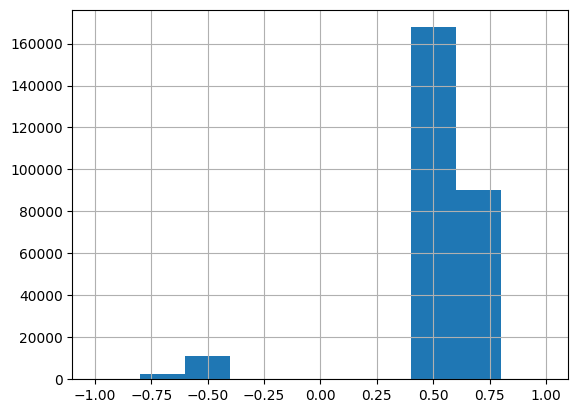

In [23]:
spearman_pairwise['coef'].hist(range=[-1, 1])

<Axes: >

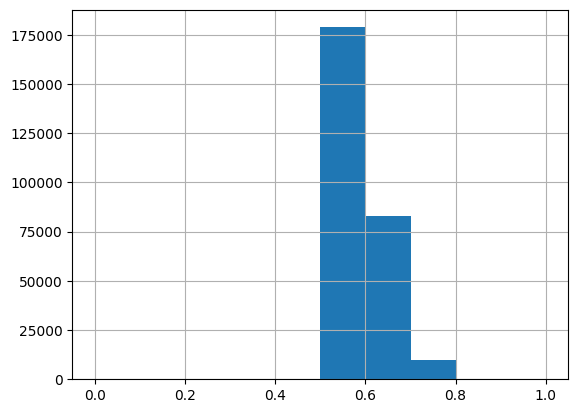

In [24]:
abs(spearman_pairwise['coef']).hist(range=[0, 1])

In [25]:
# filter for effect
df_no_effect = spearman_pairwise[abs(spearman_pairwise['coef'])<0.01]
df_very_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.01]
df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
df_effect = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
print('\nNumber of analyte pairs whose effect size is at least weak: '.format(str(df_effect.shape[0])))


# evaluate effect size - cohen's d
df_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
df_small = df_small[abs(df_small['coef'])<0.2]
df_medium = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.2]
df_medium  = df_medium[abs(df_medium['coef'])<0.3]
df_medium_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.3]
df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
df_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.5]
df_large = df_large[abs(df_large['coef'])<0.7]
df_very_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.7]
df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
df_huge = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.9]

# print info on effect sizes
print('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
print('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
print('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
print('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
print('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
print('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
print('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
print('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))


Number of analyte pairs whose effect size is at least weak: 
Number of Analyte Pairs with No Monotonic Relationship: 0
Number of Analyte Pairs with Very Weak Monotonic Relationship: 0
Number of Analyte Pairs with Weak Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Strong Monotonic Relationship: 0
Number of Analyte Pairs with Strong Monotonic Relationship: 262007
Number of Analyte Pairs with Very Strong Monotonic Relationship: 9779
Number of Analyte Pairs with Near Perfect Monotonic Relationship: 0
